# JAFFE Model

# Pre-processing

Import the JAFFE dataset and extract dominant labels. The image name consists of two parts, the name of model and the dominanat label, eg: KM is the name of model with neutral as dominant feature

In [1]:
#set this to true to train new models, setting this variable to True will make the code excute in a longer time and its
#unncessary for the project to run correctly as a keras model is already saved in saved_models/best_model.h5
train_flag = True

In [2]:
from PIL import Image
import glob
from matplotlib import pyplot as plt
import numpy as np

raw_images = []
raw_labels = []
for filename in glob.glob('jaffe\images/*.tiff'):
    raw_labels.append(filename[16:18])
    im = Image.open(filename)
    raw_images.append(im)
#make sure images are uploaded correctly
print(len(raw_images))
imgplot = plt.imshow(raw_images[0])
#plot the number of each label
num_neutral = raw_labels.count('NE')
num_happy = raw_labels.count('HA')
num_sad = raw_labels.count('SA')
num_surprised = raw_labels.count('SU')
num_angry = raw_labels.count('AN')
num_disgust = raw_labels.count('DI')
num_fear = raw_labels.count('FE')
print("The number of labels are as follows")
print("Neutral : {}  Happy : {}  Sad : {}  Surprised : {}  Angry : {}  Disgust : {}  Fear : {}"\
      .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

213
The number of labels are as follows
Neutral : 30  Happy : 31  Sad : 31  Surprised : 30  Angry : 30  Disgust : 29  Fear : 32


### Train_Test Split

DI


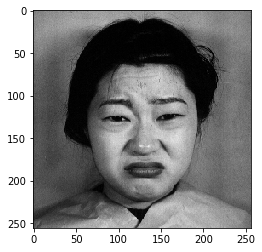

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(raw_images, raw_labels, test_size = 0.25, random_state = 42, shuffle = True)
plt.imshow(X_train[0], cmap = plt.cm.gray)
print(Y_train[0])

### Augmentation

Add random gaussian noise, random rotation and random skewness to the images. Translation wont be used in this project since the image will be cropped to just the face.

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


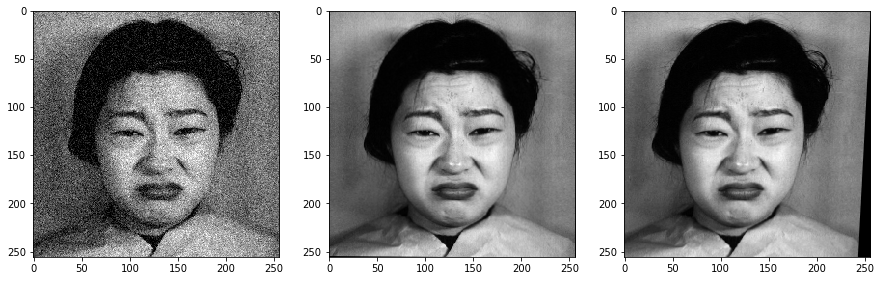

In [4]:
from preprocessing import random_noise, random_rotation, random_skew

plt.figure(1, figsize=(15, 15))
plt.subplot(1,3,1)
plt.imshow(random_noise(X_train[0]), cmap = plt.cm.gray)
plt.subplot(1,3,2)
plt.imshow(random_rotation(X_train[0]), cmap = plt.cm.gray)
plt.subplot(1,3,3)
plt.imshow(random_skew(X_train[0]), cmap = plt.cm.gray)

Apply the transformation functions to the dataset to obtain a dataset of 1000 images

In [5]:
from preprocessing import augment
#augment training dataset
augmented_train_iamges, augmented_train_labels = augment(X_train, Y_train, desired_size = 500)
print("train dataset size is: {} images".format(len(augmented_train_iamges)))

#augment testing dataset
X_test, Y_test = augment(X_test, Y_test, desired_size = 100)
print("test dataset size is: {} images".format(len(X_test)))

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


train dataset size is: 500 images
test dataset size is: 100 images


In [6]:
from preprocessing import JAFFE_count
#print number of labels in training dataset
num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear = JAFFE_count(augmented_train_labels)
print("The training dataset contains {} neutral, {} happy, {} sad, {} surprised, {} angry, {} disgust, {} fear images"
     .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

#print the number of labels in testing dataset
num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear = JAFFE_count(Y_test)
print("The testing dataset contains {} neutral, {} happy, {} sad, {} surprised, {} angry, {} disgust, {} fear images"
     .format(num_neutral, num_happy, num_sad, num_surprised, num_angry, num_disgust, num_fear))

The training dataset contains 59 neutral, 76 happy, 96 sad, 69 surprised, 55 angry, 74 disgust, 71 fear images
The testing dataset contains 17 neutral, 18 happy, 10 sad, 18 surprised, 15 angry, 7 disgust, 15 fear images


### Encoding Labels
Transform the labels into a vector of seven numbers [Neutral Happy Sad Surprised Angry Disgust Fear] where an entry of 1 describes the label of the image

[0 1 0 0 0 0 0] descrbies a happy image

In [7]:
from preprocessing import JAFFE_encode
augmented_train_labels = JAFFE_encode(augmented_train_labels)
print(len(augmented_train_labels))
print(augmented_train_labels[0])

Y_test = JAFFE_encode(Y_test)
print(len(Y_test))
print(Y_test[0])

500
[0. 0. 0. 0. 0. 1. 0.]
100
[0. 0. 0. 0. 0. 0. 1.]


### Face detection

Number of faces detected: 1


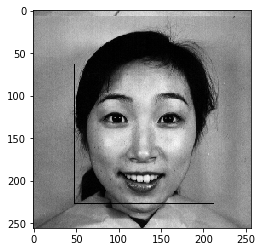

In [8]:
import cv2 
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
img = np.array(augmented_train_iamges[50])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)


### Cropping
before cropping we want to remove images that have zero detected faces or more than one detected face. also remove images that have too small detected faces (some images have detected faces that are not actually faces and are too small regions)

In [9]:
from preprocessing import crop_face
#crop training images
train_images, train_labels = crop_face(augmented_train_iamges, augmented_train_labels)
print("\rfinal train dataset size after removing images with undetectable faces = {}".format(len(train_images)))

#crop testing images
test_images, test_labels = crop_face(X_test, Y_test)
print("\rfinal test dataset size after removing images with undetectable faces = {}".format(len(test_images)))

final train dataset size after removing images with undetectable faces = 498
final test dataset size after removing images with undetectable faces = 100


[0. 0. 1. 0. 0. 0. 0.]


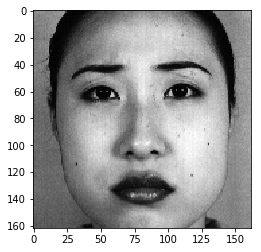

In [10]:
plt.imshow(train_images[20], cmap = plt.cm.gray)
print(train_labels[20])

In [11]:
#resize all images to largest cropped image size
from preprocessing import resize
final_size = 197 #final size of images
train_images = resize(train_images, final_size)
test_images = resize(test_images, final_size)
print("The final image dataset has a dimensions of {}".format(train_images[0].size))

The final image dataset has a dimensions of (197, 197)


### Normalization

In [12]:
from preprocessing import normalize

norm_train_images = [normalize(train_images[i]) for i in range(len(train_images))]
print(norm_train_images[0])

norm_test_images = [normalize(test_images[i]) for i in range(len(test_images))]

[[0.45374449 0.39647577 0.34801762 ... 0.19823789 0.19823789 0.1938326 ]
 [0.4185022  0.35242291 0.2907489  ... 0.14096916 0.22907489 0.21585903]
 [0.37004405 0.38325991 0.26431718 ... 0.07929515 0.15418502 0.17180617]
 ...
 [0.25550661 0.25550661 0.24669604 ... 0.59030837 0.56387665 0.54185022]
 [0.23788546 0.24229075 0.24669604 ... 0.59911894 0.58590308 0.57709251]
 [0.23348018 0.21145374 0.22907489 ... 0.60792952 0.6123348  0.59030837]]


### Convert to 4D tensors

In [13]:
def convert_to_tensors(image_array, n_channels):
    image_array = np.array(image_array)
    tensors = np.resize(image_array, (image_array.shape[0], image_array.shape[1], image_array.shape[2], n_channels))
    return tensors

In [14]:

X_train_jaffe = convert_to_tensors(norm_train_images, 1)
X_test_jaffe = convert_to_tensors(norm_test_images, 1)
Y_train_jaffe = train_labels
Y_test_jaffe = test_labels
print(X_train_jaffe.shape)
print(X_test_jaffe.shape)

(498, 197, 197, 1)
(100, 197, 197, 1)


# Training

### Initialize  Hyperparameters Grid

In [15]:

parameters_grid = {
    'initial_n_filters' : [16, 32, 64],
    'kernel_size' : [2, 3, 4, 5, 6, 7]
}

### Creating Model

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import RMSprop

def create_model(parameters):
    model = Sequential()

    model.add(Conv2D(name = "conv1", filters= parameters['initial_n_filters'], kernel_size = parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', 
                        activation='relu', input_shape=(X_train_jaffe.shape[1], X_train_jaffe.shape[2], 1)))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(name = "conv2", filters= parameters['initial_n_filters']*2, kernel_size = parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', activation='relu')) 
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(name = "conv3", filters=random_parameters['initial_n_filters']*4, kernel_size = random_parameters['kernel_size'], 
                     strides=1,kernel_initializer = 'random_normal', padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
    model.add(Dropout(0.2))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

Using TensorFlow backend.


### Create optimizer

In [17]:
def create_RMSprop_optimizer(parameters):
    return RMSprop()

###  Compile and Train Model

In [18]:
import random
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, History


if(train_flag == True):
    #select how many random hyperparameters selection iterations
    n_iterations = 10
    #initlaize global min_val_loss
    global_min_val_loss = np.inf
    for i in range(n_iterations):
        print('\r{}/{}'. format(i, n_iterations))
        #initilaize random hyperparameters
        random_parameters = {K: random.sample(V, 1)[0] for K, V in parameters_grid.items()}
        #create model with random hyperparameters
        model = create_model(random_parameters)
        opt = create_RMSprop_optimizer(random_parameters)
        #compile model
        model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        #train model
        epochs = 1000
        checkpointer = ModelCheckpoint(filepath='saved_models/model_weights.hdf5', verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
        history = model.fit(X_train_jaffe, Y_train_jaffe,
                  callbacks = [checkpointer, early_stopping],
                  validation_split = 0.33,
                  epochs=epochs, batch_size = 20, verbose=1)
        #compare current min validation loss with global min validation loss
        current_min_val_loss = np.min(history.history['val_loss'])
        if(current_min_val_loss < global_min_val_loss):
            global_min_val_loss = current_min_val_loss
            #save the best model so far
            model.load_weights('saved_models/model_weights.hdf5')
            model.save('saved_models/best_model.h5')
            print('saving new best model, val_loss = {}'.format(current_min_val_loss))
            #save best hyperparameters
            best_hyperparameters = random_parameters




0/10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 197, 197, 16)      80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 98, 98, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 49, 49, 64)        8256      
_____


Epoch 00032: val_loss did not improve from 1.92908
Epoch 33/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9354 - acc: 0.1802 - val_loss: 1.9307 - val_acc: 0.2182

Epoch 00033: val_loss did not improve from 1.92908
Epoch 34/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9361 - acc: 0.1802 - val_loss: 1.9309 - val_acc: 0.2182

Epoch 00034: val_loss did not improve from 1.92908
Epoch 35/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9347 - acc: 0.1802 - val_loss: 1.9294 - val_acc: 0.2182

Epoch 00035: val_loss did not improve from 1.92908
Epoch 36/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9358 - acc: 0.1802 - val_loss: 1.9293 - val_acc: 0.2182

Epoch 00036: val_loss did not improve from 1.92908
Epoch 37/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9359 - acc: 0.1802 - val_loss: 1.9294 - val_acc: 0.2182

Epoch 00037: val_loss did not improve from 1.92908
Epoch 38/1000

333/333 [==============================] - 1s 2ms/step - loss: 1.9224 - acc: 0.1832 - val_loss: 1.9094 - val_acc: 0.2364

Epoch 00072: val_loss improved from 1.91071 to 1.90938, saving model to saved_models/model_weights.hdf5
Epoch 73/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9205 - acc: 0.1862 - val_loss: 1.9132 - val_acc: 0.2121

Epoch 00073: val_loss did not improve from 1.90938
Epoch 74/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9236 - acc: 0.1982 - val_loss: 1.9099 - val_acc: 0.2424

Epoch 00074: val_loss did not improve from 1.90938
Epoch 75/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9163 - acc: 0.2012 - val_loss: 1.9126 - val_acc: 0.1939

Epoch 00075: val_loss did not improve from 1.90938
Epoch 76/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9156 - acc: 0.2012 - val_loss: 1.9134 - val_acc: 0.2061

Epoch 00076: val_loss did not improve from 1.90938
Epoch 77/1000
333/333 [===

333/333 [==============================] - 1s 2ms/step - loss: 1.9055 - acc: 0.2012 - val_loss: 1.8933 - val_acc: 0.2061

Epoch 00112: val_loss did not improve from 1.88543
Epoch 113/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8971 - acc: 0.2102 - val_loss: 1.8839 - val_acc: 0.2242

Epoch 00113: val_loss improved from 1.88543 to 1.88395, saving model to saved_models/model_weights.hdf5
Epoch 114/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9012 - acc: 0.2072 - val_loss: 1.9434 - val_acc: 0.1879

Epoch 00114: val_loss did not improve from 1.88395
Epoch 115/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8923 - acc: 0.1922 - val_loss: 1.8905 - val_acc: 0.2000

Epoch 00115: val_loss did not improve from 1.88395
Epoch 116/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9065 - acc: 0.1952 - val_loss: 1.8918 - val_acc: 0.2000

Epoch 00116: val_loss did not improve from 1.88395
Epoch 117/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8940 - acc: 0.1862 - val_loss: 1.8921 - val_acc: 0.2182

Epoch 00154: val_loss did not improve from 1.87701
Epoch 155/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9016 - acc: 0.1772 - val_loss: 1.8870 - val_acc: 0.1879

Epoch 00155: val_loss did not improve from 1.87701
Epoch 156/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9062 - acc: 0.1922 - val_loss: 1.8764 - val_acc: 0.1879

Epoch 00156: val_loss improved from 1.87701 to 1.87641, saving model to saved_models/model_weights.hdf5
Epoch 157/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8868 - acc: 0.1952 - val_loss: 1.8755 - val_acc: 0.2182

Epoch 00157: val_loss improved from 1.87641 to 1.87551, saving model to saved_models/model_weights.hdf5
Epoch 158/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8991 - acc: 0.2192 - val_loss: 1.8799 - val_acc: 0.2182

Epoch 00158: val_los

333/333 [==============================] - 1s 2ms/step - loss: 1.8951 - acc: 0.2162 - val_loss: 1.8750 - val_acc: 0.2000

Epoch 00196: val_loss did not improve from 1.86931
Epoch 197/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8919 - acc: 0.2132 - val_loss: 1.8676 - val_acc: 0.2182

Epoch 00197: val_loss improved from 1.86931 to 1.86760, saving model to saved_models/model_weights.hdf5
Epoch 198/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8977 - acc: 0.1862 - val_loss: 1.8699 - val_acc: 0.1879

Epoch 00198: val_loss did not improve from 1.86760
Epoch 199/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8944 - acc: 0.2162 - val_loss: 1.8670 - val_acc: 0.1818

Epoch 00199: val_loss improved from 1.86760 to 1.86699, saving model to saved_models/model_weights.hdf5
Epoch 200/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8907 - acc: 0.1982 - val_loss: 1.8710 - val_acc: 0.1818

Epoch 00200: val_los


Epoch 00238: val_loss did not improve from 1.86542
Epoch 239/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8884 - acc: 0.2252 - val_loss: 1.8719 - val_acc: 0.1879

Epoch 00239: val_loss did not improve from 1.86542
Epoch 240/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8855 - acc: 0.2192 - val_loss: 1.8928 - val_acc: 0.2182

Epoch 00240: val_loss did not improve from 1.86542
Epoch 241/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8838 - acc: 0.2072 - val_loss: 1.8775 - val_acc: 0.2000

Epoch 00241: val_loss did not improve from 1.86542
Epoch 242/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8886 - acc: 0.2042 - val_loss: 1.8698 - val_acc: 0.1939

Epoch 00242: val_loss did not improve from 1.86542
Epoch 243/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8907 - acc: 0.2102 - val_loss: 1.8716 - val_acc: 0.2182

Epoch 00243: val_loss did not improve from 1.86542
Epoch 24

333/333 [==============================] - 1s 2ms/step - loss: 1.8892 - acc: 0.2282 - val_loss: 1.8664 - val_acc: 0.2182

Epoch 00281: val_loss did not improve from 1.86005
Epoch 282/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8845 - acc: 0.2192 - val_loss: 1.8886 - val_acc: 0.2242

Epoch 00282: val_loss did not improve from 1.86005
Epoch 283/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8775 - acc: 0.2342 - val_loss: 1.8642 - val_acc: 0.2061

Epoch 00283: val_loss did not improve from 1.86005
Epoch 284/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8825 - acc: 0.2102 - val_loss: 1.8687 - val_acc: 0.2000

Epoch 00284: val_loss did not improve from 1.86005
Epoch 285/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8776 - acc: 0.1952 - val_loss: 1.8707 - val_acc: 0.1818

Epoch 00285: val_loss did not improve from 1.86005
Epoch 286/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00323: val_loss did not improve from 1.85261
Epoch 324/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8706 - acc: 0.2583 - val_loss: 1.8588 - val_acc: 0.2182

Epoch 00324: val_loss did not improve from 1.85261
Epoch 325/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8722 - acc: 0.2222 - val_loss: 1.8553 - val_acc: 0.2606

Epoch 00325: val_loss did not improve from 1.85261
Epoch 326/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8733 - acc: 0.2282 - val_loss: 1.8625 - val_acc: 0.2000

Epoch 00326: val_loss did not improve from 1.85261
Epoch 327/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8844 - acc: 0.2432 - val_loss: 1.8629 - val_acc: 0.2485

Epoch 00327: val_loss did not improve from 1.85261
Epoch 328/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8741 - acc: 0.2402 - val_loss: 1.8545 - val_acc: 0.2242

Epoch 00328: val_loss did not improve from 1.85261
Epoch 32

333/333 [==============================] - 1s 2ms/step - loss: 1.8503 - acc: 0.2793 - val_loss: 1.8375 - val_acc: 0.2485

Epoch 00366: val_loss did not improve from 1.83545
Epoch 367/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8507 - acc: 0.2462 - val_loss: 1.8582 - val_acc: 0.2364

Epoch 00367: val_loss did not improve from 1.83545
Epoch 368/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8426 - acc: 0.2763 - val_loss: 1.8521 - val_acc: 0.2121

Epoch 00368: val_loss did not improve from 1.83545
Epoch 369/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8553 - acc: 0.2703 - val_loss: 1.8454 - val_acc: 0.2303

Epoch 00369: val_loss did not improve from 1.83545
Epoch 370/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8448 - acc: 0.2553 - val_loss: 1.8370 - val_acc: 0.2606

Epoch 00370: val_loss did not improve from 1.83545
Epoch 371/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.8166 - acc: 0.2883 - val_loss: 1.8248 - val_acc: 0.2424

Epoch 00408: val_loss did not improve from 1.79618
Epoch 409/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8048 - acc: 0.2973 - val_loss: 1.8109 - val_acc: 0.3212

Epoch 00409: val_loss did not improve from 1.79618
Epoch 410/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8194 - acc: 0.2913 - val_loss: 1.8024 - val_acc: 0.2909

Epoch 00410: val_loss did not improve from 1.79618
Epoch 411/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8134 - acc: 0.3093 - val_loss: 1.8209 - val_acc: 0.2485

Epoch 00411: val_loss did not improve from 1.79618
Epoch 412/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8033 - acc: 0.3153 - val_loss: 1.8145 - val_acc: 0.2545

Epoch 00412: val_loss did not improve from 1.79618
Epoch 413/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.7515 - acc: 0.3183 - val_loss: 1.7629 - val_acc: 0.3030

Epoch 00450: val_loss did not improve from 1.74393
Epoch 451/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7400 - acc: 0.3123 - val_loss: 1.7427 - val_acc: 0.2727

Epoch 00451: val_loss improved from 1.74393 to 1.74273, saving model to saved_models/model_weights.hdf5
Epoch 452/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7629 - acc: 0.2943 - val_loss: 1.7947 - val_acc: 0.3212

Epoch 00452: val_loss did not improve from 1.74273
Epoch 453/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7377 - acc: 0.3483 - val_loss: 1.7885 - val_acc: 0.3091

Epoch 00453: val_loss did not improve from 1.74273
Epoch 454/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7493 - acc: 0.3363 - val_loss: 1.7396 - val_acc: 0.2909

Epoch 00454: val_loss improved from 1.74273 to 1.73958, saving model to s


Epoch 00491: val_loss did not improve from 1.71050
Epoch 492/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6885 - acc: 0.3574 - val_loss: 1.7303 - val_acc: 0.2848

Epoch 00492: val_loss did not improve from 1.71050
Epoch 493/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6888 - acc: 0.3814 - val_loss: 1.7177 - val_acc: 0.3212

Epoch 00493: val_loss did not improve from 1.71050
Epoch 494/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6713 - acc: 0.3393 - val_loss: 1.7112 - val_acc: 0.3576

Epoch 00494: val_loss did not improve from 1.71050
Epoch 495/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6896 - acc: 0.3634 - val_loss: 1.7888 - val_acc: 0.3091

Epoch 00495: val_loss did not improve from 1.71050
Epoch 496/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6838 - acc: 0.3483 - val_loss: 1.7457 - val_acc: 0.3333

Epoch 00496: val_loss did not improve from 1.71050
Epoch 49


Epoch 00533: val_loss did not improve from 1.65193
Epoch 534/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6307 - acc: 0.3694 - val_loss: 1.6761 - val_acc: 0.3697

Epoch 00534: val_loss did not improve from 1.65193
Epoch 535/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6432 - acc: 0.3514 - val_loss: 1.6557 - val_acc: 0.3030

Epoch 00535: val_loss did not improve from 1.65193
Epoch 536/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6436 - acc: 0.3844 - val_loss: 1.6550 - val_acc: 0.3515

Epoch 00536: val_loss did not improve from 1.65193
Epoch 537/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6420 - acc: 0.3694 - val_loss: 1.6945 - val_acc: 0.3273

Epoch 00537: val_loss did not improve from 1.65193
Epoch 538/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6449 - acc: 0.3604 - val_loss: 1.6771 - val_acc: 0.3394

Epoch 00538: val_loss did not improve from 1.65193
Epoch 53

333/333 [==============================] - 1s 2ms/step - loss: 1.5752 - acc: 0.4294 - val_loss: 1.6138 - val_acc: 0.3515

Epoch 00576: val_loss improved from 1.62487 to 1.61376, saving model to saved_models/model_weights.hdf5
Epoch 577/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5957 - acc: 0.3514 - val_loss: 1.6012 - val_acc: 0.3697

Epoch 00577: val_loss improved from 1.61376 to 1.60121, saving model to saved_models/model_weights.hdf5
Epoch 578/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5857 - acc: 0.3934 - val_loss: 1.6673 - val_acc: 0.3152

Epoch 00578: val_loss did not improve from 1.60121
Epoch 579/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5772 - acc: 0.3904 - val_loss: 1.6102 - val_acc: 0.3455

Epoch 00579: val_loss did not improve from 1.60121
Epoch 580/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5638 - acc: 0.4114 - val_loss: 1.5905 - val_acc: 0.3818

Epoch 00580: val_los


Epoch 00618: val_loss did not improve from 1.57825
Epoch 619/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5322 - acc: 0.3724 - val_loss: 1.5792 - val_acc: 0.3818

Epoch 00619: val_loss did not improve from 1.57825
Epoch 620/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5126 - acc: 0.4054 - val_loss: 1.6696 - val_acc: 0.2909

Epoch 00620: val_loss did not improve from 1.57825
Epoch 621/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5086 - acc: 0.4264 - val_loss: 1.6518 - val_acc: 0.3212

Epoch 00621: val_loss did not improve from 1.57825
Epoch 622/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5184 - acc: 0.4114 - val_loss: 1.6613 - val_acc: 0.3273

Epoch 00622: val_loss did not improve from 1.57825
Epoch 623/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5122 - acc: 0.4294 - val_loss: 1.6152 - val_acc: 0.3212

Epoch 00623: val_loss did not improve from 1.57825
Epoch 62

333/333 [==============================] - 1s 2ms/step - loss: 1.5020 - acc: 0.4324 - val_loss: 1.5915 - val_acc: 0.3576

Epoch 00661: val_loss did not improve from 1.53004
Epoch 662/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5389 - acc: 0.3964 - val_loss: 1.5718 - val_acc: 0.3697

Epoch 00662: val_loss did not improve from 1.53004
Epoch 663/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5187 - acc: 0.4384 - val_loss: 1.5549 - val_acc: 0.4061

Epoch 00663: val_loss did not improve from 1.53004
Epoch 664/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4966 - acc: 0.4204 - val_loss: 1.5669 - val_acc: 0.3939

Epoch 00664: val_loss did not improve from 1.53004
Epoch 665/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4894 - acc: 0.4474 - val_loss: 1.6021 - val_acc: 0.3333

Epoch 00665: val_loss did not improve from 1.53004
Epoch 666/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.4433 - acc: 0.4505 - val_loss: 1.6034 - val_acc: 0.3636

Epoch 00704: val_loss did not improve from 1.51015
Epoch 705/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4796 - acc: 0.4234 - val_loss: 1.5665 - val_acc: 0.4000

Epoch 00705: val_loss did not improve from 1.51015
Epoch 706/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4577 - acc: 0.4354 - val_loss: 1.5291 - val_acc: 0.4242

Epoch 00706: val_loss did not improve from 1.51015
Epoch 707/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4428 - acc: 0.4384 - val_loss: 1.5638 - val_acc: 0.3818

Epoch 00707: val_loss did not improve from 1.51015
Epoch 708/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4806 - acc: 0.4354 - val_loss: 1.5046 - val_acc: 0.4364

Epoch 00708: val_loss improved from 1.51015 to 1.50456, saving model to saved_models/model_weights.hdf5
Epoch 709/1000
333/333


Epoch 00746: val_loss improved from 1.47723 to 1.46248, saving model to saved_models/model_weights.hdf5
Epoch 747/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4155 - acc: 0.4625 - val_loss: 1.5156 - val_acc: 0.4121

Epoch 00747: val_loss did not improve from 1.46248
Epoch 748/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4152 - acc: 0.4595 - val_loss: 1.4759 - val_acc: 0.4182

Epoch 00748: val_loss did not improve from 1.46248
Epoch 749/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4086 - acc: 0.4655 - val_loss: 1.5976 - val_acc: 0.3515

Epoch 00749: val_loss did not improve from 1.46248
Epoch 750/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4377 - acc: 0.4264 - val_loss: 1.4951 - val_acc: 0.4545

Epoch 00750: val_loss did not improve from 1.46248
Epoch 751/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4293 - acc: 0.4655 - val_loss: 1.5006 - val_acc: 0.4303

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 1.4002 - acc: 0.4444 - val_loss: 1.4890 - val_acc: 0.4364

Epoch 00789: val_loss did not improve from 1.44302
Epoch 790/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3813 - acc: 0.4685 - val_loss: 1.4998 - val_acc: 0.4242

Epoch 00790: val_loss did not improve from 1.44302
Epoch 791/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4040 - acc: 0.4715 - val_loss: 1.4875 - val_acc: 0.4303

Epoch 00791: val_loss did not improve from 1.44302
Epoch 792/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4016 - acc: 0.4685 - val_loss: 1.4550 - val_acc: 0.4667

Epoch 00792: val_loss did not improve from 1.44302
Epoch 793/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4014 - acc: 0.4835 - val_loss: 1.8171 - val_acc: 0.2788

Epoch 00793: val_loss did not improve from 1.44302
Epoch 794/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.3771 - acc: 0.4655 - val_loss: 1.4350 - val_acc: 0.4909

Epoch 00832: val_loss did not improve from 1.42494
Epoch 833/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3529 - acc: 0.5015 - val_loss: 1.4659 - val_acc: 0.4364

Epoch 00833: val_loss did not improve from 1.42494
Epoch 834/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3677 - acc: 0.4925 - val_loss: 1.4125 - val_acc: 0.4909

Epoch 00834: val_loss improved from 1.42494 to 1.41251, saving model to saved_models/model_weights.hdf5
Epoch 835/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3609 - acc: 0.5045 - val_loss: 1.4917 - val_acc: 0.4303

Epoch 00835: val_loss did not improve from 1.41251
Epoch 836/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3871 - acc: 0.4835 - val_loss: 1.4278 - val_acc: 0.4909

Epoch 00836: val_loss did not improve from 1.41251
Epoch 837/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.3580 - acc: 0.5105 - val_loss: 1.3682 - val_acc: 0.5152

Epoch 00874: val_loss improved from 1.38991 to 1.36818, saving model to saved_models/model_weights.hdf5
Epoch 875/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2928 - acc: 0.5405 - val_loss: 1.4268 - val_acc: 0.4485

Epoch 00875: val_loss did not improve from 1.36818
Epoch 876/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3324 - acc: 0.5285 - val_loss: 1.4205 - val_acc: 0.4909

Epoch 00876: val_loss did not improve from 1.36818
Epoch 877/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3591 - acc: 0.5045 - val_loss: 1.4189 - val_acc: 0.4606

Epoch 00877: val_loss did not improve from 1.36818
Epoch 878/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3537 - acc: 0.5165 - val_loss: 1.4226 - val_acc: 0.4606

Epoch 00878: val_loss did not improve from 1.36818
Epoch 879/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.3138 - acc: 0.5225 - val_loss: 1.4236 - val_acc: 0.4606

Epoch 00917: val_loss did not improve from 1.35848
Epoch 918/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3334 - acc: 0.4925 - val_loss: 1.4475 - val_acc: 0.4788

Epoch 00918: val_loss did not improve from 1.35848
Epoch 919/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3189 - acc: 0.5105 - val_loss: 1.4474 - val_acc: 0.4485

Epoch 00919: val_loss did not improve from 1.35848
Epoch 920/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2978 - acc: 0.5405 - val_loss: 1.4954 - val_acc: 0.4242

Epoch 00920: val_loss did not improve from 1.35848
Epoch 921/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2940 - acc: 0.5135 - val_loss: 1.3536 - val_acc: 0.5212

Epoch 00921: val_loss improved from 1.35848 to 1.35360, saving model to saved_models/model_weights.hdf5
Epoch 922/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.2943 - acc: 0.5135 - val_loss: 1.3579 - val_acc: 0.4909

Epoch 00959: val_loss did not improve from 1.33683
Epoch 960/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2854 - acc: 0.5195 - val_loss: 1.3626 - val_acc: 0.5030

Epoch 00960: val_loss did not improve from 1.33683
Epoch 961/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2906 - acc: 0.5345 - val_loss: 1.3745 - val_acc: 0.5091

Epoch 00961: val_loss did not improve from 1.33683
Epoch 962/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3140 - acc: 0.4865 - val_loss: 1.3677 - val_acc: 0.4970

Epoch 00962: val_loss did not improve from 1.33683
Epoch 963/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2751 - acc: 0.5405 - val_loss: 1.3360 - val_acc: 0.5636

Epoch 00963: val_loss improved from 1.33683 to 1.33601, saving model to saved_models/model_weights.hdf5
Epoch 964/1000
333/333

Train on 333 samples, validate on 165 samples
Epoch 1/1000
333/333 [==============================] - 1s 4ms/step - loss: 1.9513 - acc: 0.1592 - val_loss: 1.9409 - val_acc: 0.2182

Epoch 00001: val_loss improved from inf to 1.94086, saving model to saved_models/model_weights.hdf5
Epoch 2/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9464 - acc: 0.1471 - val_loss: 1.9384 - val_acc: 0.2182

Epoch 00002: val_loss improved from 1.94086 to 1.93839, saving model to saved_models/model_weights.hdf5
Epoch 3/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9417 - acc: 0.1712 - val_loss: 1.9367 - val_acc: 0.2182

Epoch 00003: val_loss improved from 1.93839 to 1.93669, saving model to saved_models/model_weights.hdf5
Epoch 4/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9420 - acc: 0.1802 - val_loss: 1.9370 - val_acc: 0.2182

Epoch 00004: val_loss did not improve from 1.93669
Epoch 5/1000
333/333 [==============================] -


Epoch 00037: val_loss did not improve from 1.87600
Epoch 38/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8863 - acc: 0.2222 - val_loss: 1.8693 - val_acc: 0.2727

Epoch 00038: val_loss improved from 1.87600 to 1.86932, saving model to saved_models/model_weights.hdf5
Epoch 39/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8914 - acc: 0.2673 - val_loss: 1.8642 - val_acc: 0.2667

Epoch 00039: val_loss improved from 1.86932 to 1.86424, saving model to saved_models/model_weights.hdf5
Epoch 40/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8916 - acc: 0.2312 - val_loss: 1.8789 - val_acc: 0.2667

Epoch 00040: val_loss did not improve from 1.86424
Epoch 41/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8803 - acc: 0.2673 - val_loss: 1.8819 - val_acc: 0.2000

Epoch 00041: val_loss did not improve from 1.86424
Epoch 42/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8891 - acc: 0.2

Epoch 78/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7480 - acc: 0.3303 - val_loss: 1.7355 - val_acc: 0.3515

Epoch 00078: val_loss improved from 1.74092 to 1.73553, saving model to saved_models/model_weights.hdf5
Epoch 79/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7627 - acc: 0.3213 - val_loss: 1.7540 - val_acc: 0.3212

Epoch 00079: val_loss did not improve from 1.73553
Epoch 80/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7694 - acc: 0.3363 - val_loss: 1.7620 - val_acc: 0.3333

Epoch 00080: val_loss did not improve from 1.73553
Epoch 81/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7746 - acc: 0.3213 - val_loss: 1.9111 - val_acc: 0.2545

Epoch 00081: val_loss did not improve from 1.73553
Epoch 82/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7628 - acc: 0.3303 - val_loss: 1.7593 - val_acc: 0.3333

Epoch 00082: val_loss did not improve from 1.73553
Epoch 83/100

333/333 [==============================] - 1s 2ms/step - loss: 1.6432 - acc: 0.3754 - val_loss: 1.7665 - val_acc: 0.3152

Epoch 00119: val_loss did not improve from 1.65110
Epoch 120/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6604 - acc: 0.3874 - val_loss: 1.6942 - val_acc: 0.3576

Epoch 00120: val_loss did not improve from 1.65110
Epoch 121/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6794 - acc: 0.3754 - val_loss: 1.6794 - val_acc: 0.4121

Epoch 00121: val_loss did not improve from 1.65110
Epoch 122/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6582 - acc: 0.4024 - val_loss: 1.6741 - val_acc: 0.3455

Epoch 00122: val_loss did not improve from 1.65110
Epoch 123/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6557 - acc: 0.3814 - val_loss: 1.6387 - val_acc: 0.4182

Epoch 00123: val_loss improved from 1.65110 to 1.63875, saving model to saved_models/model_weights.hdf5
Epoch 124/1000
333/333


Epoch 00160: val_loss improved from 1.55524 to 1.55387, saving model to saved_models/model_weights.hdf5
Epoch 161/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5218 - acc: 0.4024 - val_loss: 1.5877 - val_acc: 0.4424

Epoch 00161: val_loss did not improve from 1.55387
Epoch 162/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6025 - acc: 0.3784 - val_loss: 1.5898 - val_acc: 0.4000

Epoch 00162: val_loss did not improve from 1.55387
Epoch 163/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5531 - acc: 0.4054 - val_loss: 1.5808 - val_acc: 0.3758

Epoch 00163: val_loss did not improve from 1.55387
Epoch 164/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5481 - acc: 0.3844 - val_loss: 1.6134 - val_acc: 0.3758

Epoch 00164: val_loss did not improve from 1.55387
Epoch 165/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5690 - acc: 0.3994 - val_loss: 1.6268 - val_acc: 0.3818

Epoch 


Epoch 00202: val_loss did not improve from 1.42722
Epoch 203/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4404 - acc: 0.4565 - val_loss: 1.4894 - val_acc: 0.4182

Epoch 00203: val_loss did not improve from 1.42722
Epoch 204/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3905 - acc: 0.4775 - val_loss: 1.5553 - val_acc: 0.4424

Epoch 00204: val_loss did not improve from 1.42722
Epoch 205/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4175 - acc: 0.4655 - val_loss: 1.5164 - val_acc: 0.4000

Epoch 00205: val_loss did not improve from 1.42722
Epoch 206/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4095 - acc: 0.4895 - val_loss: 1.4335 - val_acc: 0.5030

Epoch 00206: val_loss did not improve from 1.42722
Epoch 207/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3744 - acc: 0.4985 - val_loss: 1.4990 - val_acc: 0.3818

Epoch 00207: val_loss did not improve from 1.42722
Epoch 20

333/333 [==============================] - 1s 2ms/step - loss: 1.2429 - acc: 0.5105 - val_loss: 1.3211 - val_acc: 0.5394

Epoch 00245: val_loss did not improve from 1.30669
Epoch 246/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2577 - acc: 0.5616 - val_loss: 1.2740 - val_acc: 0.5030

Epoch 00246: val_loss improved from 1.30669 to 1.27398, saving model to saved_models/model_weights.hdf5
Epoch 247/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2597 - acc: 0.5465 - val_loss: 1.5200 - val_acc: 0.4303

Epoch 00247: val_loss did not improve from 1.27398
Epoch 248/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2644 - acc: 0.5435 - val_loss: 1.3274 - val_acc: 0.4424

Epoch 00248: val_loss did not improve from 1.27398
Epoch 249/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2409 - acc: 0.5315 - val_loss: 1.3026 - val_acc: 0.5515

Epoch 00249: val_loss did not improve from 1.27398
Epoch 250/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.1027 - acc: 0.5916 - val_loss: 1.1601 - val_acc: 0.5212

Epoch 00286: val_loss did not improve from 1.15915
Epoch 287/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1056 - acc: 0.6036 - val_loss: 1.1591 - val_acc: 0.5212

Epoch 00287: val_loss improved from 1.15915 to 1.15912, saving model to saved_models/model_weights.hdf5
Epoch 288/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1287 - acc: 0.5946 - val_loss: 1.2650 - val_acc: 0.4909

Epoch 00288: val_loss did not improve from 1.15912
Epoch 289/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0980 - acc: 0.6216 - val_loss: 1.1597 - val_acc: 0.5879

Epoch 00289: val_loss did not improve from 1.15912
Epoch 290/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1178 - acc: 0.6066 - val_loss: 1.1621 - val_acc: 0.5515

Epoch 00290: val_loss did not improve from 1.15912
Epoch 291/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.9852 - acc: 0.6547 - val_loss: 1.1993 - val_acc: 0.5758

Epoch 00328: val_loss did not improve from 1.07578
Epoch 329/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0152 - acc: 0.6396 - val_loss: 1.2717 - val_acc: 0.4788

Epoch 00329: val_loss did not improve from 1.07578
Epoch 330/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9888 - acc: 0.6336 - val_loss: 1.0459 - val_acc: 0.6364

Epoch 00330: val_loss improved from 1.07578 to 1.04586, saving model to saved_models/model_weights.hdf5
Epoch 331/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9943 - acc: 0.6156 - val_loss: 1.2640 - val_acc: 0.5273

Epoch 00331: val_loss did not improve from 1.04586
Epoch 332/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9619 - acc: 0.6637 - val_loss: 1.0710 - val_acc: 0.6364

Epoch 00332: val_loss did not improve from 1.04586
Epoch 333/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.8449 - acc: 0.6877 - val_loss: 1.0875 - val_acc: 0.5576

Epoch 00370: val_loss did not improve from 0.99400
Epoch 371/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8900 - acc: 0.6877 - val_loss: 0.9916 - val_acc: 0.6727

Epoch 00371: val_loss improved from 0.99400 to 0.99155, saving model to saved_models/model_weights.hdf5
Epoch 372/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8470 - acc: 0.6997 - val_loss: 1.1991 - val_acc: 0.4970

Epoch 00372: val_loss did not improve from 0.99155
Epoch 373/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8278 - acc: 0.7477 - val_loss: 1.0944 - val_acc: 0.5758

Epoch 00373: val_loss did not improve from 0.99155
Epoch 374/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8346 - acc: 0.7027 - val_loss: 1.1237 - val_acc: 0.5818

Epoch 00374: val_loss did not improve from 0.99155
Epoch 375/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.7765 - acc: 0.7267 - val_loss: 1.0099 - val_acc: 0.6364

Epoch 00412: val_loss did not improve from 0.87379
Epoch 413/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7101 - acc: 0.7748 - val_loss: 1.5496 - val_acc: 0.4303

Epoch 00413: val_loss did not improve from 0.87379
Epoch 414/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7530 - acc: 0.7267 - val_loss: 0.8879 - val_acc: 0.7212

Epoch 00414: val_loss did not improve from 0.87379
Epoch 415/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7930 - acc: 0.7027 - val_loss: 0.9398 - val_acc: 0.6727

Epoch 00415: val_loss did not improve from 0.87379
Epoch 416/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8145 - acc: 0.7357 - val_loss: 0.8972 - val_acc: 0.6848

Epoch 00416: val_loss did not improve from 0.87379
Epoch 417/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.6835 - acc: 0.7447 - val_loss: 0.9302 - val_acc: 0.6788

Epoch 00454: val_loss did not improve from 0.75926
Epoch 455/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6925 - acc: 0.7568 - val_loss: 0.9554 - val_acc: 0.6788

Epoch 00455: val_loss did not improve from 0.75926
Epoch 456/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6947 - acc: 0.7568 - val_loss: 0.9041 - val_acc: 0.6788

Epoch 00456: val_loss did not improve from 0.75926
Epoch 457/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6462 - acc: 0.7898 - val_loss: 0.7714 - val_acc: 0.6848

Epoch 00457: val_loss did not improve from 0.75926
Epoch 458/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6897 - acc: 0.7477 - val_loss: 1.0005 - val_acc: 0.5939

Epoch 00458: val_loss did not improve from 0.75926
Epoch 459/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.5756 - acc: 0.8108 - val_loss: 0.7117 - val_acc: 0.7455

Epoch 00497: val_loss improved from 0.71922 to 0.71172, saving model to saved_models/model_weights.hdf5
Epoch 498/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5694 - acc: 0.8018 - val_loss: 0.8130 - val_acc: 0.6909

Epoch 00498: val_loss did not improve from 0.71172
Epoch 499/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6158 - acc: 0.7928 - val_loss: 0.8191 - val_acc: 0.7030

Epoch 00499: val_loss did not improve from 0.71172
Epoch 500/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5412 - acc: 0.8438 - val_loss: 0.9753 - val_acc: 0.6364

Epoch 00500: val_loss did not improve from 0.71172
Epoch 501/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5947 - acc: 0.7928 - val_loss: 0.8447 - val_acc: 0.6667

Epoch 00501: val_loss did not improve from 0.71172
Epoch 502/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.5731 - acc: 0.8138 - val_loss: 1.3005 - val_acc: 0.5576

Epoch 00540: val_loss did not improve from 0.67988
Epoch 541/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5294 - acc: 0.8048 - val_loss: 0.8087 - val_acc: 0.6909

Epoch 00541: val_loss did not improve from 0.67988
Epoch 542/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5141 - acc: 0.8108 - val_loss: 0.7732 - val_acc: 0.7091

Epoch 00542: val_loss did not improve from 0.67988
Epoch 543/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4746 - acc: 0.8649 - val_loss: 0.7837 - val_acc: 0.6970

Epoch 00543: val_loss did not improve from 0.67988
Epoch 544/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5152 - acc: 0.8258 - val_loss: 0.9655 - val_acc: 0.6303

Epoch 00544: val_loss did not improve from 0.67988
Epoch 545/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 2s 7ms/step - loss: 1.9420 - acc: 0.1471 - val_loss: 1.9335 - val_acc: 0.2182

Epoch 00003: val_loss improved from 1.93742 to 1.93345, saving model to saved_models/model_weights.hdf5
Epoch 4/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.9567 - acc: 0.1772 - val_loss: 1.9428 - val_acc: 0.1273

Epoch 00004: val_loss did not improve from 1.93345
Epoch 5/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.9427 - acc: 0.1862 - val_loss: 1.9330 - val_acc: 0.2182

Epoch 00005: val_loss improved from 1.93345 to 1.93297, saving model to saved_models/model_weights.hdf5
Epoch 6/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.9522 - acc: 0.1622 - val_loss: 1.9404 - val_acc: 0.2182

Epoch 00006: val_loss did not improve from 1.93297
Epoch 7/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.9418 - acc: 0.1802 - val_loss: 1.9396 - val_acc: 0.2182

Epoch 00007: val_loss did no

333/333 [==============================] - 2s 7ms/step - loss: 1.5705 - acc: 0.4174 - val_loss: 1.8956 - val_acc: 0.2424

Epoch 00041: val_loss did not improve from 1.58243
Epoch 42/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.6119 - acc: 0.3904 - val_loss: 1.7065 - val_acc: 0.3576

Epoch 00042: val_loss did not improve from 1.58243
Epoch 43/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.6154 - acc: 0.3423 - val_loss: 1.6273 - val_acc: 0.3030

Epoch 00043: val_loss did not improve from 1.58243
Epoch 44/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.5433 - acc: 0.3934 - val_loss: 1.5773 - val_acc: 0.3273

Epoch 00044: val_loss improved from 1.58243 to 1.57731, saving model to saved_models/model_weights.hdf5
Epoch 45/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.5704 - acc: 0.3934 - val_loss: 1.5565 - val_acc: 0.4545

Epoch 00045: val_loss improved from 1.57731 to 1.55646, saving model to saved

333/333 [==============================] - 2s 7ms/step - loss: 1.0816 - acc: 0.6036 - val_loss: 1.1266 - val_acc: 0.5636

Epoch 00082: val_loss did not improve from 1.12533
Epoch 83/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.0655 - acc: 0.6066 - val_loss: 1.4190 - val_acc: 0.4606

Epoch 00083: val_loss did not improve from 1.12533
Epoch 84/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.0828 - acc: 0.6336 - val_loss: 1.2161 - val_acc: 0.5152

Epoch 00084: val_loss did not improve from 1.12533
Epoch 85/1000
333/333 [==============================] - 2s 7ms/step - loss: 1.1380 - acc: 0.5946 - val_loss: 1.1350 - val_acc: 0.6000

Epoch 00085: val_loss did not improve from 1.12533
Epoch 86/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.9261 - acc: 0.6607 - val_loss: 1.0411 - val_acc: 0.6000

Epoch 00086: val_loss improved from 1.12533 to 1.04113, saving model to saved_models/model_weights.hdf5
Epoch 87/1000
333/333 [===

333/333 [==============================] - 2s 7ms/step - loss: 0.7064 - acc: 0.7147 - val_loss: 0.7526 - val_acc: 0.7758

Epoch 00124: val_loss improved from 0.76419 to 0.75255, saving model to saved_models/model_weights.hdf5
Epoch 125/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.6358 - acc: 0.7778 - val_loss: 0.9155 - val_acc: 0.6364

Epoch 00125: val_loss did not improve from 0.75255
Epoch 126/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.6538 - acc: 0.7658 - val_loss: 0.9501 - val_acc: 0.6606

Epoch 00126: val_loss did not improve from 0.75255
Epoch 127/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.6315 - acc: 0.7718 - val_loss: 1.3128 - val_acc: 0.4667

Epoch 00127: val_loss did not improve from 0.75255
Epoch 128/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.7020 - acc: 0.7177 - val_loss: 1.3054 - val_acc: 0.6121

Epoch 00128: val_loss did not improve from 0.75255
Epoch 129/1000
333/333

333/333 [==============================] - 2s 7ms/step - loss: 0.4194 - acc: 0.8679 - val_loss: 0.8316 - val_acc: 0.6970

Epoch 00166: val_loss did not improve from 0.49116
Epoch 167/1000
333/333 [==============================] - 3s 8ms/step - loss: 0.3990 - acc: 0.8559 - val_loss: 1.1460 - val_acc: 0.5576

Epoch 00167: val_loss did not improve from 0.49116
Epoch 168/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.5024 - acc: 0.8078 - val_loss: 0.5784 - val_acc: 0.7879

Epoch 00168: val_loss did not improve from 0.49116
Epoch 169/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.4241 - acc: 0.8318 - val_loss: 0.8574 - val_acc: 0.6909

Epoch 00169: val_loss did not improve from 0.49116
Epoch 170/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.4509 - acc: 0.8228 - val_loss: 0.6353 - val_acc: 0.7333

Epoch 00170: val_loss did not improve from 0.49116
Epoch 171/1000
333/333 [==============================] - 2s 7ms/step - los

333/333 [==============================] - 2s 7ms/step - loss: 0.2445 - acc: 0.9159 - val_loss: 0.7891 - val_acc: 0.7333

Epoch 00208: val_loss did not improve from 0.38558
Epoch 209/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.1971 - acc: 0.9429 - val_loss: 0.3320 - val_acc: 0.8606

Epoch 00209: val_loss improved from 0.38558 to 0.33203, saving model to saved_models/model_weights.hdf5
Epoch 210/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.2780 - acc: 0.9189 - val_loss: 0.4132 - val_acc: 0.8424

Epoch 00210: val_loss did not improve from 0.33203
Epoch 211/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.2436 - acc: 0.9339 - val_loss: 0.3739 - val_acc: 0.8606

Epoch 00211: val_loss did not improve from 0.33203
Epoch 212/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.2457 - acc: 0.8979 - val_loss: 0.3745 - val_acc: 0.8364

Epoch 00212: val_loss did not improve from 0.33203
Epoch 213/1000
333/333

333/333 [==============================] - 2s 7ms/step - loss: 0.0691 - acc: 0.9910 - val_loss: 0.4407 - val_acc: 0.8121

Epoch 00250: val_loss did not improve from 0.25429
Epoch 251/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.1859 - acc: 0.9339 - val_loss: 0.4059 - val_acc: 0.8121

Epoch 00251: val_loss did not improve from 0.25429
Epoch 252/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.1760 - acc: 0.9520 - val_loss: 0.2991 - val_acc: 0.9030

Epoch 00252: val_loss did not improve from 0.25429
Epoch 253/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.1619 - acc: 0.9399 - val_loss: 0.2716 - val_acc: 0.9091

Epoch 00253: val_loss did not improve from 0.25429
Epoch 254/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.2273 - acc: 0.9129 - val_loss: 0.3128 - val_acc: 0.8485

Epoch 00254: val_loss did not improve from 0.25429
Epoch 255/1000
333/333 [==============================] - 2s 7ms/step - los

333/333 [==============================] - 2s 7ms/step - loss: 0.1988 - acc: 0.9369 - val_loss: 0.2828 - val_acc: 0.8788

Epoch 00293: val_loss did not improve from 0.21514
Epoch 294/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.2282 - acc: 0.9520 - val_loss: 0.6126 - val_acc: 0.7697

Epoch 00294: val_loss did not improve from 0.21514
Epoch 295/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.0559 - acc: 0.9760 - val_loss: 0.3198 - val_acc: 0.8667

Epoch 00295: val_loss did not improve from 0.21514
Epoch 296/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.0781 - acc: 0.9700 - val_loss: 0.2661 - val_acc: 0.8909

Epoch 00296: val_loss did not improve from 0.21514
Epoch 297/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.0180 - acc: 1.0000 - val_loss: 0.2417 - val_acc: 0.8970

Epoch 00297: val_loss did not improve from 0.21514
Epoch 298/1000
333/333 [==============================] - 2s 7ms/step - los

333/333 [==============================] - 2s 7ms/step - loss: 0.0759 - acc: 0.9850 - val_loss: 0.7922 - val_acc: 0.7394

Epoch 00336: val_loss did not improve from 0.18799
Epoch 337/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.0303 - acc: 0.9940 - val_loss: 0.2033 - val_acc: 0.9212

Epoch 00337: val_loss did not improve from 0.18799
Epoch 338/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.0888 - acc: 0.9790 - val_loss: 0.2327 - val_acc: 0.9394

Epoch 00338: val_loss did not improve from 0.18799
Epoch 339/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.0897 - acc: 0.9760 - val_loss: 0.6065 - val_acc: 0.7515

Epoch 00339: val_loss did not improve from 0.18799
Epoch 340/1000
333/333 [==============================] - 2s 7ms/step - loss: 0.1016 - acc: 0.9760 - val_loss: 0.2294 - val_acc: 0.9152

Epoch 00340: val_loss did not improve from 0.18799
Epoch 341/1000
333/333 [==============================] - 2s 7ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.9372 - acc: 0.1802 - val_loss: 1.9315 - val_acc: 0.2182

Epoch 00008: val_loss improved from 1.93165 to 1.93148, saving model to saved_models/model_weights.hdf5
Epoch 9/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9384 - acc: 0.1802 - val_loss: 1.9320 - val_acc: 0.2182

Epoch 00009: val_loss did not improve from 1.93148
Epoch 10/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9377 - acc: 0.1802 - val_loss: 1.9328 - val_acc: 0.2182

Epoch 00010: val_loss did not improve from 1.93148
Epoch 11/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9369 - acc: 0.1772 - val_loss: 1.9312 - val_acc: 0.2182

Epoch 00011: val_loss improved from 1.93148 to 1.93121, saving model to saved_models/model_weights.hdf5
Epoch 12/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9386 - acc: 0.1802 - val_loss: 1.9315 - val_acc: 0.2182

Epoch 00012: val_loss did

333/333 [==============================] - 1s 2ms/step - loss: 1.9320 - acc: 0.1802 - val_loss: 1.9229 - val_acc: 0.2182

Epoch 00049: val_loss improved from 1.92408 to 1.92289, saving model to saved_models/model_weights.hdf5
Epoch 50/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9298 - acc: 0.1712 - val_loss: 1.9244 - val_acc: 0.2242

Epoch 00050: val_loss did not improve from 1.92289
Epoch 51/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9300 - acc: 0.1802 - val_loss: 1.9230 - val_acc: 0.2303

Epoch 00051: val_loss did not improve from 1.92289
Epoch 52/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9305 - acc: 0.1802 - val_loss: 1.9226 - val_acc: 0.2242

Epoch 00052: val_loss improved from 1.92289 to 1.92263, saving model to saved_models/model_weights.hdf5
Epoch 53/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9285 - acc: 0.1802 - val_loss: 1.9224 - val_acc: 0.2303

Epoch 00053: val_loss im

333/333 [==============================] - 1s 2ms/step - loss: 1.9044 - acc: 0.1952 - val_loss: 1.9017 - val_acc: 0.2000

Epoch 00087: val_loss did not improve from 1.89271
Epoch 88/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9019 - acc: 0.1832 - val_loss: 1.9391 - val_acc: 0.1636

Epoch 00088: val_loss did not improve from 1.89271
Epoch 89/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9040 - acc: 0.1982 - val_loss: 1.9002 - val_acc: 0.2061

Epoch 00089: val_loss did not improve from 1.89271
Epoch 90/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9032 - acc: 0.2132 - val_loss: 1.8964 - val_acc: 0.2303

Epoch 00090: val_loss did not improve from 1.89271
Epoch 91/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9103 - acc: 0.2072 - val_loss: 1.8941 - val_acc: 0.1758

Epoch 00091: val_loss did not improve from 1.89271
Epoch 92/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.

333/333 [==============================] - 1s 2ms/step - loss: 1.9054 - acc: 0.1892 - val_loss: 1.8756 - val_acc: 0.2242

Epoch 00128: val_loss improved from 1.87781 to 1.87564, saving model to saved_models/model_weights.hdf5
Epoch 129/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8964 - acc: 0.2252 - val_loss: 1.9002 - val_acc: 0.2121

Epoch 00129: val_loss did not improve from 1.87564
Epoch 130/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8965 - acc: 0.1832 - val_loss: 1.8819 - val_acc: 0.2242

Epoch 00130: val_loss did not improve from 1.87564
Epoch 131/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9044 - acc: 0.2072 - val_loss: 1.8834 - val_acc: 0.1818

Epoch 00131: val_loss did not improve from 1.87564
Epoch 132/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8957 - acc: 0.2192 - val_loss: 1.8797 - val_acc: 0.2061

Epoch 00132: val_loss did not improve from 1.87564
Epoch 133/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8941 - acc: 0.1952 - val_loss: 1.9218 - val_acc: 0.2303

Epoch 00171: val_loss did not improve from 1.87513
Epoch 172/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9016 - acc: 0.1952 - val_loss: 1.8892 - val_acc: 0.2000

Epoch 00172: val_loss did not improve from 1.87513
Epoch 173/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8970 - acc: 0.2072 - val_loss: 1.8780 - val_acc: 0.1818

Epoch 00173: val_loss did not improve from 1.87513
Epoch 174/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8961 - acc: 0.2132 - val_loss: 1.8848 - val_acc: 0.2000

Epoch 00174: val_loss did not improve from 1.87513
Epoch 175/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9004 - acc: 0.2162 - val_loss: 1.9053 - val_acc: 0.2121

Epoch 00175: val_loss did not improve from 1.87513
Epoch 176/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.8860 - acc: 0.2162 - val_loss: 1.8772 - val_acc: 0.2121

Epoch 00213: val_loss did not improve from 1.86699
Epoch 214/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8876 - acc: 0.2132 - val_loss: 1.8932 - val_acc: 0.2303

Epoch 00214: val_loss did not improve from 1.86699
Epoch 215/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8878 - acc: 0.2012 - val_loss: 1.8848 - val_acc: 0.2182

Epoch 00215: val_loss did not improve from 1.86699
Epoch 216/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8923 - acc: 0.2222 - val_loss: 1.8890 - val_acc: 0.2242

Epoch 00216: val_loss did not improve from 1.86699
Epoch 217/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8867 - acc: 0.1892 - val_loss: 1.8696 - val_acc: 0.2242

Epoch 00217: val_loss did not improve from 1.86699
Epoch 218/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.8794 - acc: 0.2282 - val_loss: 1.9548 - val_acc: 0.2182

Epoch 00256: val_loss did not improve from 1.86059
Epoch 257/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8905 - acc: 0.2012 - val_loss: 1.8651 - val_acc: 0.2000

Epoch 00257: val_loss did not improve from 1.86059
Epoch 258/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8845 - acc: 0.2252 - val_loss: 1.8653 - val_acc: 0.2424

Epoch 00258: val_loss did not improve from 1.86059
Epoch 259/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8803 - acc: 0.2012 - val_loss: 1.8671 - val_acc: 0.2364

Epoch 00259: val_loss did not improve from 1.86059
Epoch 260/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8844 - acc: 0.1952 - val_loss: 1.8599 - val_acc: 0.2182

Epoch 00260: val_loss improved from 1.86059 to 1.85992, saving model to saved_models/model_weights.hdf5
Epoch 261/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8757 - acc: 0.2162 - val_loss: 1.8603 - val_acc: 0.2303

Epoch 00298: val_loss did not improve from 1.85682
Epoch 299/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8696 - acc: 0.2252 - val_loss: 1.8633 - val_acc: 0.2545

Epoch 00299: val_loss did not improve from 1.85682
Epoch 300/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8797 - acc: 0.2523 - val_loss: 1.8554 - val_acc: 0.2485

Epoch 00300: val_loss improved from 1.85682 to 1.85540, saving model to saved_models/model_weights.hdf5
Epoch 301/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8745 - acc: 0.2282 - val_loss: 1.8784 - val_acc: 0.2364

Epoch 00301: val_loss did not improve from 1.85540
Epoch 302/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8718 - acc: 0.2102 - val_loss: 1.8673 - val_acc: 0.2424

Epoch 00302: val_loss did not improve from 1.85540
Epoch 303/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8473 - acc: 0.2913 - val_loss: 1.8433 - val_acc: 0.2606

Epoch 00339: val_loss did not improve from 1.83017
Epoch 340/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8510 - acc: 0.2432 - val_loss: 1.8366 - val_acc: 0.2788

Epoch 00340: val_loss did not improve from 1.83017
Epoch 341/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8504 - acc: 0.2763 - val_loss: 1.8262 - val_acc: 0.2545

Epoch 00341: val_loss improved from 1.83017 to 1.82618, saving model to saved_models/model_weights.hdf5
Epoch 342/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8554 - acc: 0.2523 - val_loss: 1.8393 - val_acc: 0.2727

Epoch 00342: val_loss did not improve from 1.82618
Epoch 343/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8439 - acc: 0.2553 - val_loss: 1.8228 - val_acc: 0.2364

Epoch 00343: val_loss improved from 1.82618 to 1.82276, saving model to s

333/333 [==============================] - 1s 2ms/step - loss: 1.7945 - acc: 0.2913 - val_loss: 1.7939 - val_acc: 0.2970

Epoch 00381: val_loss improved from 1.80160 to 1.79395, saving model to saved_models/model_weights.hdf5
Epoch 382/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7920 - acc: 0.3243 - val_loss: 1.8088 - val_acc: 0.2848

Epoch 00382: val_loss did not improve from 1.79395
Epoch 383/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7979 - acc: 0.3153 - val_loss: 1.7983 - val_acc: 0.2848

Epoch 00383: val_loss did not improve from 1.79395
Epoch 384/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7797 - acc: 0.3063 - val_loss: 1.8221 - val_acc: 0.2848

Epoch 00384: val_loss did not improve from 1.79395
Epoch 385/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7968 - acc: 0.3033 - val_loss: 1.7856 - val_acc: 0.3030

Epoch 00385: val_loss improved from 1.79395 to 1.78564, saving model to s

333/333 [==============================] - 1s 2ms/step - loss: 1.7137 - acc: 0.3964 - val_loss: 1.7785 - val_acc: 0.2909

Epoch 00422: val_loss did not improve from 1.73846
Epoch 423/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7330 - acc: 0.3273 - val_loss: 1.7761 - val_acc: 0.2485

Epoch 00423: val_loss did not improve from 1.73846
Epoch 424/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7242 - acc: 0.3243 - val_loss: 1.7740 - val_acc: 0.2242

Epoch 00424: val_loss did not improve from 1.73846
Epoch 425/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7202 - acc: 0.3483 - val_loss: 1.7681 - val_acc: 0.2545

Epoch 00425: val_loss did not improve from 1.73846
Epoch 426/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7074 - acc: 0.3213 - val_loss: 1.7576 - val_acc: 0.2606

Epoch 00426: val_loss did not improve from 1.73846
Epoch 427/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.6493 - acc: 0.3393 - val_loss: 1.7062 - val_acc: 0.3333

Epoch 00463: val_loss did not improve from 1.65493
Epoch 464/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6542 - acc: 0.3784 - val_loss: 1.7424 - val_acc: 0.3091

Epoch 00464: val_loss did not improve from 1.65493
Epoch 465/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6575 - acc: 0.4084 - val_loss: 1.7914 - val_acc: 0.2909

Epoch 00465: val_loss did not improve from 1.65493
Epoch 466/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6543 - acc: 0.3784 - val_loss: 1.7900 - val_acc: 0.2788

Epoch 00466: val_loss did not improve from 1.65493
Epoch 467/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6453 - acc: 0.3273 - val_loss: 1.6572 - val_acc: 0.3455

Epoch 00467: val_loss did not improve from 1.65493
Epoch 468/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.6047 - acc: 0.3874 - val_loss: 1.7126 - val_acc: 0.3455

Epoch 00506: val_loss did not improve from 1.64634
Epoch 507/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6086 - acc: 0.3814 - val_loss: 1.6473 - val_acc: 0.3212

Epoch 00507: val_loss did not improve from 1.64634
Epoch 508/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6344 - acc: 0.3634 - val_loss: 1.6936 - val_acc: 0.3333

Epoch 00508: val_loss did not improve from 1.64634
Epoch 509/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6275 - acc: 0.3453 - val_loss: 1.6169 - val_acc: 0.3636

Epoch 00509: val_loss improved from 1.64634 to 1.61690, saving model to saved_models/model_weights.hdf5
Epoch 510/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6164 - acc: 0.3844 - val_loss: 1.6625 - val_acc: 0.3152

Epoch 00510: val_loss did not improve from 1.61690
Epoch 511/1000
333/333


Epoch 00548: val_loss did not improve from 1.60290
Epoch 549/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5674 - acc: 0.3994 - val_loss: 1.6177 - val_acc: 0.3576

Epoch 00549: val_loss did not improve from 1.60290
Epoch 550/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5754 - acc: 0.3964 - val_loss: 1.5875 - val_acc: 0.3636

Epoch 00550: val_loss improved from 1.60290 to 1.58754, saving model to saved_models/model_weights.hdf5
Epoch 551/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5695 - acc: 0.4084 - val_loss: 1.5864 - val_acc: 0.3879

Epoch 00551: val_loss improved from 1.58754 to 1.58637, saving model to saved_models/model_weights.hdf5
Epoch 552/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5484 - acc: 0.3994 - val_loss: 1.6337 - val_acc: 0.3636

Epoch 00552: val_loss did not improve from 1.58637
Epoch 553/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5420 - acc

333/333 [==============================] - 1s 2ms/step - loss: 1.5234 - acc: 0.4505 - val_loss: 1.5978 - val_acc: 0.3333

Epoch 00591: val_loss did not improve from 1.57374
Epoch 592/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5206 - acc: 0.4264 - val_loss: 1.6440 - val_acc: 0.3333

Epoch 00592: val_loss did not improve from 1.57374
Epoch 593/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5166 - acc: 0.4444 - val_loss: 1.6524 - val_acc: 0.3030

Epoch 00593: val_loss did not improve from 1.57374
Epoch 594/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5422 - acc: 0.3934 - val_loss: 1.6182 - val_acc: 0.3212

Epoch 00594: val_loss did not improve from 1.57374
Epoch 595/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5486 - acc: 0.3904 - val_loss: 1.6138 - val_acc: 0.3333

Epoch 00595: val_loss did not improve from 1.57374
Epoch 596/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.4811 - acc: 0.4294 - val_loss: 1.7017 - val_acc: 0.2909

Epoch 00634: val_loss did not improve from 1.56000
Epoch 635/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4757 - acc: 0.4384 - val_loss: 1.5602 - val_acc: 0.4000

Epoch 00635: val_loss did not improve from 1.56000
Epoch 636/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5210 - acc: 0.4264 - val_loss: 1.6581 - val_acc: 0.3394

Epoch 00636: val_loss did not improve from 1.56000
Epoch 637/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4830 - acc: 0.4354 - val_loss: 1.6757 - val_acc: 0.3576

Epoch 00637: val_loss did not improve from 1.56000
Epoch 638/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4808 - acc: 0.4324 - val_loss: 1.7295 - val_acc: 0.2909

Epoch 00638: val_loss did not improve from 1.56000
Epoch 639/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.5112 - acc: 0.4294 - val_loss: 1.5976 - val_acc: 0.3697

Epoch 00677: val_loss did not improve from 1.51807
Epoch 678/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4804 - acc: 0.4535 - val_loss: 1.5173 - val_acc: 0.4121

Epoch 00678: val_loss improved from 1.51807 to 1.51728, saving model to saved_models/model_weights.hdf5
Epoch 679/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4733 - acc: 0.4535 - val_loss: 1.5585 - val_acc: 0.3697

Epoch 00679: val_loss did not improve from 1.51728
Epoch 680/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4736 - acc: 0.4505 - val_loss: 1.5487 - val_acc: 0.3939

Epoch 00680: val_loss did not improve from 1.51728
Epoch 681/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4732 - acc: 0.4324 - val_loss: 1.5902 - val_acc: 0.3636

Epoch 00681: val_loss did not improve from 1.51728
Epoch 682/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.4662 - acc: 0.4354 - val_loss: 1.6133 - val_acc: 0.3273

Epoch 00720: val_loss did not improve from 1.50630
Epoch 721/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4718 - acc: 0.4204 - val_loss: 1.5563 - val_acc: 0.3515

Epoch 00721: val_loss did not improve from 1.50630
Epoch 722/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4457 - acc: 0.4474 - val_loss: 1.5384 - val_acc: 0.4182

Epoch 00722: val_loss did not improve from 1.50630
Epoch 723/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4813 - acc: 0.4234 - val_loss: 1.6075 - val_acc: 0.3273

Epoch 00723: val_loss did not improve from 1.50630
Epoch 724/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4294 - acc: 0.4595 - val_loss: 1.5837 - val_acc: 0.3515

Epoch 00724: val_loss did not improve from 1.50630
Epoch 725/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.3812 - acc: 0.4775 - val_loss: 1.5702 - val_acc: 0.3576

Epoch 00763: val_loss did not improve from 1.48663
Epoch 764/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4306 - acc: 0.4685 - val_loss: 1.5724 - val_acc: 0.3091

Epoch 00764: val_loss did not improve from 1.48663
Epoch 765/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4045 - acc: 0.4715 - val_loss: 1.6361 - val_acc: 0.3212

Epoch 00765: val_loss did not improve from 1.48663
Epoch 766/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3984 - acc: 0.4655 - val_loss: 1.8162 - val_acc: 0.2485

Epoch 00766: val_loss did not improve from 1.48663
Epoch 767/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4553 - acc: 0.3964 - val_loss: 1.6430 - val_acc: 0.3152

Epoch 00767: val_loss did not improve from 1.48663
Epoch 768/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.4314 - acc: 0.4384 - val_loss: 1.5401 - val_acc: 0.3455

Epoch 00806: val_loss did not improve from 1.47293
Epoch 807/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4127 - acc: 0.4505 - val_loss: 1.5102 - val_acc: 0.3758

Epoch 00807: val_loss did not improve from 1.47293
Epoch 808/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4096 - acc: 0.4655 - val_loss: 1.4997 - val_acc: 0.4545

Epoch 00808: val_loss did not improve from 1.47293
Epoch 809/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4124 - acc: 0.4775 - val_loss: 1.4734 - val_acc: 0.4424

Epoch 00809: val_loss did not improve from 1.47293
Epoch 810/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4363 - acc: 0.4805 - val_loss: 1.5157 - val_acc: 0.4061

Epoch 00810: val_loss did not improve from 1.47293
Epoch 811/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.3871 - acc: 0.4685 - val_loss: 1.5297 - val_acc: 0.3818

Epoch 00849: val_loss did not improve from 1.46682
Epoch 850/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4131 - acc: 0.4535 - val_loss: 1.5451 - val_acc: 0.3515

Epoch 00850: val_loss did not improve from 1.46682
Epoch 851/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3812 - acc: 0.4895 - val_loss: 1.5103 - val_acc: 0.3879

Epoch 00851: val_loss did not improve from 1.46682
Epoch 852/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4062 - acc: 0.4955 - val_loss: 1.5842 - val_acc: 0.3455

Epoch 00852: val_loss did not improve from 1.46682
Epoch 853/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3969 - acc: 0.4955 - val_loss: 1.5452 - val_acc: 0.3758

Epoch 00853: val_loss did not improve from 1.46682
Epoch 854/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00891: val_loss did not improve from 1.44012
Epoch 892/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4263 - acc: 0.4685 - val_loss: 1.4775 - val_acc: 0.4182

Epoch 00892: val_loss did not improve from 1.44012
Epoch 893/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3174 - acc: 0.5045 - val_loss: 1.5846 - val_acc: 0.3758

Epoch 00893: val_loss did not improve from 1.44012
Epoch 894/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3904 - acc: 0.4655 - val_loss: 1.4600 - val_acc: 0.4303

Epoch 00894: val_loss did not improve from 1.44012
Epoch 895/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4052 - acc: 0.4655 - val_loss: 1.4224 - val_acc: 0.4788

Epoch 00895: val_loss improved from 1.44012 to 1.42239, saving model to saved_models/model_weights.hdf5
Epoch 896/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3840 - acc: 0.4835 - val_loss: 1.4733 - val_acc: 0.4182

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 1.4072 - acc: 0.4685 - val_loss: 1.5156 - val_acc: 0.4061

Epoch 00934: val_loss did not improve from 1.40544
Epoch 935/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3859 - acc: 0.4865 - val_loss: 1.5108 - val_acc: 0.4303

Epoch 00935: val_loss did not improve from 1.40544
Epoch 936/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3588 - acc: 0.5135 - val_loss: 1.4537 - val_acc: 0.4303

Epoch 00936: val_loss did not improve from 1.40544
Epoch 937/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3941 - acc: 0.4595 - val_loss: 1.6861 - val_acc: 0.3273

Epoch 00937: val_loss did not improve from 1.40544
Epoch 938/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3428 - acc: 0.4925 - val_loss: 1.4648 - val_acc: 0.4061

Epoch 00938: val_loss did not improve from 1.40544
Epoch 939/1000
333/333 [==============================] - 1s 2ms/step - los

Train on 333 samples, validate on 165 samples
Epoch 1/1000
333/333 [==============================] - 1s 4ms/step - loss: 1.9494 - acc: 0.1411 - val_loss: 1.9424 - val_acc: 0.2182

Epoch 00001: val_loss improved from inf to 1.94241, saving model to saved_models/model_weights.hdf5
Epoch 2/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9425 - acc: 0.1682 - val_loss: 1.9365 - val_acc: 0.2182

Epoch 00002: val_loss improved from 1.94241 to 1.93654, saving model to saved_models/model_weights.hdf5
Epoch 3/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9394 - acc: 0.1682 - val_loss: 1.9338 - val_acc: 0.2182

Epoch 00003: val_loss improved from 1.93654 to 1.93385, saving model to saved_models/model_weights.hdf5
Epoch 4/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9385 - acc: 0.1802 - val_loss: 1.9348 - val_acc: 0.2182

Epoch 00004: val_loss did not improve from 1.93385
Epoch 5/1000
333/333 [==============================] -


Epoch 00038: val_loss did not improve from 1.91789
Epoch 39/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9260 - acc: 0.1952 - val_loss: 1.9149 - val_acc: 0.2242

Epoch 00039: val_loss improved from 1.91789 to 1.91490, saving model to saved_models/model_weights.hdf5
Epoch 40/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9266 - acc: 0.1892 - val_loss: 1.9187 - val_acc: 0.2364

Epoch 00040: val_loss did not improve from 1.91490
Epoch 41/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9244 - acc: 0.1892 - val_loss: 1.9132 - val_acc: 0.2364

Epoch 00041: val_loss improved from 1.91490 to 1.91323, saving model to saved_models/model_weights.hdf5
Epoch 42/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9209 - acc: 0.1742 - val_loss: 1.9132 - val_acc: 0.2364

Epoch 00042: val_loss improved from 1.91323 to 1.91316, saving model to saved_models/model_weights.hdf5
Epoch 43/1000
333/333 [==================

333/333 [==============================] - 1s 2ms/step - loss: 1.8834 - acc: 0.2312 - val_loss: 1.8802 - val_acc: 0.2121

Epoch 00077: val_loss did not improve from 1.86477
Epoch 78/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8948 - acc: 0.2402 - val_loss: 1.8994 - val_acc: 0.2121

Epoch 00078: val_loss did not improve from 1.86477
Epoch 79/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8815 - acc: 0.2342 - val_loss: 1.8761 - val_acc: 0.2606

Epoch 00079: val_loss did not improve from 1.86477
Epoch 80/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8732 - acc: 0.2372 - val_loss: 1.8610 - val_acc: 0.2424

Epoch 00080: val_loss improved from 1.86477 to 1.86099, saving model to saved_models/model_weights.hdf5
Epoch 81/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8815 - acc: 0.2252 - val_loss: 1.8590 - val_acc: 0.2364

Epoch 00081: val_loss improved from 1.86099 to 1.85895, saving model to saved

333/333 [==============================] - 1s 2ms/step - loss: 1.8054 - acc: 0.2763 - val_loss: 1.8070 - val_acc: 0.3091

Epoch 00117: val_loss did not improve from 1.79796
Epoch 118/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8216 - acc: 0.3033 - val_loss: 1.8786 - val_acc: 0.2364

Epoch 00118: val_loss did not improve from 1.79796
Epoch 119/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8130 - acc: 0.3153 - val_loss: 1.7968 - val_acc: 0.3273

Epoch 00119: val_loss improved from 1.79796 to 1.79678, saving model to saved_models/model_weights.hdf5
Epoch 120/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8043 - acc: 0.3033 - val_loss: 1.7995 - val_acc: 0.2727

Epoch 00120: val_loss did not improve from 1.79678
Epoch 121/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8128 - acc: 0.3093 - val_loss: 1.8006 - val_acc: 0.3273

Epoch 00121: val_loss did not improve from 1.79678
Epoch 122/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.7485 - acc: 0.3544 - val_loss: 1.7764 - val_acc: 0.3030

Epoch 00158: val_loss did not improve from 1.73592
Epoch 159/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7485 - acc: 0.3423 - val_loss: 1.7708 - val_acc: 0.2788

Epoch 00159: val_loss did not improve from 1.73592
Epoch 160/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7392 - acc: 0.3423 - val_loss: 1.7294 - val_acc: 0.3091

Epoch 00160: val_loss improved from 1.73592 to 1.72943, saving model to saved_models/model_weights.hdf5
Epoch 161/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7365 - acc: 0.3604 - val_loss: 1.7918 - val_acc: 0.2545

Epoch 00161: val_loss did not improve from 1.72943
Epoch 162/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7286 - acc: 0.3393 - val_loss: 1.7292 - val_acc: 0.4121

Epoch 00162: val_loss improved from 1.72943 to 1.72917, saving model to s

333/333 [==============================] - 1s 2ms/step - loss: 1.6517 - acc: 0.3904 - val_loss: 1.6848 - val_acc: 0.3576

Epoch 00199: val_loss did not improve from 1.66461
Epoch 200/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6428 - acc: 0.3994 - val_loss: 1.7496 - val_acc: 0.2667

Epoch 00200: val_loss did not improve from 1.66461
Epoch 201/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6780 - acc: 0.3664 - val_loss: 1.6468 - val_acc: 0.4061

Epoch 00201: val_loss improved from 1.66461 to 1.64675, saving model to saved_models/model_weights.hdf5
Epoch 202/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6625 - acc: 0.3664 - val_loss: 1.6461 - val_acc: 0.4545

Epoch 00202: val_loss improved from 1.64675 to 1.64610, saving model to saved_models/model_weights.hdf5
Epoch 203/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6831 - acc: 0.3604 - val_loss: 1.6807 - val_acc: 0.3879

Epoch 00203: val_los

333/333 [==============================] - 1s 2ms/step - loss: 1.6108 - acc: 0.3964 - val_loss: 1.6041 - val_acc: 0.4364

Epoch 00240: val_loss did not improve from 1.57778
Epoch 241/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5784 - acc: 0.4384 - val_loss: 1.6477 - val_acc: 0.3212

Epoch 00241: val_loss did not improve from 1.57778
Epoch 242/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5782 - acc: 0.4144 - val_loss: 1.7173 - val_acc: 0.3394

Epoch 00242: val_loss did not improve from 1.57778
Epoch 243/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5732 - acc: 0.4204 - val_loss: 1.6029 - val_acc: 0.4242

Epoch 00243: val_loss did not improve from 1.57778
Epoch 244/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5892 - acc: 0.3904 - val_loss: 1.6063 - val_acc: 0.3758

Epoch 00244: val_loss did not improve from 1.57778
Epoch 245/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.5223 - acc: 0.4414 - val_loss: 1.4963 - val_acc: 0.4970

Epoch 00282: val_loss improved from 1.52256 to 1.49630, saving model to saved_models/model_weights.hdf5
Epoch 283/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5150 - acc: 0.4324 - val_loss: 1.5367 - val_acc: 0.4364

Epoch 00283: val_loss did not improve from 1.49630
Epoch 284/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5172 - acc: 0.4264 - val_loss: 1.5242 - val_acc: 0.5030

Epoch 00284: val_loss did not improve from 1.49630
Epoch 285/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4888 - acc: 0.4655 - val_loss: 1.4584 - val_acc: 0.4727

Epoch 00285: val_loss improved from 1.49630 to 1.45845, saving model to saved_models/model_weights.hdf5
Epoch 286/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5151 - acc: 0.4625 - val_loss: 1.5734 - val_acc: 0.4000

Epoch 00286: val_los

333/333 [==============================] - 1s 2ms/step - loss: 1.3959 - acc: 0.5315 - val_loss: 1.6516 - val_acc: 0.3515

Epoch 00324: val_loss did not improve from 1.39635
Epoch 325/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4472 - acc: 0.4685 - val_loss: 1.4974 - val_acc: 0.4242

Epoch 00325: val_loss did not improve from 1.39635
Epoch 326/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4401 - acc: 0.4444 - val_loss: 1.4258 - val_acc: 0.4788

Epoch 00326: val_loss did not improve from 1.39635
Epoch 327/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4187 - acc: 0.4565 - val_loss: 1.4837 - val_acc: 0.4364

Epoch 00327: val_loss did not improve from 1.39635
Epoch 328/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3879 - acc: 0.4655 - val_loss: 1.6877 - val_acc: 0.3515

Epoch 00328: val_loss did not improve from 1.39635
Epoch 329/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00366: val_loss did not improve from 1.31675
Epoch 367/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3538 - acc: 0.4955 - val_loss: 1.3991 - val_acc: 0.5273

Epoch 00367: val_loss did not improve from 1.31675
Epoch 368/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3614 - acc: 0.4895 - val_loss: 1.3291 - val_acc: 0.5091

Epoch 00368: val_loss did not improve from 1.31675
Epoch 369/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3684 - acc: 0.4925 - val_loss: 1.3772 - val_acc: 0.4545

Epoch 00369: val_loss did not improve from 1.31675
Epoch 370/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3037 - acc: 0.5015 - val_loss: 1.5373 - val_acc: 0.4303

Epoch 00370: val_loss did not improve from 1.31675
Epoch 371/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3634 - acc: 0.4895 - val_loss: 1.4105 - val_acc: 0.4485

Epoch 00371: val_loss did not improve from 1.31675
Epoch 37

333/333 [==============================] - 1s 2ms/step - loss: 1.2851 - acc: 0.5375 - val_loss: 1.3448 - val_acc: 0.4909

Epoch 00409: val_loss did not improve from 1.24006
Epoch 410/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2728 - acc: 0.5465 - val_loss: 1.2675 - val_acc: 0.5697

Epoch 00410: val_loss did not improve from 1.24006
Epoch 411/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2435 - acc: 0.5465 - val_loss: 1.1912 - val_acc: 0.5758

Epoch 00411: val_loss improved from 1.24006 to 1.19116, saving model to saved_models/model_weights.hdf5
Epoch 412/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3016 - acc: 0.5015 - val_loss: 1.2767 - val_acc: 0.5394

Epoch 00412: val_loss did not improve from 1.19116
Epoch 413/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2161 - acc: 0.5736 - val_loss: 1.3887 - val_acc: 0.4667

Epoch 00413: val_loss did not improve from 1.19116
Epoch 414/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.1848 - acc: 0.5736 - val_loss: 1.1449 - val_acc: 0.6606

Epoch 00452: val_loss did not improve from 1.12785
Epoch 453/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1554 - acc: 0.5916 - val_loss: 1.1640 - val_acc: 0.6182

Epoch 00453: val_loss did not improve from 1.12785
Epoch 454/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1320 - acc: 0.5976 - val_loss: 1.3789 - val_acc: 0.4727

Epoch 00454: val_loss did not improve from 1.12785
Epoch 455/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1998 - acc: 0.5616 - val_loss: 1.2090 - val_acc: 0.5879

Epoch 00455: val_loss did not improve from 1.12785
Epoch 456/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1406 - acc: 0.5796 - val_loss: 1.2348 - val_acc: 0.5212

Epoch 00456: val_loss did not improve from 1.12785
Epoch 457/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00494: val_loss did not improve from 1.06221
Epoch 495/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0959 - acc: 0.6126 - val_loss: 1.0718 - val_acc: 0.6485

Epoch 00495: val_loss did not improve from 1.06221
Epoch 496/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0918 - acc: 0.6066 - val_loss: 1.0558 - val_acc: 0.6061

Epoch 00496: val_loss improved from 1.06221 to 1.05577, saving model to saved_models/model_weights.hdf5
Epoch 497/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1432 - acc: 0.5766 - val_loss: 1.1571 - val_acc: 0.5636

Epoch 00497: val_loss did not improve from 1.05577
Epoch 498/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.1142 - acc: 0.5766 - val_loss: 1.1880 - val_acc: 0.5394

Epoch 00498: val_loss did not improve from 1.05577
Epoch 499/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0783 - acc: 0.6186 - val_loss: 1.0475 - val_acc: 0.6061

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 1.0772 - acc: 0.6096 - val_loss: 1.3159 - val_acc: 0.4970

Epoch 00537: val_loss did not improve from 1.02274
Epoch 538/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0347 - acc: 0.6066 - val_loss: 1.0116 - val_acc: 0.6000

Epoch 00538: val_loss improved from 1.02274 to 1.01161, saving model to saved_models/model_weights.hdf5
Epoch 539/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9852 - acc: 0.6426 - val_loss: 1.1185 - val_acc: 0.6000

Epoch 00539: val_loss did not improve from 1.01161
Epoch 540/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0444 - acc: 0.6156 - val_loss: 1.2958 - val_acc: 0.5091

Epoch 00540: val_loss did not improve from 1.01161
Epoch 541/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0107 - acc: 0.6336 - val_loss: 1.1322 - val_acc: 0.5576

Epoch 00541: val_loss did not improve from 1.01161
Epoch 542/1000
333/333


Epoch 00579: val_loss did not improve from 0.91646
Epoch 580/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9714 - acc: 0.6396 - val_loss: 0.9844 - val_acc: 0.6061

Epoch 00580: val_loss did not improve from 0.91646
Epoch 581/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9919 - acc: 0.6426 - val_loss: 0.9730 - val_acc: 0.6606

Epoch 00581: val_loss did not improve from 0.91646
Epoch 582/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9786 - acc: 0.6396 - val_loss: 1.0471 - val_acc: 0.5879

Epoch 00582: val_loss did not improve from 0.91646
Epoch 583/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9927 - acc: 0.6336 - val_loss: 1.0607 - val_acc: 0.5818

Epoch 00583: val_loss did not improve from 0.91646
Epoch 584/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9266 - acc: 0.6937 - val_loss: 1.0718 - val_acc: 0.6121

Epoch 00584: val_loss did not improve from 0.91646
Epoch 58

333/333 [==============================] - 1s 2ms/step - loss: 0.9305 - acc: 0.6547 - val_loss: 1.0120 - val_acc: 0.6121

Epoch 00622: val_loss did not improve from 0.85646
Epoch 623/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9219 - acc: 0.6577 - val_loss: 1.0136 - val_acc: 0.6182

Epoch 00623: val_loss did not improve from 0.85646
Epoch 624/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9348 - acc: 0.6727 - val_loss: 1.0631 - val_acc: 0.6000

Epoch 00624: val_loss did not improve from 0.85646
Epoch 625/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8686 - acc: 0.7087 - val_loss: 1.0230 - val_acc: 0.6182

Epoch 00625: val_loss did not improve from 0.85646
Epoch 626/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8800 - acc: 0.6847 - val_loss: 1.0013 - val_acc: 0.5939

Epoch 00626: val_loss did not improve from 0.85646
Epoch 627/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.8343 - acc: 0.6907 - val_loss: 1.0057 - val_acc: 0.6242

Epoch 00665: val_loss did not improve from 0.81447
Epoch 666/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8608 - acc: 0.6757 - val_loss: 1.0109 - val_acc: 0.5939

Epoch 00666: val_loss did not improve from 0.81447
Epoch 667/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8173 - acc: 0.6787 - val_loss: 0.8865 - val_acc: 0.6848

Epoch 00667: val_loss did not improve from 0.81447
Epoch 668/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8491 - acc: 0.6637 - val_loss: 0.8367 - val_acc: 0.6848

Epoch 00668: val_loss did not improve from 0.81447
Epoch 669/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8593 - acc: 0.6607 - val_loss: 0.9827 - val_acc: 0.6545

Epoch 00669: val_loss did not improve from 0.81447
Epoch 670/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.8046 - acc: 0.7207 - val_loss: 1.0480 - val_acc: 0.5758

Epoch 00708: val_loss did not improve from 0.77573
Epoch 709/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7433 - acc: 0.7237 - val_loss: 1.0820 - val_acc: 0.5455

Epoch 00709: val_loss did not improve from 0.77573
Epoch 710/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7762 - acc: 0.6997 - val_loss: 0.8980 - val_acc: 0.6667

Epoch 00710: val_loss did not improve from 0.77573
Epoch 711/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7608 - acc: 0.7417 - val_loss: 0.8589 - val_acc: 0.6606

Epoch 00711: val_loss did not improve from 0.77573
Epoch 712/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8034 - acc: 0.6577 - val_loss: 0.9207 - val_acc: 0.6242

Epoch 00712: val_loss did not improve from 0.77573
Epoch 713/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.7026 - acc: 0.7147 - val_loss: 0.8415 - val_acc: 0.6909

Epoch 00751: val_loss did not improve from 0.76104
Epoch 752/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7344 - acc: 0.7447 - val_loss: 0.9148 - val_acc: 0.6242

Epoch 00752: val_loss did not improve from 0.76104
Epoch 753/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7027 - acc: 0.7417 - val_loss: 0.9224 - val_acc: 0.6909

Epoch 00753: val_loss did not improve from 0.76104
Epoch 754/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7167 - acc: 0.7417 - val_loss: 0.9226 - val_acc: 0.6303

Epoch 00754: val_loss did not improve from 0.76104
Epoch 755/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7747 - acc: 0.6967 - val_loss: 0.9116 - val_acc: 0.6424

Epoch 00755: val_loss did not improve from 0.76104
Epoch 756/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.6770 - acc: 0.7568 - val_loss: 0.8376 - val_acc: 0.6788

Epoch 00794: val_loss did not improve from 0.66107
Epoch 795/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7087 - acc: 0.7447 - val_loss: 0.8734 - val_acc: 0.6424

Epoch 00795: val_loss did not improve from 0.66107
Epoch 796/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6778 - acc: 0.7447 - val_loss: 0.7972 - val_acc: 0.7212

Epoch 00796: val_loss did not improve from 0.66107
Epoch 797/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7387 - acc: 0.7267 - val_loss: 0.8104 - val_acc: 0.6667

Epoch 00797: val_loss did not improve from 0.66107
Epoch 798/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6986 - acc: 0.7207 - val_loss: 0.7351 - val_acc: 0.6970

Epoch 00798: val_loss did not improve from 0.66107
Epoch 799/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00837: val_loss did not improve from 0.66107
Epoch 838/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6829 - acc: 0.7508 - val_loss: 0.7167 - val_acc: 0.6788

Epoch 00838: val_loss did not improve from 0.66107
Epoch 00838: early stopping
5/10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 197, 197, 16)      416       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 98, 98, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 98, 98, 32)        12832     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 49, 49, 32)        0         
_

333/333 [==============================] - 1s 2ms/step - loss: 1.9049 - acc: 0.2583 - val_loss: 1.8754 - val_acc: 0.2545

Epoch 00030: val_loss improved from 1.88467 to 1.87544, saving model to saved_models/model_weights.hdf5
Epoch 31/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8905 - acc: 0.2432 - val_loss: 1.8721 - val_acc: 0.2848

Epoch 00031: val_loss improved from 1.87544 to 1.87211, saving model to saved_models/model_weights.hdf5
Epoch 32/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8932 - acc: 0.2462 - val_loss: 1.8611 - val_acc: 0.2909

Epoch 00032: val_loss improved from 1.87211 to 1.86111, saving model to saved_models/model_weights.hdf5
Epoch 33/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8870 - acc: 0.2673 - val_loss: 1.8565 - val_acc: 0.2970

Epoch 00033: val_loss improved from 1.86111 to 1.85649, saving model to saved_models/model_weights.hdf5
Epoch 34/1000
333/333 [==============================]

333/333 [==============================] - 1s 2ms/step - loss: 1.5986 - acc: 0.4024 - val_loss: 1.5851 - val_acc: 0.4485

Epoch 00069: val_loss did not improve from 1.56864
Epoch 70/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6549 - acc: 0.3724 - val_loss: 1.6238 - val_acc: 0.3636

Epoch 00070: val_loss did not improve from 1.56864
Epoch 71/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5929 - acc: 0.3604 - val_loss: 1.5746 - val_acc: 0.3939

Epoch 00071: val_loss did not improve from 1.56864
Epoch 72/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6055 - acc: 0.4144 - val_loss: 1.6078 - val_acc: 0.3758

Epoch 00072: val_loss did not improve from 1.56864
Epoch 73/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5818 - acc: 0.4144 - val_loss: 1.6270 - val_acc: 0.4000

Epoch 00073: val_loss did not improve from 1.56864
Epoch 74/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.

333/333 [==============================] - 1s 2ms/step - loss: 1.3591 - acc: 0.4715 - val_loss: 1.4270 - val_acc: 0.3879

Epoch 00110: val_loss did not improve from 1.37586
Epoch 111/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3199 - acc: 0.4955 - val_loss: 1.3538 - val_acc: 0.4788

Epoch 00111: val_loss improved from 1.37586 to 1.35378, saving model to saved_models/model_weights.hdf5
Epoch 112/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3420 - acc: 0.4895 - val_loss: 1.3345 - val_acc: 0.4727

Epoch 00112: val_loss improved from 1.35378 to 1.33447, saving model to saved_models/model_weights.hdf5
Epoch 113/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2938 - acc: 0.4985 - val_loss: 1.4241 - val_acc: 0.4788

Epoch 00113: val_loss did not improve from 1.33447
Epoch 114/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3528 - acc: 0.4865 - val_loss: 1.3083 - val_acc: 0.4667

Epoch 00114: val_los


Epoch 00150: val_loss did not improve from 1.12482
Epoch 151/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0583 - acc: 0.6066 - val_loss: 1.1488 - val_acc: 0.5273

Epoch 00151: val_loss did not improve from 1.12482
Epoch 152/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0874 - acc: 0.6096 - val_loss: 1.2228 - val_acc: 0.5152

Epoch 00152: val_loss did not improve from 1.12482
Epoch 153/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0634 - acc: 0.6036 - val_loss: 1.2346 - val_acc: 0.4848

Epoch 00153: val_loss did not improve from 1.12482
Epoch 154/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0643 - acc: 0.6276 - val_loss: 1.2281 - val_acc: 0.5333

Epoch 00154: val_loss did not improve from 1.12482
Epoch 155/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0391 - acc: 0.6486 - val_loss: 1.1880 - val_acc: 0.4909

Epoch 00155: val_loss did not improve from 1.12482
Epoch 15

333/333 [==============================] - 1s 2ms/step - loss: 0.8877 - acc: 0.6577 - val_loss: 1.1167 - val_acc: 0.5212

Epoch 00192: val_loss did not improve from 0.89661
Epoch 193/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8387 - acc: 0.7207 - val_loss: 0.9217 - val_acc: 0.6788

Epoch 00193: val_loss did not improve from 0.89661
Epoch 194/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8509 - acc: 0.7117 - val_loss: 1.0537 - val_acc: 0.5515

Epoch 00194: val_loss did not improve from 0.89661
Epoch 195/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8541 - acc: 0.7087 - val_loss: 0.9654 - val_acc: 0.6000

Epoch 00195: val_loss did not improve from 0.89661
Epoch 196/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8332 - acc: 0.6907 - val_loss: 0.9733 - val_acc: 0.6364

Epoch 00196: val_loss did not improve from 0.89661
Epoch 197/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.6209 - acc: 0.7898 - val_loss: 0.8659 - val_acc: 0.6667

Epoch 00234: val_loss did not improve from 0.65828
Epoch 235/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6817 - acc: 0.7267 - val_loss: 0.7344 - val_acc: 0.6909

Epoch 00235: val_loss did not improve from 0.65828
Epoch 236/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6674 - acc: 0.7447 - val_loss: 0.8823 - val_acc: 0.6727

Epoch 00236: val_loss did not improve from 0.65828
Epoch 237/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6245 - acc: 0.7838 - val_loss: 0.6947 - val_acc: 0.7394

Epoch 00237: val_loss did not improve from 0.65828
Epoch 238/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6732 - acc: 0.7538 - val_loss: 1.0660 - val_acc: 0.6364

Epoch 00238: val_loss did not improve from 0.65828
Epoch 239/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.5041 - acc: 0.8228 - val_loss: 0.6710 - val_acc: 0.7697

Epoch 00277: val_loss did not improve from 0.61474
Epoch 278/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4776 - acc: 0.8288 - val_loss: 0.7040 - val_acc: 0.7394

Epoch 00278: val_loss did not improve from 0.61474
Epoch 279/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5201 - acc: 0.8258 - val_loss: 0.7193 - val_acc: 0.7152

Epoch 00279: val_loss did not improve from 0.61474
Epoch 280/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5525 - acc: 0.7988 - val_loss: 0.8135 - val_acc: 0.6788

Epoch 00280: val_loss did not improve from 0.61474
Epoch 281/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5502 - acc: 0.7748 - val_loss: 0.5230 - val_acc: 0.8121

Epoch 00281: val_loss improved from 0.61474 to 0.52297, saving model to saved_models/model_weights.hdf5
Epoch 282/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.3774 - acc: 0.8709 - val_loss: 0.5059 - val_acc: 0.8364

Epoch 00320: val_loss did not improve from 0.46528
Epoch 321/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4063 - acc: 0.8559 - val_loss: 0.4938 - val_acc: 0.8242

Epoch 00321: val_loss did not improve from 0.46528
Epoch 322/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4064 - acc: 0.8288 - val_loss: 0.8542 - val_acc: 0.6788

Epoch 00322: val_loss did not improve from 0.46528
Epoch 323/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3990 - acc: 0.8679 - val_loss: 0.7533 - val_acc: 0.7030

Epoch 00323: val_loss did not improve from 0.46528
Epoch 324/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3869 - acc: 0.8709 - val_loss: 0.5238 - val_acc: 0.8061

Epoch 00324: val_loss did not improve from 0.46528
Epoch 325/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.2910 - acc: 0.9099 - val_loss: 0.4376 - val_acc: 0.8545

Epoch 00363: val_loss did not improve from 0.39304
Epoch 364/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3412 - acc: 0.8769 - val_loss: 0.4126 - val_acc: 0.8606

Epoch 00364: val_loss did not improve from 0.39304
Epoch 365/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3079 - acc: 0.8949 - val_loss: 0.9524 - val_acc: 0.6545

Epoch 00365: val_loss did not improve from 0.39304
Epoch 366/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3298 - acc: 0.8619 - val_loss: 0.3797 - val_acc: 0.8788

Epoch 00366: val_loss improved from 0.39304 to 0.37974, saving model to saved_models/model_weights.hdf5
Epoch 367/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2595 - acc: 0.9369 - val_loss: 0.6802 - val_acc: 0.7212

Epoch 00367: val_loss did not improve from 0.37974
Epoch 368/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.2615 - acc: 0.8979 - val_loss: 0.4526 - val_acc: 0.8303

Epoch 00405: val_loss did not improve from 0.34009
Epoch 406/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2284 - acc: 0.9189 - val_loss: 0.3817 - val_acc: 0.8485

Epoch 00406: val_loss did not improve from 0.34009
Epoch 407/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2959 - acc: 0.9009 - val_loss: 0.6832 - val_acc: 0.7576

Epoch 00407: val_loss did not improve from 0.34009
Epoch 408/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2210 - acc: 0.9219 - val_loss: 0.9140 - val_acc: 0.6424

Epoch 00408: val_loss did not improve from 0.34009
Epoch 409/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2339 - acc: 0.9219 - val_loss: 0.4317 - val_acc: 0.8424

Epoch 00409: val_loss did not improve from 0.34009
Epoch 410/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.2141 - acc: 0.9339 - val_loss: 0.4666 - val_acc: 0.8061

Epoch 00448: val_loss did not improve from 0.30044
Epoch 449/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2017 - acc: 0.9279 - val_loss: 0.3873 - val_acc: 0.8545

Epoch 00449: val_loss did not improve from 0.30044
Epoch 450/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1796 - acc: 0.9309 - val_loss: 0.3220 - val_acc: 0.8970

Epoch 00450: val_loss did not improve from 0.30044
Epoch 451/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1753 - acc: 0.9459 - val_loss: 0.3560 - val_acc: 0.8970

Epoch 00451: val_loss did not improve from 0.30044
Epoch 452/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1932 - acc: 0.9399 - val_loss: 0.2978 - val_acc: 0.8970

Epoch 00452: val_loss improved from 0.30044 to 0.29776, saving model to saved_models/model_weights.hdf5
Epoch 453/1000
333/333


Epoch 00490: val_loss did not improve from 0.25063
Epoch 491/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1632 - acc: 0.9429 - val_loss: 0.2921 - val_acc: 0.8848

Epoch 00491: val_loss did not improve from 0.25063
Epoch 492/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2171 - acc: 0.9129 - val_loss: 0.3451 - val_acc: 0.8848

Epoch 00492: val_loss did not improve from 0.25063
Epoch 493/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1401 - acc: 0.9550 - val_loss: 0.2724 - val_acc: 0.8970

Epoch 00493: val_loss did not improve from 0.25063
Epoch 494/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0886 - acc: 0.9820 - val_loss: 0.2877 - val_acc: 0.8970

Epoch 00494: val_loss did not improve from 0.25063
Epoch 495/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2504 - acc: 0.9069 - val_loss: 0.3518 - val_acc: 0.8364

Epoch 00495: val_loss did not improve from 0.25063
Epoch 49

333/333 [==============================] - 1s 2ms/step - loss: 0.1584 - acc: 0.9369 - val_loss: 0.3413 - val_acc: 0.8667

Epoch 00533: val_loss did not improve from 0.21764
Epoch 534/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1795 - acc: 0.9339 - val_loss: 0.4603 - val_acc: 0.8242

Epoch 00534: val_loss did not improve from 0.21764
Epoch 535/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0782 - acc: 0.9850 - val_loss: 0.4664 - val_acc: 0.8424

Epoch 00535: val_loss did not improve from 0.21764
Epoch 536/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1588 - acc: 0.9550 - val_loss: 0.3252 - val_acc: 0.8788

Epoch 00536: val_loss did not improve from 0.21764
Epoch 537/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1516 - acc: 0.9580 - val_loss: 0.2450 - val_acc: 0.9030

Epoch 00537: val_loss did not improve from 0.21764
Epoch 538/1000
333/333 [==============================] - 1s 2ms/step - los

Epoch 2/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9430 - acc: 0.1802 - val_loss: 1.9394 - val_acc: 0.2182

Epoch 00002: val_loss did not improve from 1.93817
Epoch 3/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9396 - acc: 0.1802 - val_loss: 1.9386 - val_acc: 0.2182

Epoch 00003: val_loss did not improve from 1.93817
Epoch 4/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9398 - acc: 0.1802 - val_loss: 1.9342 - val_acc: 0.2182

Epoch 00004: val_loss improved from 1.93817 to 1.93420, saving model to saved_models/model_weights.hdf5
Epoch 5/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9412 - acc: 0.1802 - val_loss: 1.9359 - val_acc: 0.2182

Epoch 00005: val_loss did not improve from 1.93420
Epoch 6/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9397 - acc: 0.1802 - val_loss: 1.9343 - val_acc: 0.2182

Epoch 00006: val_loss did not improve from 1.93420
Epoch 7/1000
333/

333/333 [==============================] - 1s 2ms/step - loss: 1.9021 - acc: 0.2402 - val_loss: 1.8798 - val_acc: 0.2424

Epoch 00041: val_loss did not improve from 1.87929
Epoch 42/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9079 - acc: 0.2252 - val_loss: 1.8735 - val_acc: 0.2727

Epoch 00042: val_loss improved from 1.87929 to 1.87350, saving model to saved_models/model_weights.hdf5
Epoch 43/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8972 - acc: 0.2372 - val_loss: 1.8865 - val_acc: 0.2545

Epoch 00043: val_loss did not improve from 1.87350
Epoch 44/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8971 - acc: 0.2312 - val_loss: 1.8789 - val_acc: 0.2424

Epoch 00044: val_loss did not improve from 1.87350
Epoch 45/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8910 - acc: 0.2703 - val_loss: 1.8711 - val_acc: 0.2970

Epoch 00045: val_loss improved from 1.87350 to 1.87111, saving model to saved


Epoch 00079: val_loss did not improve from 1.75606
Epoch 80/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7807 - acc: 0.3303 - val_loss: 1.7629 - val_acc: 0.3515

Epoch 00080: val_loss did not improve from 1.75606
Epoch 81/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7761 - acc: 0.3063 - val_loss: 1.7518 - val_acc: 0.3333

Epoch 00081: val_loss improved from 1.75606 to 1.75184, saving model to saved_models/model_weights.hdf5
Epoch 82/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7840 - acc: 0.3273 - val_loss: 1.8618 - val_acc: 0.2364

Epoch 00082: val_loss did not improve from 1.75184
Epoch 83/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7893 - acc: 0.3273 - val_loss: 1.7452 - val_acc: 0.3758

Epoch 00083: val_loss improved from 1.75184 to 1.74525, saving model to saved_models/model_weights.hdf5
Epoch 84/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7903 - acc: 0.3


Epoch 00120: val_loss did not improve from 1.67169
Epoch 121/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6850 - acc: 0.3544 - val_loss: 1.6736 - val_acc: 0.3394

Epoch 00121: val_loss did not improve from 1.67169
Epoch 122/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6889 - acc: 0.3904 - val_loss: 1.6735 - val_acc: 0.3697

Epoch 00122: val_loss did not improve from 1.67169
Epoch 123/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6703 - acc: 0.4084 - val_loss: 1.6616 - val_acc: 0.3879

Epoch 00123: val_loss improved from 1.67169 to 1.66160, saving model to saved_models/model_weights.hdf5
Epoch 124/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6823 - acc: 0.3544 - val_loss: 1.6918 - val_acc: 0.3455

Epoch 00124: val_loss did not improve from 1.66160
Epoch 125/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6924 - acc: 0.3574 - val_loss: 1.8049 - val_acc: 0.2545

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 1.5418 - acc: 0.4084 - val_loss: 1.5625 - val_acc: 0.4121

Epoch 00162: val_loss improved from 1.58749 to 1.56246, saving model to saved_models/model_weights.hdf5
Epoch 163/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5343 - acc: 0.4444 - val_loss: 1.6923 - val_acc: 0.3030

Epoch 00163: val_loss did not improve from 1.56246
Epoch 164/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5692 - acc: 0.4024 - val_loss: 1.7432 - val_acc: 0.3394

Epoch 00164: val_loss did not improve from 1.56246
Epoch 165/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5638 - acc: 0.4174 - val_loss: 1.7280 - val_acc: 0.3030

Epoch 00165: val_loss did not improve from 1.56246
Epoch 166/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5600 - acc: 0.4294 - val_loss: 1.5804 - val_acc: 0.4485

Epoch 00166: val_loss did not improve from 1.56246
Epoch 167/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.4238 - acc: 0.4775 - val_loss: 1.5545 - val_acc: 0.3939

Epoch 00203: val_loss did not improve from 1.44436
Epoch 204/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4212 - acc: 0.4715 - val_loss: 1.4295 - val_acc: 0.4667

Epoch 00204: val_loss improved from 1.44436 to 1.42951, saving model to saved_models/model_weights.hdf5
Epoch 205/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3877 - acc: 0.5045 - val_loss: 1.5176 - val_acc: 0.4242

Epoch 00205: val_loss did not improve from 1.42951
Epoch 206/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4107 - acc: 0.4865 - val_loss: 1.5695 - val_acc: 0.3939

Epoch 00206: val_loss did not improve from 1.42951
Epoch 207/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4364 - acc: 0.4505 - val_loss: 1.4013 - val_acc: 0.4727

Epoch 00207: val_loss improved from 1.42951 to 1.40135, saving model to s


Epoch 00244: val_loss did not improve from 1.27732
Epoch 245/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2476 - acc: 0.5075 - val_loss: 1.2989 - val_acc: 0.5212

Epoch 00245: val_loss did not improve from 1.27732
Epoch 246/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2274 - acc: 0.5616 - val_loss: 1.4318 - val_acc: 0.4000

Epoch 00246: val_loss did not improve from 1.27732
Epoch 247/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2365 - acc: 0.5255 - val_loss: 1.3362 - val_acc: 0.4788

Epoch 00247: val_loss did not improve from 1.27732
Epoch 248/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2076 - acc: 0.5315 - val_loss: 1.2683 - val_acc: 0.4909

Epoch 00248: val_loss improved from 1.27732 to 1.26827, saving model to saved_models/model_weights.hdf5
Epoch 249/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2271 - acc: 0.5405 - val_loss: 1.4060 - val_acc: 0.4545

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 1.0854 - acc: 0.6066 - val_loss: 1.3205 - val_acc: 0.4788

Epoch 00287: val_loss did not improve from 1.17305
Epoch 288/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0855 - acc: 0.5796 - val_loss: 1.1796 - val_acc: 0.5455

Epoch 00288: val_loss did not improve from 1.17305
Epoch 289/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0387 - acc: 0.6186 - val_loss: 1.2142 - val_acc: 0.5515

Epoch 00289: val_loss did not improve from 1.17305
Epoch 290/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0720 - acc: 0.6096 - val_loss: 1.2289 - val_acc: 0.4788

Epoch 00290: val_loss did not improve from 1.17305
Epoch 291/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0780 - acc: 0.5886 - val_loss: 1.1816 - val_acc: 0.5152

Epoch 00291: val_loss did not improve from 1.17305
Epoch 292/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00329: val_loss did not improve from 1.03974
Epoch 330/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9568 - acc: 0.6126 - val_loss: 1.0691 - val_acc: 0.5576

Epoch 00330: val_loss did not improve from 1.03974
Epoch 331/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.0284 - acc: 0.6006 - val_loss: 1.1766 - val_acc: 0.5636

Epoch 00331: val_loss did not improve from 1.03974
Epoch 332/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9719 - acc: 0.6246 - val_loss: 1.1466 - val_acc: 0.5576

Epoch 00332: val_loss did not improve from 1.03974
Epoch 333/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8820 - acc: 0.6877 - val_loss: 1.0370 - val_acc: 0.6182

Epoch 00333: val_loss improved from 1.03974 to 1.03699, saving model to saved_models/model_weights.hdf5
Epoch 334/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.9364 - acc: 0.6246 - val_loss: 1.2075 - val_acc: 0.5152

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 0.8292 - acc: 0.6727 - val_loss: 1.0404 - val_acc: 0.5818

Epoch 00372: val_loss did not improve from 0.94391
Epoch 373/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8254 - acc: 0.6757 - val_loss: 1.2671 - val_acc: 0.4667

Epoch 00373: val_loss did not improve from 0.94391
Epoch 374/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8903 - acc: 0.6577 - val_loss: 1.0158 - val_acc: 0.5697

Epoch 00374: val_loss did not improve from 0.94391
Epoch 375/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.8278 - acc: 0.7057 - val_loss: 0.9542 - val_acc: 0.6364

Epoch 00375: val_loss did not improve from 0.94391
Epoch 376/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7991 - acc: 0.7147 - val_loss: 1.0186 - val_acc: 0.6303

Epoch 00376: val_loss did not improve from 0.94391
Epoch 377/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.7709 - acc: 0.7147 - val_loss: 0.9142 - val_acc: 0.6424

Epoch 00414: val_loss did not improve from 0.87085
Epoch 415/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7915 - acc: 0.6997 - val_loss: 1.3688 - val_acc: 0.4667

Epoch 00415: val_loss did not improve from 0.87085
Epoch 416/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7332 - acc: 0.7237 - val_loss: 0.9801 - val_acc: 0.6061

Epoch 00416: val_loss did not improve from 0.87085
Epoch 417/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7616 - acc: 0.7147 - val_loss: 0.8399 - val_acc: 0.6848

Epoch 00417: val_loss improved from 0.87085 to 0.83986, saving model to saved_models/model_weights.hdf5
Epoch 418/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7522 - acc: 0.7237 - val_loss: 0.8427 - val_acc: 0.6667

Epoch 00418: val_loss did not improve from 0.83986
Epoch 419/1000
333/333

Epoch 457/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6317 - acc: 0.7598 - val_loss: 0.9999 - val_acc: 0.5697

Epoch 00457: val_loss did not improve from 0.78931
Epoch 458/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6471 - acc: 0.7748 - val_loss: 0.8131 - val_acc: 0.7030

Epoch 00458: val_loss did not improve from 0.78931
Epoch 459/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6753 - acc: 0.7628 - val_loss: 1.0484 - val_acc: 0.5818

Epoch 00459: val_loss did not improve from 0.78931
Epoch 460/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6773 - acc: 0.7357 - val_loss: 0.8253 - val_acc: 0.6667

Epoch 00460: val_loss did not improve from 0.78931
Epoch 461/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6171 - acc: 0.7568 - val_loss: 0.8180 - val_acc: 0.6667

Epoch 00461: val_loss did not improve from 0.78931
Epoch 462/1000
333/333 [==============================] - 1s

333/333 [==============================] - 1s 2ms/step - loss: 0.6695 - acc: 0.7417 - val_loss: 0.8904 - val_acc: 0.6182

Epoch 00500: val_loss did not improve from 0.73781
Epoch 501/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5851 - acc: 0.7868 - val_loss: 0.7972 - val_acc: 0.6909

Epoch 00501: val_loss did not improve from 0.73781
Epoch 502/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5866 - acc: 0.7958 - val_loss: 0.9384 - val_acc: 0.6970

Epoch 00502: val_loss did not improve from 0.73781
Epoch 503/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6009 - acc: 0.7958 - val_loss: 1.0638 - val_acc: 0.5515

Epoch 00503: val_loss did not improve from 0.73781
Epoch 504/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.6148 - acc: 0.7568 - val_loss: 0.9432 - val_acc: 0.6000

Epoch 00504: val_loss did not improve from 0.73781
Epoch 505/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00542: val_loss did not improve from 0.68701
Epoch 543/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5284 - acc: 0.7838 - val_loss: 1.4187 - val_acc: 0.4788

Epoch 00543: val_loss did not improve from 0.68701
Epoch 544/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5428 - acc: 0.8018 - val_loss: 0.7586 - val_acc: 0.6606

Epoch 00544: val_loss did not improve from 0.68701
Epoch 545/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4565 - acc: 0.8258 - val_loss: 0.8090 - val_acc: 0.6970

Epoch 00545: val_loss did not improve from 0.68701
Epoch 546/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4995 - acc: 0.8048 - val_loss: 0.9019 - val_acc: 0.6121

Epoch 00546: val_loss did not improve from 0.68701
Epoch 547/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.5220 - acc: 0.8228 - val_loss: 0.8058 - val_acc: 0.7152

Epoch 00547: val_loss did not improve from 0.68701
Epoch 54

333/333 [==============================] - 1s 2ms/step - loss: 0.4818 - acc: 0.8108 - val_loss: 0.9015 - val_acc: 0.6303

Epoch 00586: val_loss did not improve from 0.63885
Epoch 587/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4523 - acc: 0.8529 - val_loss: 1.1340 - val_acc: 0.5758

Epoch 00587: val_loss did not improve from 0.63885
Epoch 588/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4809 - acc: 0.8258 - val_loss: 0.8196 - val_acc: 0.6788

Epoch 00588: val_loss did not improve from 0.63885
Epoch 589/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4177 - acc: 0.8498 - val_loss: 0.9466 - val_acc: 0.6788

Epoch 00589: val_loss did not improve from 0.63885
Epoch 590/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4816 - acc: 0.8258 - val_loss: 0.7936 - val_acc: 0.7030

Epoch 00590: val_loss did not improve from 0.63885
Epoch 591/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.4029 - acc: 0.8378 - val_loss: 1.0086 - val_acc: 0.5939

Epoch 00629: val_loss did not improve from 0.58325
Epoch 630/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4064 - acc: 0.8378 - val_loss: 0.8615 - val_acc: 0.7333

Epoch 00630: val_loss did not improve from 0.58325
Epoch 631/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3872 - acc: 0.8468 - val_loss: 0.5816 - val_acc: 0.7697

Epoch 00631: val_loss improved from 0.58325 to 0.58159, saving model to saved_models/model_weights.hdf5
Epoch 632/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4750 - acc: 0.8108 - val_loss: 0.5729 - val_acc: 0.7818

Epoch 00632: val_loss improved from 0.58159 to 0.57287, saving model to saved_models/model_weights.hdf5
Epoch 633/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3868 - acc: 0.8559 - val_loss: 0.6617 - val_acc: 0.7030

Epoch 00633: val_los

333/333 [==============================] - 1s 2ms/step - loss: 0.3533 - acc: 0.8679 - val_loss: 0.5980 - val_acc: 0.7818

Epoch 00672: val_loss did not improve from 0.57287
Epoch 673/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3527 - acc: 0.8559 - val_loss: 0.9440 - val_acc: 0.6000

Epoch 00673: val_loss did not improve from 0.57287
Epoch 674/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3729 - acc: 0.8468 - val_loss: 0.6995 - val_acc: 0.7455

Epoch 00674: val_loss did not improve from 0.57287
Epoch 675/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3307 - acc: 0.8619 - val_loss: 0.6939 - val_acc: 0.7758

Epoch 00675: val_loss did not improve from 0.57287
Epoch 676/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3093 - acc: 0.8949 - val_loss: 0.7570 - val_acc: 0.7152

Epoch 00676: val_loss did not improve from 0.57287
Epoch 677/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 1.9266 - acc: 0.1802 - val_loss: 1.9077 - val_acc: 0.2303

Epoch 00021: val_loss improved from 1.91282 to 1.90770, saving model to saved_models/model_weights.hdf5
Epoch 22/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.9227 - acc: 0.2072 - val_loss: 1.9064 - val_acc: 0.2303

Epoch 00022: val_loss improved from 1.90770 to 1.90636, saving model to saved_models/model_weights.hdf5
Epoch 23/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.9217 - acc: 0.1832 - val_loss: 1.9113 - val_acc: 0.2303

Epoch 00023: val_loss did not improve from 1.90636
Epoch 24/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.9262 - acc: 0.2072 - val_loss: 1.9022 - val_acc: 0.2303

Epoch 00024: val_loss improved from 1.90636 to 1.90223, saving model to saved_models/model_weights.hdf5
Epoch 25/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.9169 - acc: 0.2192 - val_los

333/333 [==============================] - 1s 3ms/step - loss: 1.8279 - acc: 0.2913 - val_loss: 1.8099 - val_acc: 0.2727

Epoch 00060: val_loss improved from 1.81256 to 1.80991, saving model to saved_models/model_weights.hdf5
Epoch 61/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.8135 - acc: 0.2913 - val_loss: 1.8244 - val_acc: 0.3091

Epoch 00061: val_loss did not improve from 1.80991
Epoch 62/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.8106 - acc: 0.3213 - val_loss: 1.9265 - val_acc: 0.1636

Epoch 00062: val_loss did not improve from 1.80991
Epoch 63/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.8273 - acc: 0.3003 - val_loss: 1.8722 - val_acc: 0.1939

Epoch 00063: val_loss did not improve from 1.80991
Epoch 64/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.8073 - acc: 0.3063 - val_loss: 1.9278 - val_acc: 0.2303

Epoch 00064: val_loss did not improve from 1.80991
Epoch 65/1000
333/333 [===

333/333 [==============================] - 1s 3ms/step - loss: 1.7019 - acc: 0.3664 - val_loss: 1.7076 - val_acc: 0.3697

Epoch 00100: val_loss did not improve from 1.68708
Epoch 101/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.6862 - acc: 0.3874 - val_loss: 1.6844 - val_acc: 0.4424

Epoch 00101: val_loss improved from 1.68708 to 1.68438, saving model to saved_models/model_weights.hdf5
Epoch 102/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.6777 - acc: 0.3784 - val_loss: 1.7638 - val_acc: 0.3152

Epoch 00102: val_loss did not improve from 1.68438
Epoch 103/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.6820 - acc: 0.3634 - val_loss: 1.7279 - val_acc: 0.2788

Epoch 00103: val_loss did not improve from 1.68438
Epoch 104/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.6903 - acc: 0.3634 - val_loss: 1.7247 - val_acc: 0.3758

Epoch 00104: val_loss did not improve from 1.68438
Epoch 105/1000
333/333

333/333 [==============================] - 1s 3ms/step - loss: 1.5472 - acc: 0.3844 - val_loss: 1.5065 - val_acc: 0.4727

Epoch 00141: val_loss improved from 1.51411 to 1.50645, saving model to saved_models/model_weights.hdf5
Epoch 142/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.5564 - acc: 0.4114 - val_loss: 1.5634 - val_acc: 0.4000

Epoch 00142: val_loss did not improve from 1.50645
Epoch 143/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.5559 - acc: 0.3934 - val_loss: 1.5454 - val_acc: 0.4545

Epoch 00143: val_loss did not improve from 1.50645
Epoch 144/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.5463 - acc: 0.4414 - val_loss: 1.5925 - val_acc: 0.3939

Epoch 00144: val_loss did not improve from 1.50645
Epoch 145/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.5078 - acc: 0.4685 - val_loss: 1.5026 - val_acc: 0.4121

Epoch 00145: val_loss improved from 1.50645 to 1.50262, saving model to s

333/333 [==============================] - 1s 3ms/step - loss: 1.3860 - acc: 0.4865 - val_loss: 1.3513 - val_acc: 0.4788

Epoch 00182: val_loss improved from 1.38204 to 1.35135, saving model to saved_models/model_weights.hdf5
Epoch 183/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.3563 - acc: 0.4955 - val_loss: 1.4268 - val_acc: 0.4424

Epoch 00183: val_loss did not improve from 1.35135
Epoch 184/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.3927 - acc: 0.4835 - val_loss: 1.3238 - val_acc: 0.5030

Epoch 00184: val_loss improved from 1.35135 to 1.32380, saving model to saved_models/model_weights.hdf5
Epoch 185/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.3349 - acc: 0.5075 - val_loss: 1.3620 - val_acc: 0.5394

Epoch 00185: val_loss did not improve from 1.32380
Epoch 186/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.3465 - acc: 0.5495 - val_loss: 1.3177 - val_acc: 0.4970

Epoch 00186: val_los

333/333 [==============================] - 1s 3ms/step - loss: 1.2289 - acc: 0.5616 - val_loss: 1.2806 - val_acc: 0.4788

Epoch 00223: val_loss did not improve from 1.18481
Epoch 224/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.1558 - acc: 0.6006 - val_loss: 1.5201 - val_acc: 0.3879

Epoch 00224: val_loss did not improve from 1.18481
Epoch 225/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.2228 - acc: 0.5706 - val_loss: 1.2030 - val_acc: 0.5636

Epoch 00225: val_loss did not improve from 1.18481
Epoch 226/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.1899 - acc: 0.5676 - val_loss: 1.2041 - val_acc: 0.5273

Epoch 00226: val_loss did not improve from 1.18481
Epoch 227/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.1215 - acc: 0.6186 - val_loss: 1.4138 - val_acc: 0.4424

Epoch 00227: val_loss did not improve from 1.18481
Epoch 228/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 1.0889 - acc: 0.5706 - val_loss: 1.0571 - val_acc: 0.6061

Epoch 00266: val_loss improved from 1.09564 to 1.05713, saving model to saved_models/model_weights.hdf5
Epoch 267/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.9860 - acc: 0.6757 - val_loss: 1.1622 - val_acc: 0.5273

Epoch 00267: val_loss did not improve from 1.05713
Epoch 268/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.0399 - acc: 0.6216 - val_loss: 1.0723 - val_acc: 0.6242

Epoch 00268: val_loss did not improve from 1.05713
Epoch 269/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.9950 - acc: 0.6757 - val_loss: 1.1410 - val_acc: 0.5212

Epoch 00269: val_loss did not improve from 1.05713
Epoch 270/1000
333/333 [==============================] - 1s 3ms/step - loss: 1.0141 - acc: 0.6547 - val_loss: 1.0843 - val_acc: 0.5939

Epoch 00270: val_loss did not improve from 1.05713
Epoch 271/1000
333/333

333/333 [==============================] - 1s 3ms/step - loss: 0.8907 - acc: 0.6486 - val_loss: 1.0512 - val_acc: 0.5697

Epoch 00308: val_loss did not improve from 0.85936
Epoch 309/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.8676 - acc: 0.6937 - val_loss: 0.8846 - val_acc: 0.7030

Epoch 00309: val_loss did not improve from 0.85936
Epoch 310/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.9617 - acc: 0.6096 - val_loss: 0.9361 - val_acc: 0.6364

Epoch 00310: val_loss did not improve from 0.85936
Epoch 311/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.8289 - acc: 0.6817 - val_loss: 0.9103 - val_acc: 0.6606

Epoch 00311: val_loss did not improve from 0.85936
Epoch 312/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.8856 - acc: 0.6577 - val_loss: 1.0792 - val_acc: 0.5758

Epoch 00312: val_loss did not improve from 0.85936
Epoch 313/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 0.7497 - acc: 0.7508 - val_loss: 1.0548 - val_acc: 0.6606

Epoch 00351: val_loss did not improve from 0.72804
Epoch 352/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.7663 - acc: 0.6997 - val_loss: 0.8687 - val_acc: 0.6485

Epoch 00352: val_loss did not improve from 0.72804
Epoch 353/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.7540 - acc: 0.7117 - val_loss: 0.8378 - val_acc: 0.6424

Epoch 00353: val_loss did not improve from 0.72804
Epoch 354/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.7118 - acc: 0.7538 - val_loss: 0.8348 - val_acc: 0.6606

Epoch 00354: val_loss did not improve from 0.72804
Epoch 355/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.7442 - acc: 0.7477 - val_loss: 0.9307 - val_acc: 0.5879

Epoch 00355: val_loss did not improve from 0.72804
Epoch 356/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 0.7227 - acc: 0.7237 - val_loss: 0.8333 - val_acc: 0.6182

Epoch 00394: val_loss did not improve from 0.67681
Epoch 395/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.5558 - acc: 0.8078 - val_loss: 0.7844 - val_acc: 0.7273

Epoch 00395: val_loss did not improve from 0.67681
Epoch 396/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.6626 - acc: 0.7628 - val_loss: 1.0542 - val_acc: 0.6242

Epoch 00396: val_loss did not improve from 0.67681
Epoch 397/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.6109 - acc: 0.7928 - val_loss: 0.6684 - val_acc: 0.7879

Epoch 00397: val_loss improved from 0.67681 to 0.66840, saving model to saved_models/model_weights.hdf5
Epoch 398/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.6375 - acc: 0.7748 - val_loss: 0.8124 - val_acc: 0.6667

Epoch 00398: val_loss did not improve from 0.66840
Epoch 399/1000
333/333


Epoch 00436: val_loss did not improve from 0.64838
Epoch 437/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.5224 - acc: 0.7958 - val_loss: 0.9698 - val_acc: 0.6242

Epoch 00437: val_loss did not improve from 0.64838
Epoch 438/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.5382 - acc: 0.7958 - val_loss: 0.6361 - val_acc: 0.8061

Epoch 00438: val_loss improved from 0.64838 to 0.63614, saving model to saved_models/model_weights.hdf5
Epoch 439/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.5544 - acc: 0.7988 - val_loss: 0.7282 - val_acc: 0.7576

Epoch 00439: val_loss did not improve from 0.63614
Epoch 440/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.5509 - acc: 0.7838 - val_loss: 0.6424 - val_acc: 0.7515

Epoch 00440: val_loss did not improve from 0.63614
Epoch 441/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.5330 - acc: 0.7958 - val_loss: 0.7359 - val_acc: 0.7515

Epoch 

333/333 [==============================] - 1s 3ms/step - loss: 0.4824 - acc: 0.8168 - val_loss: 0.5788 - val_acc: 0.8303

Epoch 00479: val_loss did not improve from 0.55160
Epoch 480/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4613 - acc: 0.8348 - val_loss: 0.6712 - val_acc: 0.7758

Epoch 00480: val_loss did not improve from 0.55160
Epoch 481/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4587 - acc: 0.8318 - val_loss: 0.8277 - val_acc: 0.6788

Epoch 00481: val_loss did not improve from 0.55160
Epoch 482/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4967 - acc: 0.8408 - val_loss: 0.7150 - val_acc: 0.7152

Epoch 00482: val_loss did not improve from 0.55160
Epoch 483/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.3956 - acc: 0.8619 - val_loss: 1.2742 - val_acc: 0.6242

Epoch 00483: val_loss did not improve from 0.55160
Epoch 484/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 0.3449 - acc: 0.9069 - val_loss: 0.6958 - val_acc: 0.7697

Epoch 00522: val_loss did not improve from 0.49654
Epoch 523/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.3673 - acc: 0.8709 - val_loss: 0.5117 - val_acc: 0.7758

Epoch 00523: val_loss did not improve from 0.49654
Epoch 524/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4283 - acc: 0.8408 - val_loss: 0.8155 - val_acc: 0.6788

Epoch 00524: val_loss did not improve from 0.49654
Epoch 525/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.3219 - acc: 0.8859 - val_loss: 0.6287 - val_acc: 0.7636

Epoch 00525: val_loss did not improve from 0.49654
Epoch 526/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4354 - acc: 0.8498 - val_loss: 0.4882 - val_acc: 0.7818

Epoch 00526: val_loss improved from 0.49654 to 0.48821, saving model to saved_models/model_weights.hdf5
Epoch 527/1000
333/333

333/333 [==============================] - 1s 3ms/step - loss: 0.3674 - acc: 0.8679 - val_loss: 0.5244 - val_acc: 0.8242

Epoch 00565: val_loss did not improve from 0.45486
Epoch 566/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2963 - acc: 0.8949 - val_loss: 0.7318 - val_acc: 0.7030

Epoch 00566: val_loss did not improve from 0.45486
Epoch 567/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4184 - acc: 0.8529 - val_loss: 0.6532 - val_acc: 0.7273

Epoch 00567: val_loss did not improve from 0.45486
Epoch 568/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2749 - acc: 0.9099 - val_loss: 1.0822 - val_acc: 0.6424

Epoch 00568: val_loss did not improve from 0.45486
Epoch 569/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4011 - acc: 0.8258 - val_loss: 0.6055 - val_acc: 0.7939

Epoch 00569: val_loss did not improve from 0.45486
Epoch 570/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 0.2977 - acc: 0.8919 - val_loss: 0.6692 - val_acc: 0.7939

Epoch 00608: val_loss did not improve from 0.41499
Epoch 609/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2404 - acc: 0.9279 - val_loss: 0.7305 - val_acc: 0.7273

Epoch 00609: val_loss did not improve from 0.41499
Epoch 610/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2586 - acc: 0.9249 - val_loss: 1.0234 - val_acc: 0.6606

Epoch 00610: val_loss did not improve from 0.41499
Epoch 611/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2789 - acc: 0.8919 - val_loss: 0.4748 - val_acc: 0.7939

Epoch 00611: val_loss did not improve from 0.41499
Epoch 612/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.3198 - acc: 0.8919 - val_loss: 1.1697 - val_acc: 0.6061

Epoch 00612: val_loss did not improve from 0.41499
Epoch 613/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 0.2034 - acc: 0.9219 - val_loss: 0.4497 - val_acc: 0.8545

Epoch 00651: val_loss did not improve from 0.41151
Epoch 652/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2328 - acc: 0.9099 - val_loss: 1.1269 - val_acc: 0.6727

Epoch 00652: val_loss did not improve from 0.41151
Epoch 653/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1970 - acc: 0.9520 - val_loss: 0.6957 - val_acc: 0.7273

Epoch 00653: val_loss did not improve from 0.41151
Epoch 654/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2268 - acc: 0.9159 - val_loss: 1.3021 - val_acc: 0.5939

Epoch 00654: val_loss did not improve from 0.41151
Epoch 655/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2482 - acc: 0.9069 - val_loss: 0.6129 - val_acc: 0.8000

Epoch 00655: val_loss did not improve from 0.41151
Epoch 656/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 3ms/step - loss: 0.1934 - acc: 0.9309 - val_loss: 0.4541 - val_acc: 0.8545

Epoch 00694: val_loss did not improve from 0.39073
Epoch 695/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1922 - acc: 0.9309 - val_loss: 0.9320 - val_acc: 0.7152

Epoch 00695: val_loss did not improve from 0.39073
Epoch 696/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2803 - acc: 0.8979 - val_loss: 0.4543 - val_acc: 0.8485

Epoch 00696: val_loss did not improve from 0.39073
Epoch 697/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.2197 - acc: 0.9249 - val_loss: 0.3870 - val_acc: 0.8606

Epoch 00697: val_loss improved from 0.39073 to 0.38699, saving model to saved_models/model_weights.hdf5
Epoch 698/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1594 - acc: 0.9429 - val_loss: 0.6962 - val_acc: 0.7939

Epoch 00698: val_loss did not improve from 0.38699
Epoch 699/1000
333/333

333/333 [==============================] - 1s 3ms/step - loss: 0.1601 - acc: 0.9429 - val_loss: 0.4794 - val_acc: 0.8182

Epoch 00737: val_loss did not improve from 0.38699
Epoch 738/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1787 - acc: 0.9369 - val_loss: 0.8557 - val_acc: 0.7879

Epoch 00738: val_loss did not improve from 0.38699
Epoch 739/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1723 - acc: 0.9520 - val_loss: 0.5588 - val_acc: 0.7758

Epoch 00739: val_loss did not improve from 0.38699
Epoch 740/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1753 - acc: 0.9309 - val_loss: 1.1927 - val_acc: 0.6424

Epoch 00740: val_loss did not improve from 0.38699
Epoch 741/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.1587 - acc: 0.9670 - val_loss: 0.5205 - val_acc: 0.8485

Epoch 00741: val_loss did not improve from 0.38699
Epoch 742/1000
333/333 [==============================] - 1s 3ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.9361 - acc: 0.1802 - val_loss: 1.9295 - val_acc: 0.2182

Epoch 00022: val_loss improved from 1.92961 to 1.92951, saving model to saved_models/model_weights.hdf5
Epoch 23/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9360 - acc: 0.1802 - val_loss: 1.9295 - val_acc: 0.2182

Epoch 00023: val_loss improved from 1.92951 to 1.92948, saving model to saved_models/model_weights.hdf5
Epoch 24/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9359 - acc: 0.1802 - val_loss: 1.9297 - val_acc: 0.2182

Epoch 00024: val_loss did not improve from 1.92948
Epoch 25/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9356 - acc: 0.1802 - val_loss: 1.9296 - val_acc: 0.2182

Epoch 00025: val_loss did not improve from 1.92948
Epoch 26/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9349 - acc: 0.1802 - val_loss: 1.9282 - val_acc: 0.2182

Epoch 00026: val_loss im

333/333 [==============================] - 1s 2ms/step - loss: 1.9257 - acc: 0.1982 - val_loss: 1.9094 - val_acc: 0.2424

Epoch 00059: val_loss improved from 1.91108 to 1.90937, saving model to saved_models/model_weights.hdf5
Epoch 60/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9238 - acc: 0.1862 - val_loss: 1.9091 - val_acc: 0.2182

Epoch 00060: val_loss improved from 1.90937 to 1.90906, saving model to saved_models/model_weights.hdf5
Epoch 61/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9203 - acc: 0.1862 - val_loss: 1.9095 - val_acc: 0.2424

Epoch 00061: val_loss did not improve from 1.90906
Epoch 62/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9209 - acc: 0.1712 - val_loss: 1.9082 - val_acc: 0.2121

Epoch 00062: val_loss improved from 1.90906 to 1.90823, saving model to saved_models/model_weights.hdf5
Epoch 63/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9201 - acc: 0.1772 - val_los

333/333 [==============================] - 1s 2ms/step - loss: 1.9088 - acc: 0.1922 - val_loss: 1.9008 - val_acc: 0.2182

Epoch 00099: val_loss did not improve from 1.88325
Epoch 100/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9031 - acc: 0.2042 - val_loss: 1.8806 - val_acc: 0.2121

Epoch 00100: val_loss improved from 1.88325 to 1.88064, saving model to saved_models/model_weights.hdf5
Epoch 101/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9023 - acc: 0.1862 - val_loss: 1.8855 - val_acc: 0.1939

Epoch 00101: val_loss did not improve from 1.88064
Epoch 102/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8966 - acc: 0.1802 - val_loss: 1.8995 - val_acc: 0.1818

Epoch 00102: val_loss did not improve from 1.88064
Epoch 103/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9008 - acc: 0.1922 - val_loss: 1.9005 - val_acc: 0.2121

Epoch 00103: val_loss did not improve from 1.88064
Epoch 104/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.9013 - acc: 0.1982 - val_loss: 1.8804 - val_acc: 0.1879

Epoch 00141: val_loss did not improve from 1.87200
Epoch 142/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8946 - acc: 0.2042 - val_loss: 1.8784 - val_acc: 0.2121

Epoch 00142: val_loss did not improve from 1.87200
Epoch 143/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9022 - acc: 0.2132 - val_loss: 1.9061 - val_acc: 0.2182

Epoch 00143: val_loss did not improve from 1.87200
Epoch 144/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8958 - acc: 0.1802 - val_loss: 1.8765 - val_acc: 0.2000

Epoch 00144: val_loss did not improve from 1.87200
Epoch 145/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8994 - acc: 0.2252 - val_loss: 1.9364 - val_acc: 0.2182

Epoch 00145: val_loss did not improve from 1.87200
Epoch 146/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.8872 - acc: 0.2072 - val_loss: 1.9802 - val_acc: 0.1818

Epoch 00184: val_loss did not improve from 1.86846
Epoch 185/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.9024 - acc: 0.2012 - val_loss: 1.9360 - val_acc: 0.2121

Epoch 00185: val_loss did not improve from 1.86846
Epoch 186/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8941 - acc: 0.1982 - val_loss: 1.8952 - val_acc: 0.2000

Epoch 00186: val_loss did not improve from 1.86846
Epoch 187/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8991 - acc: 0.1802 - val_loss: 1.8724 - val_acc: 0.1939

Epoch 00187: val_loss did not improve from 1.86846
Epoch 188/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8893 - acc: 0.2192 - val_loss: 1.9295 - val_acc: 0.2364

Epoch 00188: val_loss did not improve from 1.86846
Epoch 189/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.8923 - acc: 0.1982 - val_loss: 1.8783 - val_acc: 0.1939

Epoch 00227: val_loss did not improve from 1.86713
Epoch 228/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8953 - acc: 0.2162 - val_loss: 1.8642 - val_acc: 0.1939

Epoch 00228: val_loss improved from 1.86713 to 1.86416, saving model to saved_models/model_weights.hdf5
Epoch 229/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8918 - acc: 0.2132 - val_loss: 1.8674 - val_acc: 0.1939

Epoch 00229: val_loss did not improve from 1.86416
Epoch 230/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8909 - acc: 0.2012 - val_loss: 1.8655 - val_acc: 0.2000

Epoch 00230: val_loss did not improve from 1.86416
Epoch 231/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8947 - acc: 0.2102 - val_loss: 1.8725 - val_acc: 0.2182

Epoch 00231: val_loss did not improve from 1.86416
Epoch 232/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8877 - acc: 0.2012 - val_loss: 1.8637 - val_acc: 0.2182

Epoch 00270: val_loss did not improve from 1.85859
Epoch 271/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8871 - acc: 0.1952 - val_loss: 1.8823 - val_acc: 0.2121

Epoch 00271: val_loss did not improve from 1.85859
Epoch 272/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8880 - acc: 0.1982 - val_loss: 1.8636 - val_acc: 0.2182

Epoch 00272: val_loss did not improve from 1.85859
Epoch 273/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8909 - acc: 0.2222 - val_loss: 1.8754 - val_acc: 0.2061

Epoch 00273: val_loss did not improve from 1.85859
Epoch 274/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8870 - acc: 0.2072 - val_loss: 1.8763 - val_acc: 0.2303

Epoch 00274: val_loss did not improve from 1.85859
Epoch 275/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.8779 - acc: 0.2252 - val_loss: 1.8683 - val_acc: 0.2242

Epoch 00313: val_loss did not improve from 1.85197
Epoch 314/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8798 - acc: 0.2252 - val_loss: 1.8514 - val_acc: 0.2000

Epoch 00314: val_loss improved from 1.85197 to 1.85139, saving model to saved_models/model_weights.hdf5
Epoch 315/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8716 - acc: 0.2162 - val_loss: 1.8868 - val_acc: 0.2303

Epoch 00315: val_loss did not improve from 1.85139
Epoch 316/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8837 - acc: 0.2342 - val_loss: 1.8580 - val_acc: 0.1939

Epoch 00316: val_loss did not improve from 1.85139
Epoch 317/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8724 - acc: 0.2432 - val_loss: 1.8915 - val_acc: 0.2424

Epoch 00317: val_loss did not improve from 1.85139
Epoch 318/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8670 - acc: 0.2342 - val_loss: 1.8512 - val_acc: 0.2182

Epoch 00356: val_loss did not improve from 1.84474
Epoch 357/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8713 - acc: 0.2372 - val_loss: 1.8438 - val_acc: 0.2364

Epoch 00357: val_loss improved from 1.84474 to 1.84378, saving model to saved_models/model_weights.hdf5
Epoch 358/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8705 - acc: 0.2613 - val_loss: 1.8462 - val_acc: 0.2303

Epoch 00358: val_loss did not improve from 1.84378
Epoch 359/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8699 - acc: 0.2132 - val_loss: 1.8477 - val_acc: 0.2000

Epoch 00359: val_loss did not improve from 1.84378
Epoch 360/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8749 - acc: 0.1952 - val_loss: 1.8481 - val_acc: 0.2303

Epoch 00360: val_loss did not improve from 1.84378
Epoch 361/1000
333/333


Epoch 00397: val_loss did not improve from 1.82539
Epoch 398/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8492 - acc: 0.2492 - val_loss: 1.8353 - val_acc: 0.2424

Epoch 00398: val_loss did not improve from 1.82539
Epoch 399/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8464 - acc: 0.2943 - val_loss: 1.8399 - val_acc: 0.2182

Epoch 00399: val_loss did not improve from 1.82539
Epoch 400/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8459 - acc: 0.2492 - val_loss: 1.8425 - val_acc: 0.2545

Epoch 00400: val_loss did not improve from 1.82539
Epoch 401/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8478 - acc: 0.2913 - val_loss: 1.9234 - val_acc: 0.1879

Epoch 00401: val_loss did not improve from 1.82539
Epoch 402/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8644 - acc: 0.2462 - val_loss: 1.8464 - val_acc: 0.2303

Epoch 00402: val_loss did not improve from 1.82539
Epoch 40


Epoch 00439: val_loss did not improve from 1.79757
Epoch 440/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8099 - acc: 0.3153 - val_loss: 1.8292 - val_acc: 0.2667

Epoch 00440: val_loss did not improve from 1.79757
Epoch 441/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8190 - acc: 0.2703 - val_loss: 1.8003 - val_acc: 0.2909

Epoch 00441: val_loss did not improve from 1.79757
Epoch 442/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8115 - acc: 0.2883 - val_loss: 1.7992 - val_acc: 0.2727

Epoch 00442: val_loss did not improve from 1.79757
Epoch 443/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8245 - acc: 0.2853 - val_loss: 1.8020 - val_acc: 0.3091

Epoch 00443: val_loss did not improve from 1.79757
Epoch 444/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8074 - acc: 0.3123 - val_loss: 1.7975 - val_acc: 0.2788

Epoch 00444: val_loss improved from 1.79757 to 1.79747, sav

333/333 [==============================] - 1s 2ms/step - loss: 1.7752 - acc: 0.3213 - val_loss: 1.7669 - val_acc: 0.3091

Epoch 00481: val_loss improved from 1.76937 to 1.76688, saving model to saved_models/model_weights.hdf5
Epoch 482/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7632 - acc: 0.3273 - val_loss: 1.8613 - val_acc: 0.2606

Epoch 00482: val_loss did not improve from 1.76688
Epoch 483/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7712 - acc: 0.3123 - val_loss: 1.7908 - val_acc: 0.3152

Epoch 00483: val_loss did not improve from 1.76688
Epoch 484/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7764 - acc: 0.3393 - val_loss: 1.7902 - val_acc: 0.2848

Epoch 00484: val_loss did not improve from 1.76688
Epoch 485/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7596 - acc: 0.3243 - val_loss: 1.7669 - val_acc: 0.3455

Epoch 00485: val_loss did not improve from 1.76688
Epoch 486/1000
333/333


Epoch 00522: val_loss improved from 1.73197 to 1.72648, saving model to saved_models/model_weights.hdf5
Epoch 523/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7105 - acc: 0.3724 - val_loss: 1.7354 - val_acc: 0.3030

Epoch 00523: val_loss did not improve from 1.72648
Epoch 524/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7001 - acc: 0.3483 - val_loss: 1.7634 - val_acc: 0.2848

Epoch 00524: val_loss did not improve from 1.72648
Epoch 525/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7205 - acc: 0.3393 - val_loss: 1.7514 - val_acc: 0.2909

Epoch 00525: val_loss did not improve from 1.72648
Epoch 526/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7061 - acc: 0.3634 - val_loss: 1.7203 - val_acc: 0.3333

Epoch 00526: val_loss improved from 1.72648 to 1.72029, saving model to saved_models/model_weights.hdf5
Epoch 527/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.7011 - acc


Epoch 00564: val_loss did not improve from 1.67751
Epoch 565/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6553 - acc: 0.3544 - val_loss: 1.7492 - val_acc: 0.2727

Epoch 00565: val_loss did not improve from 1.67751
Epoch 566/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6759 - acc: 0.3664 - val_loss: 1.7121 - val_acc: 0.3273

Epoch 00566: val_loss did not improve from 1.67751
Epoch 567/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6603 - acc: 0.3574 - val_loss: 1.7274 - val_acc: 0.3515

Epoch 00567: val_loss did not improve from 1.67751
Epoch 568/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6668 - acc: 0.3754 - val_loss: 1.7488 - val_acc: 0.2970

Epoch 00568: val_loss did not improve from 1.67751
Epoch 569/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6478 - acc: 0.3664 - val_loss: 1.7077 - val_acc: 0.3455

Epoch 00569: val_loss did not improve from 1.67751
Epoch 57

333/333 [==============================] - 1s 2ms/step - loss: 1.6267 - acc: 0.3814 - val_loss: 1.6839 - val_acc: 0.3394

Epoch 00607: val_loss did not improve from 1.63538
Epoch 608/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6244 - acc: 0.3724 - val_loss: 1.6803 - val_acc: 0.4000

Epoch 00608: val_loss did not improve from 1.63538
Epoch 609/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6192 - acc: 0.3814 - val_loss: 1.6822 - val_acc: 0.4000

Epoch 00609: val_loss did not improve from 1.63538
Epoch 610/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6107 - acc: 0.3604 - val_loss: 1.7345 - val_acc: 0.2606

Epoch 00610: val_loss did not improve from 1.63538
Epoch 611/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.6126 - acc: 0.3904 - val_loss: 1.7675 - val_acc: 0.2424

Epoch 00611: val_loss did not improve from 1.63538
Epoch 612/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.5971 - acc: 0.3874 - val_loss: 1.6257 - val_acc: 0.3697

Epoch 00650: val_loss did not improve from 1.61328
Epoch 651/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5886 - acc: 0.4174 - val_loss: 1.6598 - val_acc: 0.3030

Epoch 00651: val_loss did not improve from 1.61328
Epoch 652/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5747 - acc: 0.4144 - val_loss: 1.6460 - val_acc: 0.3273

Epoch 00652: val_loss did not improve from 1.61328
Epoch 653/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5953 - acc: 0.4144 - val_loss: 1.6633 - val_acc: 0.3212

Epoch 00653: val_loss did not improve from 1.61328
Epoch 654/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5701 - acc: 0.4084 - val_loss: 1.6311 - val_acc: 0.3576

Epoch 00654: val_loss did not improve from 1.61328
Epoch 655/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00692: val_loss did not improve from 1.59458
Epoch 693/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5594 - acc: 0.4144 - val_loss: 1.6195 - val_acc: 0.3636

Epoch 00693: val_loss did not improve from 1.59458
Epoch 694/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5424 - acc: 0.4354 - val_loss: 1.6154 - val_acc: 0.3455

Epoch 00694: val_loss did not improve from 1.59458
Epoch 695/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5542 - acc: 0.3994 - val_loss: 1.7178 - val_acc: 0.2727

Epoch 00695: val_loss did not improve from 1.59458
Epoch 696/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5526 - acc: 0.3904 - val_loss: 1.7153 - val_acc: 0.2485

Epoch 00696: val_loss did not improve from 1.59458
Epoch 697/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5436 - acc: 0.3874 - val_loss: 1.7177 - val_acc: 0.3091

Epoch 00697: val_loss did not improve from 1.59458
Epoch 69

333/333 [==============================] - 1s 2ms/step - loss: 1.4953 - acc: 0.4234 - val_loss: 1.6201 - val_acc: 0.3333

Epoch 00735: val_loss did not improve from 1.55320
Epoch 736/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5249 - acc: 0.3934 - val_loss: 1.5998 - val_acc: 0.4182

Epoch 00736: val_loss did not improve from 1.55320
Epoch 737/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5323 - acc: 0.4474 - val_loss: 1.7089 - val_acc: 0.2545

Epoch 00737: val_loss did not improve from 1.55320
Epoch 738/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5347 - acc: 0.4114 - val_loss: 1.5869 - val_acc: 0.3758

Epoch 00738: val_loss did not improve from 1.55320
Epoch 739/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5165 - acc: 0.4354 - val_loss: 1.6153 - val_acc: 0.3333

Epoch 00739: val_loss did not improve from 1.55320
Epoch 740/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.4866 - acc: 0.4414 - val_loss: 1.6159 - val_acc: 0.3697

Epoch 00778: val_loss did not improve from 1.52658
Epoch 779/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5007 - acc: 0.4114 - val_loss: 1.7018 - val_acc: 0.2545

Epoch 00779: val_loss did not improve from 1.52658
Epoch 780/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5133 - acc: 0.4144 - val_loss: 1.6543 - val_acc: 0.3394

Epoch 00780: val_loss did not improve from 1.52658
Epoch 781/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4976 - acc: 0.4324 - val_loss: 1.6662 - val_acc: 0.2909

Epoch 00781: val_loss did not improve from 1.52658
Epoch 782/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.5011 - acc: 0.4384 - val_loss: 1.5976 - val_acc: 0.3576

Epoch 00782: val_loss did not improve from 1.52658
Epoch 783/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 1.4750 - acc: 0.4384 - val_loss: 1.5911 - val_acc: 0.3818

Epoch 00821: val_loss did not improve from 1.51148
Epoch 822/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4541 - acc: 0.4595 - val_loss: 1.5809 - val_acc: 0.3394

Epoch 00822: val_loss did not improve from 1.51148
Epoch 823/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4544 - acc: 0.4655 - val_loss: 1.4988 - val_acc: 0.4788

Epoch 00823: val_loss improved from 1.51148 to 1.49877, saving model to saved_models/model_weights.hdf5
Epoch 824/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4299 - acc: 0.4715 - val_loss: 1.5423 - val_acc: 0.3818

Epoch 00824: val_loss did not improve from 1.49877
Epoch 825/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4666 - acc: 0.4505 - val_loss: 1.5274 - val_acc: 0.4848

Epoch 00825: val_loss did not improve from 1.49877
Epoch 826/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.4724 - acc: 0.4535 - val_loss: 1.5148 - val_acc: 0.4182

Epoch 00864: val_loss did not improve from 1.48145
Epoch 865/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4788 - acc: 0.4535 - val_loss: 1.4868 - val_acc: 0.4788

Epoch 00865: val_loss did not improve from 1.48145
Epoch 866/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4530 - acc: 0.4625 - val_loss: 1.5354 - val_acc: 0.4000

Epoch 00866: val_loss did not improve from 1.48145
Epoch 867/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4664 - acc: 0.4384 - val_loss: 1.5424 - val_acc: 0.3939

Epoch 00867: val_loss did not improve from 1.48145
Epoch 868/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4369 - acc: 0.4505 - val_loss: 1.4792 - val_acc: 0.4970

Epoch 00868: val_loss improved from 1.48145 to 1.47924, saving model to saved_models/model_weights.hdf5
Epoch 869/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.4307 - acc: 0.4745 - val_loss: 1.5042 - val_acc: 0.3939

Epoch 00906: val_loss did not improve from 1.45161
Epoch 907/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4180 - acc: 0.4625 - val_loss: 1.4704 - val_acc: 0.4788

Epoch 00907: val_loss did not improve from 1.45161
Epoch 908/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3733 - acc: 0.4625 - val_loss: 1.5051 - val_acc: 0.4061

Epoch 00908: val_loss did not improve from 1.45161
Epoch 909/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4147 - acc: 0.4685 - val_loss: 1.4976 - val_acc: 0.4485

Epoch 00909: val_loss did not improve from 1.45161
Epoch 910/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4267 - acc: 0.4835 - val_loss: 1.4733 - val_acc: 0.4424

Epoch 00910: val_loss did not improve from 1.45161
Epoch 911/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00948: val_loss did not improve from 1.43868
Epoch 949/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3863 - acc: 0.4715 - val_loss: 1.4737 - val_acc: 0.4970

Epoch 00949: val_loss did not improve from 1.43868
Epoch 950/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.4255 - acc: 0.4745 - val_loss: 1.4256 - val_acc: 0.5333

Epoch 00950: val_loss improved from 1.43868 to 1.42556, saving model to saved_models/model_weights.hdf5
Epoch 951/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3827 - acc: 0.4745 - val_loss: 1.5461 - val_acc: 0.4061

Epoch 00951: val_loss did not improve from 1.42556
Epoch 952/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3801 - acc: 0.4835 - val_loss: 1.5187 - val_acc: 0.4000

Epoch 00952: val_loss did not improve from 1.42556
Epoch 953/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3974 - acc: 0.4414 - val_loss: 1.4842 - val_acc: 0.4485

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 1.4412 - acc: 0.4535 - val_loss: 1.4515 - val_acc: 0.4182

Epoch 00991: val_loss did not improve from 1.41409
Epoch 992/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3749 - acc: 0.4925 - val_loss: 1.4011 - val_acc: 0.5091

Epoch 00992: val_loss improved from 1.41409 to 1.40112, saving model to saved_models/model_weights.hdf5
Epoch 993/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3677 - acc: 0.4865 - val_loss: 1.5055 - val_acc: 0.4121

Epoch 00993: val_loss did not improve from 1.40112
Epoch 994/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3789 - acc: 0.4595 - val_loss: 1.4180 - val_acc: 0.5212

Epoch 00994: val_loss did not improve from 1.40112
Epoch 995/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.3690 - acc: 0.4655 - val_loss: 1.4435 - val_acc: 0.4848

Epoch 00995: val_loss did not improve from 1.40112
Epoch 996/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 1.8681 - acc: 0.3003 - val_loss: 1.8507 - val_acc: 0.2909

Epoch 00021: val_loss improved from 1.86621 to 1.85074, saving model to saved_models/model_weights.hdf5
Epoch 22/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8613 - acc: 0.2823 - val_loss: 1.8479 - val_acc: 0.3152

Epoch 00022: val_loss improved from 1.85074 to 1.84793, saving model to saved_models/model_weights.hdf5
Epoch 23/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8539 - acc: 0.3033 - val_loss: 1.8174 - val_acc: 0.2970

Epoch 00023: val_loss improved from 1.84793 to 1.81742, saving model to saved_models/model_weights.hdf5
Epoch 24/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8238 - acc: 0.2973 - val_loss: 1.8428 - val_acc: 0.2182

Epoch 00024: val_loss did not improve from 1.81742
Epoch 25/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.8162 - acc: 0.3003 - val_los

333/333 [==============================] - 1s 2ms/step - loss: 1.3600 - acc: 0.4925 - val_loss: 1.3633 - val_acc: 0.5273

Epoch 00060: val_loss did not improve from 1.31220
Epoch 61/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2953 - acc: 0.5165 - val_loss: 1.4761 - val_acc: 0.3939

Epoch 00061: val_loss did not improve from 1.31220
Epoch 62/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2624 - acc: 0.5646 - val_loss: 1.3017 - val_acc: 0.4727

Epoch 00062: val_loss improved from 1.31220 to 1.30174, saving model to saved_models/model_weights.hdf5
Epoch 63/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2718 - acc: 0.5465 - val_loss: 1.4191 - val_acc: 0.4242

Epoch 00063: val_loss did not improve from 1.30174
Epoch 64/1000
333/333 [==============================] - 1s 2ms/step - loss: 1.2733 - acc: 0.5405 - val_loss: 1.2843 - val_acc: 0.4848

Epoch 00064: val_loss improved from 1.30174 to 1.28427, saving model to saved

333/333 [==============================] - 1s 2ms/step - loss: 0.7436 - acc: 0.7477 - val_loss: 0.8660 - val_acc: 0.6424

Epoch 00100: val_loss did not improve from 0.75489
Epoch 101/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7940 - acc: 0.7177 - val_loss: 0.9491 - val_acc: 0.6000

Epoch 00101: val_loss did not improve from 0.75489
Epoch 102/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7524 - acc: 0.7447 - val_loss: 0.8852 - val_acc: 0.6121

Epoch 00102: val_loss did not improve from 0.75489
Epoch 103/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7128 - acc: 0.7387 - val_loss: 0.8628 - val_acc: 0.6545

Epoch 00103: val_loss did not improve from 0.75489
Epoch 104/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.7464 - acc: 0.7177 - val_loss: 0.7990 - val_acc: 0.6909

Epoch 00104: val_loss did not improve from 0.75489
Epoch 105/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00141: val_loss did not improve from 0.50224
Epoch 142/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4386 - acc: 0.8378 - val_loss: 0.6514 - val_acc: 0.7939

Epoch 00142: val_loss did not improve from 0.50224
Epoch 143/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4640 - acc: 0.8288 - val_loss: 0.4547 - val_acc: 0.8485

Epoch 00143: val_loss improved from 0.50224 to 0.45472, saving model to saved_models/model_weights.hdf5
Epoch 144/1000
333/333 [==============================] - 1s 3ms/step - loss: 0.4507 - acc: 0.8348 - val_loss: 0.5416 - val_acc: 0.7939

Epoch 00144: val_loss did not improve from 0.45472
Epoch 145/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3933 - acc: 0.8589 - val_loss: 0.8028 - val_acc: 0.6606

Epoch 00145: val_loss did not improve from 0.45472
Epoch 146/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.4859 - acc: 0.8198 - val_loss: 0.6800 - val_acc: 0.7394

Epoch 


Epoch 00183: val_loss did not improve from 0.33985
Epoch 184/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.3342 - acc: 0.8919 - val_loss: 0.3334 - val_acc: 0.8788

Epoch 00184: val_loss improved from 0.33985 to 0.33337, saving model to saved_models/model_weights.hdf5
Epoch 185/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2470 - acc: 0.9249 - val_loss: 0.8196 - val_acc: 0.7758

Epoch 00185: val_loss did not improve from 0.33337
Epoch 186/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2385 - acc: 0.9339 - val_loss: 0.6726 - val_acc: 0.7939

Epoch 00186: val_loss did not improve from 0.33337
Epoch 187/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2586 - acc: 0.9189 - val_loss: 0.3939 - val_acc: 0.8788

Epoch 00187: val_loss did not improve from 0.33337
Epoch 188/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2649 - acc: 0.9099 - val_loss: 0.4072 - val_acc: 0.8667

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 0.1734 - acc: 0.9369 - val_loss: 0.2774 - val_acc: 0.8970

Epoch 00225: val_loss did not improve from 0.22335
Epoch 226/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1725 - acc: 0.9339 - val_loss: 0.4511 - val_acc: 0.8485

Epoch 00226: val_loss did not improve from 0.22335
Epoch 227/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.2049 - acc: 0.9429 - val_loss: 0.3260 - val_acc: 0.8727

Epoch 00227: val_loss did not improve from 0.22335
Epoch 228/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1343 - acc: 0.9640 - val_loss: 0.6245 - val_acc: 0.7758

Epoch 00228: val_loss did not improve from 0.22335
Epoch 229/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1288 - acc: 0.9670 - val_loss: 0.4429 - val_acc: 0.8364

Epoch 00229: val_loss did not improve from 0.22335
Epoch 230/1000
333/333 [==============================] - 1s 2ms/step - los


Epoch 00267: val_loss did not improve from 0.17233
Epoch 268/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1454 - acc: 0.9520 - val_loss: 0.1650 - val_acc: 0.9515

Epoch 00268: val_loss improved from 0.17233 to 0.16497, saving model to saved_models/model_weights.hdf5
Epoch 269/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1088 - acc: 0.9730 - val_loss: 0.8805 - val_acc: 0.6727

Epoch 00269: val_loss did not improve from 0.16497
Epoch 270/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1589 - acc: 0.9459 - val_loss: 0.1990 - val_acc: 0.9212

Epoch 00270: val_loss did not improve from 0.16497
Epoch 271/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1086 - acc: 0.9610 - val_loss: 0.5706 - val_acc: 0.7879

Epoch 00271: val_loss did not improve from 0.16497
Epoch 272/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0517 - acc: 0.9880 - val_loss: 0.3656 - val_acc: 0.8727

Epoch 

333/333 [==============================] - 1s 2ms/step - loss: 0.1535 - acc: 0.9580 - val_loss: 0.1882 - val_acc: 0.9394

Epoch 00310: val_loss did not improve from 0.13500
Epoch 311/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0392 - acc: 0.9910 - val_loss: 0.2143 - val_acc: 0.9091

Epoch 00311: val_loss did not improve from 0.13500
Epoch 312/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1930 - acc: 0.9309 - val_loss: 0.1264 - val_acc: 0.9697

Epoch 00312: val_loss improved from 0.13500 to 0.12645, saving model to saved_models/model_weights.hdf5
Epoch 313/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0499 - acc: 0.9880 - val_loss: 0.5882 - val_acc: 0.8061

Epoch 00313: val_loss did not improve from 0.12645
Epoch 314/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1225 - acc: 0.9640 - val_loss: 0.1488 - val_acc: 0.9515

Epoch 00314: val_loss did not improve from 0.12645
Epoch 315/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.0582 - acc: 0.9730 - val_loss: 0.2199 - val_acc: 0.9152

Epoch 00353: val_loss did not improve from 0.11845
Epoch 354/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0675 - acc: 0.9790 - val_loss: 0.2503 - val_acc: 0.9091

Epoch 00354: val_loss did not improve from 0.11845
Epoch 355/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0854 - acc: 0.9760 - val_loss: 0.1580 - val_acc: 0.9455

Epoch 00355: val_loss did not improve from 0.11845
Epoch 356/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0916 - acc: 0.9700 - val_loss: 0.1730 - val_acc: 0.9394

Epoch 00356: val_loss did not improve from 0.11845
Epoch 357/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0162 - acc: 0.9970 - val_loss: 0.1219 - val_acc: 0.9515

Epoch 00357: val_loss did not improve from 0.11845
Epoch 358/1000
333/333 [==============================] - 1s 2ms/step - los

333/333 [==============================] - 1s 2ms/step - loss: 0.1227 - acc: 0.9610 - val_loss: 0.2907 - val_acc: 0.9152

Epoch 00396: val_loss did not improve from 0.10513
Epoch 397/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0162 - acc: 0.9970 - val_loss: 0.2237 - val_acc: 0.9091

Epoch 00397: val_loss did not improve from 0.10513
Epoch 398/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0434 - acc: 0.9910 - val_loss: 0.2128 - val_acc: 0.9152

Epoch 00398: val_loss did not improve from 0.10513
Epoch 399/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.1349 - acc: 0.9550 - val_loss: 0.2794 - val_acc: 0.9030

Epoch 00399: val_loss did not improve from 0.10513
Epoch 400/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0150 - acc: 0.9940 - val_loss: 0.0904 - val_acc: 0.9758

Epoch 00400: val_loss improved from 0.10513 to 0.09040, saving model to saved_models/model_weights.hdf5
Epoch 401/1000
333/333

333/333 [==============================] - 1s 2ms/step - loss: 0.0392 - acc: 0.9820 - val_loss: 0.1270 - val_acc: 0.9394

Epoch 00439: val_loss did not improve from 0.09040
Epoch 440/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0590 - acc: 0.9820 - val_loss: 0.2364 - val_acc: 0.9091

Epoch 00440: val_loss did not improve from 0.09040
Epoch 441/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.1129 - val_acc: 0.9455

Epoch 00441: val_loss did not improve from 0.09040
Epoch 442/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0843 - acc: 0.9820 - val_loss: 0.1280 - val_acc: 0.9394

Epoch 00442: val_loss did not improve from 0.09040
Epoch 443/1000
333/333 [==============================] - 1s 2ms/step - loss: 0.0112 - acc: 1.0000 - val_loss: 0.2105 - val_acc: 0.9333

Epoch 00443: val_loss did not improve from 0.09040
Epoch 444/1000
333/333 [==============================] - 1s 2ms/step - los

### Load best model

In [19]:
from keras.models import load_model
best_model = load_model('saved_models/best_model.h5')

## Test model

In [20]:
label_dic = {
    0 : 'Neutral',
    1 : 'Happy',
    2 : 'Sad',
    3 : 'Surprised',
    4 : 'Angry',
    5 : 'Disgusted',
    6 : 'Fear'
}
def predictions_to_labels(predictions, label_dic):
    predictions = np.argmax(predictions, axis = 1)
    return [label_dic[predictions[i]] for i in range(len(predictions))]

In [21]:
predicitons = [np.argmax(best_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test_jaffe]
#calculate accuracy
targets = np.argmax(Y_test_jaffe, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 91.0000%


### Confusion Matrix

In [22]:
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(targets, predicitons)
print(con_matrix)

[[17  0  0  0  0  0  0]
 [ 0 14  2  0  2  0  0]
 [ 0  0  9  0  0  0  1]
 [ 0  0  0 18  0  0  0]
 [ 0  0  1  0 14  0  0]
 [ 0  0  0  0  1  6  0]
 [ 0  0  1  1  0  0 13]]


### Model summary

In [23]:
best_model.summary()
print(best_hyperparameters)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 197, 197, 16)      800       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 98, 98, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 98, 98, 32)        25120     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 49, 49, 64)        100416    
__________

### Transfer learning

In order to use ResNet50 the iamges has to be atleast 197x197 RGB images, to overcome this the grayscale images will be transfered into RGB images where eaach channel has exactly the same numbers.

(197, 197, 3)
(197, 197, 3)


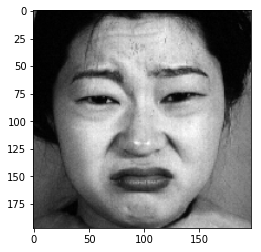

In [24]:
X_train = resize(norm_train_images, 197)
X_test = resize(norm_test_images, 197)
X_train = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_train]
X_test = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_test]

print(X_train[0].shape)
print(X_test[0].shape)
plt.imshow(X_train[0])

In [25]:
# Conver to 4D tensors
X_train = convert_to_tensors(X_train, 3)
X_test = convert_to_tensors(X_test, 3)
print(X_train.shape)

(498, 197, 197, 3)


In [26]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = Sequential()

ResNet50_model.add(ResNet50(include_top = False, weights = 'imagenet', input_shape=(X_train.shape[1], X_train.shape[2], 3)))
ResNet50_model.add(GlobalAveragePooling2D())
ResNet50_model.add(Dense(7, activation = 'softmax'))
ResNet50_model.layers[0].trainable = False


C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [27]:
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 14,343
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
ResNet50_model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
print(type(Y_train_jaffe))

<class 'numpy.ndarray'>


In [30]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet50_model.fit(X_train, Y_train_jaffe, 
          validation_split = 0.33,
          epochs=40, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 333 samples, validate on 165 samples
Epoch 1/40
333/333 [==============================] - 6s 17ms/step - loss: 2.0265 - acc: 0.1982 - val_loss: 2.0100 - val_acc: 0.1333

Epoch 00001: val_loss improved from inf to 2.01004, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 2/40
333/333 [==============================] - 2s 7ms/step - loss: 1.5337 - acc: 0.4474 - val_loss: 2.1818 - val_acc: 0.1273

Epoch 00002: val_loss did not improve from 2.01004
Epoch 3/40
333/333 [==============================] - 2s 7ms/step - loss: 1.3032 - acc: 0.5375 - val_loss: 2.1175 - val_acc: 0.1273

Epoch 00003: val_loss did not improve from 2.01004
Epoch 4/40
333/333 [==============================] - 2s 7ms/step - loss: 1.1394 - acc: 0.6396 - val_loss: 2.3529 - val_acc: 0.1273

Epoch 00004: val_loss did not improve from 2.01004
Epoch 5/40
333/333 [==============================] - 2s 7ms/step - loss: 0.9948 - acc: 0.7177 - val_loss: 2.3392 - val_acc: 0.1273

Epoch 00005: val_loss did n

In [31]:
ResNet_predicitons = [np.argmax(ResNet50_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(Y_test, axis = 1)
test_accuracy = (100* np.sum(ResNet_predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 7.0000%


# Cohn-Kanade Model


# Pre-processing

Import the cohn-kanade dataset, the cohn-kanade dataset consists of a sequence of frames for each subject for each emotion where the last frame shows the extreme features of that emotion. The frames start at neutral condition and starts to develop into the label emotion. unfortunately not all the images are labeled, The code below is used to import the cohn-kanade dataset and the labels excluding frames that contain neutral reactions. 

In [32]:
import glob

from keras.utils.np_utils import to_categorical
import pathlib
from PIL import Image

images = []
cohn_labels = []
for file in glob.glob('cohn-kanade/cohn-kanade-labels/*/**/*.txt'):
    label = float(open(file, 'r').read()) - 2
    image_path = file.replace("_emotion.txt", ".png").replace("cohn-kanade/cohn-kanade-labels",
                                                          "cohn-kanade/cohn-kanade-images")
    image_path_data = image_path.split("_")
    final_frame_index = int(image_path_data[-1].replace(".png", ""))
    for index in range(final_frame_index // 2, final_frame_index + 1):
        dir = '_'.join(image_path_data[:-1] + ['%08d' % index + '.png'])
        if pathlib.Path(dir).is_file():
            images.append(dir)
            cohn_labels.append(label)

cohn_labels = to_categorical(cohn_labels, len(set(cohn_labels)))
label_titles = ["Angry", "Disgust", "Fear", "Happy", "Sadness", "Surprise", "Contempt"]
cohn_images = []
for path in images:
    im = Image.open(path)
    cohn_images.append(im)
    


### Train-Test split

In [33]:
from sklearn.model_selection import train_test_split
from preprocessing import cohn_count

X_train, X_test, Y_train, Y_test = train_test_split(cohn_images, cohn_labels, test_size = 0.25,
                                                    random_state = 42, shuffle = True)
print("\rThe Train dataset consists of {} images".format(len(X_train)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_train)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))

print("The Test dataset consists of {} images".format(len(X_test)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_test)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))

The Train dataset consists of 2508 images
num_angry = 106, num_happy = 554, num_sad = 230, num_surprised = 574, num_disgust = 378, num_fear = 234, num_contempt = 432
The Test dataset consists of 836 images
num_angry = 36, num_happy = 201, num_sad = 76, num_surprised = 191, num_disgust = 129, num_fear = 69, num_contempt = 134


### Augmentation


In [34]:
from preprocessing import cohn_augment
#augment training dataset
X_train, Y_train = cohn_augment(X_train, Y_train, desired_size = 5000)
#augment testing dataset
X_test, Y_test = cohn_augment(X_test, Y_test, desired_size = 1000)

print("\nThe Train dataset consists of {} images".format(len(X_train)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_train)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))

print("The Test dataset consists of {} images".format(len(X_test)))
num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt = cohn_count(Y_test)
print("num_angry = {}, num_happy = {}, num_sad = {}, num_surprised = {}, num_disgust = {}, num_fear = {}, num_contempt = {}"
     .format(num_angry, num_happy, num_sad, num_surprised, num_disgust, num_fear, num_contempt))


7/2492

C:\Users\peter\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


163/16492
The Train dataset consists of 5000 images
num_angry = 212, num_happy = 1101, num_sad = 441, num_surprised = 1139, num_disgust = 779, num_fear = 456, num_contempt = 872
The Test dataset consists of 1000 images
num_angry = 45, num_happy = 244, num_sad = 89, num_surprised = 228, num_disgust = 144, num_fear = 83, num_contempt = 167


### Face detection

Number of faces detected: 1


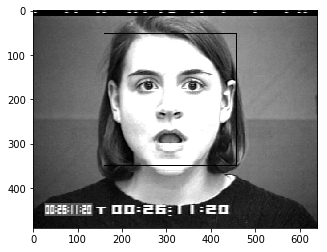

In [35]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
img = np.array(X_train[2])
faces = face_cascade.detectMultiScale(img)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,0),0)
plt.imshow(img, cmap = plt.cm.gray)

### Convert RGB images to grayscale

some of the images are RGB images to avoid dimension conflicts all images are to be changed to grayscale

In [36]:
X_train = [np.array(img) for img in X_train]
for i,img in enumerate(X_train):
    if len(img.shape) > 2:
        X_train[i] = img[:,:,0]
X_test = [np.array(img) for img in X_test]
for i,img in enumerate(X_test):
    if len(img.shape) > 2:
        X_test[i] = img[:,:,0]

### Cropping

In [37]:
from preprocessing import crop_face
#crop training images
train_images, train_labels = crop_face(X_train, Y_train)
print("\rfinal train dataset size after removing images with undetectable faces = {}".format(len(train_images)))

#crop testing images
test_images, test_labels = crop_face(X_test, Y_test)
print("\rfinal test dataset size after removing images with undetectable faces = {}".format(len(test_images)))

final train dataset size after removing images with undetectable faces = 4968
final test dataset size after removing images with undetectable faces = 993


In [38]:
#resize all images to largest cropped image size
from preprocessing import resize
final_size = 197 #final size of images
train_images = resize(train_images, final_size)
test_images = resize(test_images, final_size)
print("The final image dataset has a dimensions of {}".format(train_images[0].size))

The final image dataset has a dimensions of (197, 197)


[0. 1. 0. 0. 0. 0. 0.]


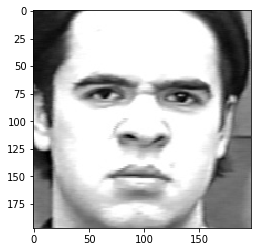

In [39]:
plt.imshow(train_images[10], cmap = plt.cm.gray)
print(train_labels[10])

### Normalization

In [40]:
from preprocessing import normalize

norm_train_images = [normalize(train_images[i]) for i in range(len(train_images))]
print(norm_train_images[0])

norm_test_images = [normalize(test_images[i]) for i in range(len(test_images))]

[[0.37254902 0.37254902 0.37254902 ... 0.48235294 0.47843137 0.48235294]
 [0.37647059 0.37647059 0.37647059 ... 0.48627451 0.49019608 0.49019608]
 [0.37254902 0.37647059 0.38039216 ... 0.48627451 0.49019608 0.48627451]
 ...
 [0.2627451  0.2627451  0.2627451  ... 0.35686275 0.34901961 0.34901961]
 [0.2627451  0.2627451  0.2627451  ... 0.35686275 0.35294118 0.35686275]
 [0.25490196 0.25882353 0.2627451  ... 0.35294118 0.34901961 0.35686275]]


### Convert to 4D tensors

In [41]:
X_train = convert_to_tensors(norm_train_images, 1)
X_test = convert_to_tensors(norm_test_images, 1)
Y_train = train_labels
Y_test = test_labels
print(X_train.shape)
print(X_test.shape)

(4968, 197, 197, 1)
(993, 197, 197, 1)


# Training

Train to model created above on the cohn-kanade dataset

In [42]:
import random
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint, EarlyStopping, History


if(train_flag == True):
    #select how many random hyperparameters selection iterations
    n_iterations = 5
    #initlaize global min_val_loss
    global_min_val_loss = np.inf
    for i in range(n_iterations):
        print('\r{}/{}'. format(i, n_iterations))
        #initilaize random hyperparameters
        random_parameters = {K: random.sample(V, 1)[0] for K, V in parameters_grid.items()}
        #create model with random hyperparameters
        model = create_model(random_parameters)
        opt = create_RMSprop_optimizer(random_parameters)
        #compile model
        model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=['accuracy'])
        #train model
        epochs = 1000
        checkpointer = ModelCheckpoint(filepath='saved_models/model_weights.hdf5', verbose=1, save_best_only=True)
        early_stopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50)
        history = model.fit(X_train, Y_train,
                  callbacks = [checkpointer, early_stopping],
                  validation_split = 0.33,
                  epochs=epochs, batch_size = 20, verbose=1)
        #compare current min validation loss with global min validation loss
        current_min_val_loss = np.min(history.history['val_loss'])
        if(current_min_val_loss < global_min_val_loss):
            global_min_val_loss = current_min_val_loss
            #save the best model so far
            model.load_weights('saved_models/model_weights.hdf5')
            model.save('saved_models/cohn_model.h5')
            print('saving new best model, val_loss = {}'.format(current_min_val_loss))
            #save best hyperparameters
            best_hyperparameters = random_parameters

0/5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 197, 197, 16)      160       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 98, 98, 16)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 98, 98, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 98, 98, 32)        4640      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 49, 49, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 49, 49, 64)        18496     
______

3328/3328 [==============================] - 6s 2ms/step - loss: 1.4601 - acc: 0.4408 - val_loss: 1.4304 - val_acc: 0.4415

Epoch 00031: val_loss did not improve from 1.42647
Epoch 32/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.4492 - acc: 0.4528 - val_loss: 1.5954 - val_acc: 0.3689

Epoch 00032: val_loss did not improve from 1.42647
Epoch 33/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.4380 - acc: 0.4489 - val_loss: 1.4792 - val_acc: 0.4140

Epoch 00033: val_loss did not improve from 1.42647
Epoch 34/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.4234 - acc: 0.4594 - val_loss: 1.5189 - val_acc: 0.4213

Epoch 00034: val_loss did not improve from 1.42647
Epoch 35/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.4160 - acc: 0.4645 - val_loss: 1.4247 - val_acc: 0.4421

Epoch 00035: val_loss improved from 1.42647 to 1.42469, saving model to saved_models/model_weights.hdf5
Epoch 36/1000
33

3328/3328 [==============================] - 6s 2ms/step - loss: 1.0622 - acc: 0.6091 - val_loss: 1.0718 - val_acc: 0.6323

Epoch 00071: val_loss did not improve from 1.06380
Epoch 72/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.0613 - acc: 0.6133 - val_loss: 1.1203 - val_acc: 0.6018

Epoch 00072: val_loss did not improve from 1.06380
Epoch 73/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.0506 - acc: 0.6139 - val_loss: 1.0097 - val_acc: 0.6530

Epoch 00073: val_loss improved from 1.06380 to 1.00969, saving model to saved_models/model_weights.hdf5
Epoch 74/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.0438 - acc: 0.6211 - val_loss: 1.2099 - val_acc: 0.5707

Epoch 00074: val_loss did not improve from 1.00969
Epoch 75/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 1.0218 - acc: 0.6208 - val_loss: 1.0143 - val_acc: 0.6329

Epoch 00075: val_loss did not improve from 1.00969
Epoch 76/1000
33

3328/3328 [==============================] - 6s 2ms/step - loss: 0.8122 - acc: 0.7151 - val_loss: 0.8152 - val_acc: 0.7104

Epoch 00112: val_loss did not improve from 0.79774
Epoch 113/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.8016 - acc: 0.7103 - val_loss: 1.0265 - val_acc: 0.6061

Epoch 00113: val_loss did not improve from 0.79774
Epoch 114/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.7910 - acc: 0.7181 - val_loss: 0.8326 - val_acc: 0.7079

Epoch 00114: val_loss did not improve from 0.79774
Epoch 115/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.7959 - acc: 0.7194 - val_loss: 1.0629 - val_acc: 0.6518

Epoch 00115: val_loss did not improve from 0.79774
Epoch 116/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.7878 - acc: 0.7184 - val_loss: 1.0158 - val_acc: 0.6287

Epoch 00116: val_loss did not improve from 0.79774
Epoch 117/1000
3328/3328 [==============================] - 6s 2m

3328/3328 [==============================] - 6s 2ms/step - loss: 0.5926 - acc: 0.7948 - val_loss: 0.6057 - val_acc: 0.7860

Epoch 00153: val_loss improved from 0.61819 to 0.60565, saving model to saved_models/model_weights.hdf5
Epoch 154/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.6126 - acc: 0.7816 - val_loss: 0.6409 - val_acc: 0.7659

Epoch 00154: val_loss did not improve from 0.60565
Epoch 155/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.5773 - acc: 0.7948 - val_loss: 0.6736 - val_acc: 0.7787

Epoch 00155: val_loss did not improve from 0.60565
Epoch 156/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.5861 - acc: 0.8020 - val_loss: 0.7349 - val_acc: 0.7287

Epoch 00156: val_loss did not improve from 0.60565
Epoch 157/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.5824 - acc: 0.7945 - val_loss: 0.5903 - val_acc: 0.8140

Epoch 00157: val_loss improved from 0.60565 to 0.59029, saving 

3328/3328 [==============================] - 6s 2ms/step - loss: 0.4452 - acc: 0.8453 - val_loss: 0.5832 - val_acc: 0.7872

Epoch 00194: val_loss did not improve from 0.46613
Epoch 195/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.4411 - acc: 0.8480 - val_loss: 0.7466 - val_acc: 0.7482

Epoch 00195: val_loss did not improve from 0.46613
Epoch 196/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.4444 - acc: 0.8519 - val_loss: 0.4965 - val_acc: 0.8299

Epoch 00196: val_loss did not improve from 0.46613
Epoch 197/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.4191 - acc: 0.8558 - val_loss: 0.4339 - val_acc: 0.8500

Epoch 00197: val_loss improved from 0.46613 to 0.43386, saving model to saved_models/model_weights.hdf5
Epoch 198/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.4326 - acc: 0.8537 - val_loss: 0.4480 - val_acc: 0.8610

Epoch 00198: val_loss did not improve from 0.43386
Epoch 199/10


Epoch 00235: val_loss did not improve from 0.33851
Epoch 236/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.3213 - acc: 0.8930 - val_loss: 0.3685 - val_acc: 0.8848

Epoch 00236: val_loss did not improve from 0.33851
Epoch 237/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.3366 - acc: 0.8816 - val_loss: 0.5531 - val_acc: 0.7951

Epoch 00237: val_loss did not improve from 0.33851
Epoch 238/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.3241 - acc: 0.8897 - val_loss: 0.4641 - val_acc: 0.8476

Epoch 00238: val_loss did not improve from 0.33851
Epoch 239/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.3244 - acc: 0.8870 - val_loss: 0.3440 - val_acc: 0.8823

Epoch 00239: val_loss did not improve from 0.33851
Epoch 240/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.3243 - acc: 0.8903 - val_loss: 0.8042 - val_acc: 0.7524

Epoch 00240: val_loss did not improve from 0.3385

3328/3328 [==============================] - 6s 2ms/step - loss: 0.2703 - acc: 0.9062 - val_loss: 0.3234 - val_acc: 0.8963

Epoch 00278: val_loss did not improve from 0.25176
Epoch 279/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2450 - acc: 0.9141 - val_loss: 0.6733 - val_acc: 0.7524

Epoch 00279: val_loss did not improve from 0.25176
Epoch 280/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2531 - acc: 0.9189 - val_loss: 0.3265 - val_acc: 0.8848

Epoch 00280: val_loss did not improve from 0.25176
Epoch 281/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2494 - acc: 0.9141 - val_loss: 0.3246 - val_acc: 0.8896

Epoch 00281: val_loss did not improve from 0.25176
Epoch 282/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2525 - acc: 0.9171 - val_loss: 0.2752 - val_acc: 0.9055

Epoch 00282: val_loss did not improve from 0.25176
Epoch 283/1000
3328/3328 [==============================] - 6s 2m

3328/3328 [==============================] - 6s 2ms/step - loss: 0.2041 - acc: 0.9330 - val_loss: 0.4222 - val_acc: 0.8354

Epoch 00320: val_loss did not improve from 0.20120
Epoch 321/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1977 - acc: 0.9336 - val_loss: 0.2042 - val_acc: 0.9311

Epoch 00321: val_loss did not improve from 0.20120
Epoch 322/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2073 - acc: 0.9306 - val_loss: 0.2699 - val_acc: 0.9195

Epoch 00322: val_loss did not improve from 0.20120
Epoch 323/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2034 - acc: 0.9291 - val_loss: 0.2403 - val_acc: 0.9238

Epoch 00323: val_loss did not improve from 0.20120
Epoch 324/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.2068 - acc: 0.9282 - val_loss: 0.4370 - val_acc: 0.8646

Epoch 00324: val_loss did not improve from 0.20120
Epoch 325/1000
3328/3328 [==============================] - 6s 2m

3328/3328 [==============================] - 6s 2ms/step - loss: 0.1730 - acc: 0.9429 - val_loss: 0.2082 - val_acc: 0.9421

Epoch 00362: val_loss did not improve from 0.17303
Epoch 363/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1717 - acc: 0.9420 - val_loss: 0.2502 - val_acc: 0.9195

Epoch 00363: val_loss did not improve from 0.17303
Epoch 364/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1762 - acc: 0.9444 - val_loss: 0.1730 - val_acc: 0.9402

Epoch 00364: val_loss improved from 0.17303 to 0.17295, saving model to saved_models/model_weights.hdf5
Epoch 365/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1725 - acc: 0.9432 - val_loss: 0.2375 - val_acc: 0.9329

Epoch 00365: val_loss did not improve from 0.17295
Epoch 366/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1681 - acc: 0.9423 - val_loss: 0.1719 - val_acc: 0.9427

Epoch 00366: val_loss improved from 0.17295 to 0.17194, saving 

3328/3328 [==============================] - 6s 2ms/step - loss: 0.1385 - acc: 0.9567 - val_loss: 0.5160 - val_acc: 0.8317

Epoch 00404: val_loss did not improve from 0.15951
Epoch 405/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1446 - acc: 0.9516 - val_loss: 0.1402 - val_acc: 0.9518

Epoch 00405: val_loss improved from 0.15951 to 0.14019, saving model to saved_models/model_weights.hdf5
Epoch 406/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1443 - acc: 0.9498 - val_loss: 0.2253 - val_acc: 0.9299

Epoch 00406: val_loss did not improve from 0.14019
Epoch 407/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1386 - acc: 0.9522 - val_loss: 0.1983 - val_acc: 0.9402

Epoch 00407: val_loss did not improve from 0.14019
Epoch 408/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1379 - acc: 0.9525 - val_loss: 0.1745 - val_acc: 0.9415

Epoch 00408: val_loss did not improve from 0.14019
Epoch 409/10

3328/3328 [==============================] - 6s 2ms/step - loss: 0.1107 - acc: 0.9627 - val_loss: 0.1788 - val_acc: 0.9488

Epoch 00447: val_loss did not improve from 0.14019
Epoch 448/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1259 - acc: 0.9591 - val_loss: 0.3564 - val_acc: 0.8720

Epoch 00448: val_loss did not improve from 0.14019
Epoch 449/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1183 - acc: 0.9591 - val_loss: 0.1510 - val_acc: 0.9573

Epoch 00449: val_loss did not improve from 0.14019
Epoch 450/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1243 - acc: 0.9573 - val_loss: 0.1587 - val_acc: 0.9433

Epoch 00450: val_loss did not improve from 0.14019
Epoch 451/1000
3328/3328 [==============================] - 6s 2ms/step - loss: 0.1232 - acc: 0.9615 - val_loss: 0.1431 - val_acc: 0.9488

Epoch 00451: val_loss did not improve from 0.14019
Epoch 452/1000
3328/3328 [==============================] - 6s 2m

3328/3328 [==============================] - 10s 3ms/step - loss: 1.3013 - acc: 0.5123 - val_loss: 1.2721 - val_acc: 0.5085

Epoch 00022: val_loss improved from 1.27606 to 1.27209, saving model to saved_models/model_weights.hdf5
Epoch 23/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 1.2785 - acc: 0.5276 - val_loss: 1.4274 - val_acc: 0.4762

Epoch 00023: val_loss did not improve from 1.27209
Epoch 24/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 1.2553 - acc: 0.5325 - val_loss: 1.2483 - val_acc: 0.5055

Epoch 00024: val_loss improved from 1.27209 to 1.24825, saving model to saved_models/model_weights.hdf5
Epoch 25/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 1.2403 - acc: 0.5355 - val_loss: 1.2625 - val_acc: 0.5244

Epoch 00025: val_loss did not improve from 1.24825
Epoch 26/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 1.2036 - acc: 0.5457 - val_loss: 1.4763 - val_acc: 0.4506

Epoch 000

3328/3328 [==============================] - 10s 3ms/step - loss: 0.5791 - acc: 0.8017 - val_loss: 0.6915 - val_acc: 0.7476

Epoch 00061: val_loss did not improve from 0.62157
Epoch 62/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.5746 - acc: 0.7966 - val_loss: 0.8170 - val_acc: 0.6957

Epoch 00062: val_loss did not improve from 0.62157
Epoch 63/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.5563 - acc: 0.8089 - val_loss: 0.5633 - val_acc: 0.8104

Epoch 00063: val_loss improved from 0.62157 to 0.56330, saving model to saved_models/model_weights.hdf5
Epoch 64/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.5518 - acc: 0.8161 - val_loss: 0.5865 - val_acc: 0.7945

Epoch 00064: val_loss did not improve from 0.56330
Epoch 65/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.5431 - acc: 0.8194 - val_loss: 0.9265 - val_acc: 0.6280

Epoch 00065: val_loss did not improve from 0.56330
Epoch 66/10

3328/3328 [==============================] - 10s 3ms/step - loss: 0.2829 - acc: 0.9078 - val_loss: 0.4316 - val_acc: 0.8640

Epoch 00102: val_loss did not improve from 0.31960
Epoch 103/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.2778 - acc: 0.9078 - val_loss: 0.7848 - val_acc: 0.7402

Epoch 00103: val_loss did not improve from 0.31960
Epoch 104/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.2733 - acc: 0.9087 - val_loss: 0.5834 - val_acc: 0.7805

Epoch 00104: val_loss did not improve from 0.31960
Epoch 105/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.2657 - acc: 0.9147 - val_loss: 0.2665 - val_acc: 0.9134

Epoch 00105: val_loss improved from 0.31960 to 0.26647, saving model to saved_models/model_weights.hdf5
Epoch 106/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.2744 - acc: 0.9120 - val_loss: 0.4059 - val_acc: 0.8610

Epoch 00106: val_loss did not improve from 0.26647
Epoch 1


Epoch 00143: val_loss did not improve from 0.17934
Epoch 144/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.1564 - acc: 0.9498 - val_loss: 0.2031 - val_acc: 0.9293

Epoch 00144: val_loss did not improve from 0.17934
Epoch 145/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.1620 - acc: 0.9483 - val_loss: 0.5463 - val_acc: 0.8305

Epoch 00145: val_loss did not improve from 0.17934
Epoch 146/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.1467 - acc: 0.9540 - val_loss: 0.1705 - val_acc: 0.9482

Epoch 00146: val_loss improved from 0.17934 to 0.17048, saving model to saved_models/model_weights.hdf5
Epoch 147/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.1511 - acc: 0.9531 - val_loss: 0.2024 - val_acc: 0.9341

Epoch 00147: val_loss did not improve from 0.17048
Epoch 148/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.1543 - acc: 0.9492 - val_loss: 0.1709 - val_acc:

3328/3328 [==============================] - 10s 3ms/step - loss: 0.1063 - acc: 0.9639 - val_loss: 0.1407 - val_acc: 0.9549

Epoch 00185: val_loss did not improve from 0.12189
Epoch 186/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0999 - acc: 0.9657 - val_loss: 0.3460 - val_acc: 0.9006

Epoch 00186: val_loss did not improve from 0.12189
Epoch 187/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0981 - acc: 0.9691 - val_loss: 0.4522 - val_acc: 0.8701

Epoch 00187: val_loss did not improve from 0.12189
Epoch 188/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.1002 - acc: 0.9691 - val_loss: 0.1411 - val_acc: 0.9549

Epoch 00188: val_loss did not improve from 0.12189
Epoch 189/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0912 - acc: 0.9715 - val_loss: 0.1239 - val_acc: 0.9579

Epoch 00189: val_loss did not improve from 0.12189
Epoch 190/1000
3328/3328 [==============================] - 

3328/3328 [==============================] - 10s 3ms/step - loss: 0.0671 - acc: 0.9775 - val_loss: 0.6155 - val_acc: 0.8360

Epoch 00227: val_loss did not improve from 0.09627
Epoch 228/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0725 - acc: 0.9787 - val_loss: 0.1921 - val_acc: 0.9317

Epoch 00228: val_loss did not improve from 0.09627
Epoch 229/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0713 - acc: 0.9763 - val_loss: 0.1142 - val_acc: 0.9665

Epoch 00229: val_loss did not improve from 0.09627
Epoch 230/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0695 - acc: 0.9775 - val_loss: 0.1905 - val_acc: 0.9402

Epoch 00230: val_loss did not improve from 0.09627
Epoch 231/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0661 - acc: 0.9778 - val_loss: 0.1237 - val_acc: 0.9585

Epoch 00231: val_loss did not improve from 0.09627
Epoch 232/1000
3328/3328 [==============================] - 

3328/3328 [==============================] - 10s 3ms/step - loss: 0.0543 - acc: 0.9823 - val_loss: 0.1074 - val_acc: 0.9677

Epoch 00269: val_loss did not improve from 0.08418
Epoch 270/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0487 - acc: 0.9859 - val_loss: 0.0995 - val_acc: 0.9646

Epoch 00270: val_loss did not improve from 0.08418
Epoch 271/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0436 - acc: 0.9856 - val_loss: 0.0737 - val_acc: 0.9805

Epoch 00271: val_loss improved from 0.08418 to 0.07368, saving model to saved_models/model_weights.hdf5
Epoch 272/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0501 - acc: 0.9841 - val_loss: 0.2062 - val_acc: 0.9360

Epoch 00272: val_loss did not improve from 0.07368
Epoch 273/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0440 - acc: 0.9862 - val_loss: 0.1004 - val_acc: 0.9677

Epoch 00273: val_loss did not improve from 0.07368
Epoch 2

3328/3328 [==============================] - 10s 3ms/step - loss: 0.0507 - acc: 0.9850 - val_loss: 0.0945 - val_acc: 0.9744

Epoch 00311: val_loss did not improve from 0.06851
Epoch 312/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0359 - acc: 0.9886 - val_loss: 0.0966 - val_acc: 0.9707

Epoch 00312: val_loss did not improve from 0.06851
Epoch 313/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0423 - acc: 0.9880 - val_loss: 0.0899 - val_acc: 0.9750

Epoch 00313: val_loss did not improve from 0.06851
Epoch 314/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0419 - acc: 0.9862 - val_loss: 0.0995 - val_acc: 0.9713

Epoch 00314: val_loss did not improve from 0.06851
Epoch 315/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0321 - acc: 0.9895 - val_loss: 0.0733 - val_acc: 0.9799

Epoch 00315: val_loss did not improve from 0.06851
Epoch 316/1000
3328/3328 [==============================] - 

3328/3328 [==============================] - 10s 3ms/step - loss: 0.0348 - acc: 0.9877 - val_loss: 0.0780 - val_acc: 0.9768

Epoch 00353: val_loss did not improve from 0.05976
Epoch 354/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0315 - acc: 0.9886 - val_loss: 0.1022 - val_acc: 0.9720

Epoch 00354: val_loss did not improve from 0.05976
Epoch 355/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0312 - acc: 0.9886 - val_loss: 0.2913 - val_acc: 0.9207

Epoch 00355: val_loss did not improve from 0.05976
Epoch 356/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0310 - acc: 0.9886 - val_loss: 0.1011 - val_acc: 0.9701

Epoch 00356: val_loss did not improve from 0.05976
Epoch 357/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0292 - acc: 0.9895 - val_loss: 0.0805 - val_acc: 0.9762

Epoch 00357: val_loss did not improve from 0.05976
Epoch 358/1000
3328/3328 [==============================] - 


Epoch 00395: val_loss did not improve from 0.05875
Epoch 396/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0264 - acc: 0.9931 - val_loss: 0.1605 - val_acc: 0.9573

Epoch 00396: val_loss did not improve from 0.05875
Epoch 397/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0302 - acc: 0.9916 - val_loss: 0.0648 - val_acc: 0.9823

Epoch 00397: val_loss did not improve from 0.05875
Epoch 398/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0199 - acc: 0.9934 - val_loss: 0.3991 - val_acc: 0.9146

Epoch 00398: val_loss did not improve from 0.05875
Epoch 399/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0247 - acc: 0.9904 - val_loss: 0.0919 - val_acc: 0.9756

Epoch 00399: val_loss did not improve from 0.05875
Epoch 400/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 0.0208 - acc: 0.9925 - val_loss: 0.1317 - val_acc: 0.9616

Epoch 00400: val_loss did not improve from 0

Train on 3328 samples, validate on 1640 samples
Epoch 1/1000
3328/3328 [==============================] - 9s 3ms/step - loss: 1.8436 - acc: 0.2209 - val_loss: 1.8395 - val_acc: 0.2305

Epoch 00001: val_loss improved from inf to 1.83948, saving model to saved_models/model_weights.hdf5
Epoch 2/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.8155 - acc: 0.2290 - val_loss: 1.8357 - val_acc: 0.2177

Epoch 00002: val_loss improved from 1.83948 to 1.83565, saving model to saved_models/model_weights.hdf5
Epoch 3/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.8067 - acc: 0.2320 - val_loss: 1.8057 - val_acc: 0.2226

Epoch 00003: val_loss improved from 1.83565 to 1.80571, saving model to saved_models/model_weights.hdf5
Epoch 4/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.8013 - acc: 0.2257 - val_loss: 1.8019 - val_acc: 0.2274

Epoch 00004: val_loss improved from 1.80571 to 1.80193, saving model to saved_models/model_weigh


Epoch 00038: val_loss improved from 1.27604 to 1.16513, saving model to saved_models/model_weights.hdf5
Epoch 39/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.1823 - acc: 0.5634 - val_loss: 1.2006 - val_acc: 0.5701

Epoch 00039: val_loss did not improve from 1.16513
Epoch 40/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.1544 - acc: 0.5736 - val_loss: 1.1639 - val_acc: 0.5360

Epoch 00040: val_loss improved from 1.16513 to 1.16392, saving model to saved_models/model_weights.hdf5
Epoch 41/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.1367 - acc: 0.5769 - val_loss: 1.1447 - val_acc: 0.5756

Epoch 00041: val_loss improved from 1.16392 to 1.14474, saving model to saved_models/model_weights.hdf5
Epoch 42/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.1108 - acc: 0.5919 - val_loss: 1.0763 - val_acc: 0.6159

Epoch 00042: val_loss improved from 1.14474 to 1.07631, saving model to saved_models


Epoch 00078: val_loss did not improve from 0.57480
Epoch 79/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.5774 - acc: 0.7996 - val_loss: 0.9638 - val_acc: 0.6543

Epoch 00079: val_loss did not improve from 0.57480
Epoch 80/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.5708 - acc: 0.8047 - val_loss: 0.6872 - val_acc: 0.7476

Epoch 00080: val_loss did not improve from 0.57480
Epoch 81/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.5717 - acc: 0.8053 - val_loss: 0.6162 - val_acc: 0.8030

Epoch 00081: val_loss did not improve from 0.57480
Epoch 82/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.5611 - acc: 0.8068 - val_loss: 0.8819 - val_acc: 0.6768

Epoch 00082: val_loss did not improve from 0.57480
Epoch 83/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.5446 - acc: 0.8104 - val_loss: 0.7716 - val_acc: 0.7043

Epoch 00083: val_loss did not improve from 0.57480
Epo

3328/3328 [==============================] - 7s 2ms/step - loss: 0.3074 - acc: 0.8987 - val_loss: 1.1490 - val_acc: 0.6159

Epoch 00120: val_loss did not improve from 0.29065
Epoch 121/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.3148 - acc: 0.8909 - val_loss: 0.3241 - val_acc: 0.8799

Epoch 00121: val_loss did not improve from 0.29065
Epoch 122/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.3008 - acc: 0.9020 - val_loss: 0.3787 - val_acc: 0.8732

Epoch 00122: val_loss did not improve from 0.29065
Epoch 123/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.2971 - acc: 0.8975 - val_loss: 0.6588 - val_acc: 0.7512

Epoch 00123: val_loss did not improve from 0.29065
Epoch 124/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.2915 - acc: 0.8996 - val_loss: 0.4655 - val_acc: 0.8293

Epoch 00124: val_loss did not improve from 0.29065
Epoch 125/1000
3328/3328 [==============================] - 7s 2m


Epoch 00161: val_loss improved from 0.17673 to 0.17542, saving model to saved_models/model_weights.hdf5
Epoch 162/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1748 - acc: 0.9399 - val_loss: 0.6023 - val_acc: 0.7774

Epoch 00162: val_loss did not improve from 0.17542
Epoch 163/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1739 - acc: 0.9384 - val_loss: 0.2495 - val_acc: 0.9226

Epoch 00163: val_loss did not improve from 0.17542
Epoch 164/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1808 - acc: 0.9381 - val_loss: 0.1476 - val_acc: 0.9549

Epoch 00164: val_loss improved from 0.17542 to 0.14756, saving model to saved_models/model_weights.hdf5
Epoch 165/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1766 - acc: 0.9360 - val_loss: 0.2205 - val_acc: 0.9256

Epoch 00165: val_loss did not improve from 0.14756
Epoch 166/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.

3328/3328 [==============================] - 7s 2ms/step - loss: 0.1145 - acc: 0.9624 - val_loss: 0.3843 - val_acc: 0.8835

Epoch 00203: val_loss did not improve from 0.11427
Epoch 204/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1153 - acc: 0.9651 - val_loss: 0.1682 - val_acc: 0.9451

Epoch 00204: val_loss did not improve from 0.11427
Epoch 205/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1166 - acc: 0.9597 - val_loss: 0.2412 - val_acc: 0.9183

Epoch 00205: val_loss did not improve from 0.11427
Epoch 206/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1118 - acc: 0.9606 - val_loss: 0.1750 - val_acc: 0.9409

Epoch 00206: val_loss did not improve from 0.11427
Epoch 207/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1098 - acc: 0.9639 - val_loss: 0.1061 - val_acc: 0.9665

Epoch 00207: val_loss improved from 0.11427 to 0.10615, saving model to saved_models/model_weights.hdf5
Epoch 208/10

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0702 - acc: 0.9781 - val_loss: 0.0872 - val_acc: 0.9726

Epoch 00245: val_loss did not improve from 0.08670
Epoch 246/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0782 - acc: 0.9748 - val_loss: 0.4770 - val_acc: 0.8799

Epoch 00246: val_loss did not improve from 0.08670
Epoch 247/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0815 - acc: 0.9748 - val_loss: 0.1282 - val_acc: 0.9585

Epoch 00247: val_loss did not improve from 0.08670
Epoch 248/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0718 - acc: 0.9781 - val_loss: 0.0848 - val_acc: 0.9762

Epoch 00248: val_loss improved from 0.08670 to 0.08476, saving model to saved_models/model_weights.hdf5
Epoch 249/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0745 - acc: 0.9730 - val_loss: 0.4485 - val_acc: 0.8756

Epoch 00249: val_loss did not improve from 0.08476
Epoch 250/10

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0553 - acc: 0.9811 - val_loss: 0.0813 - val_acc: 0.9750

Epoch 00287: val_loss did not improve from 0.06764
Epoch 288/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0641 - acc: 0.9805 - val_loss: 0.0631 - val_acc: 0.9817

Epoch 00288: val_loss improved from 0.06764 to 0.06307, saving model to saved_models/model_weights.hdf5
Epoch 289/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0543 - acc: 0.9826 - val_loss: 0.0885 - val_acc: 0.9738

Epoch 00289: val_loss did not improve from 0.06307
Epoch 290/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0532 - acc: 0.9841 - val_loss: 0.1042 - val_acc: 0.9622

Epoch 00290: val_loss did not improve from 0.06307
Epoch 291/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0625 - acc: 0.9799 - val_loss: 0.1165 - val_acc: 0.9640

Epoch 00291: val_loss did not improve from 0.06307
Epoch 292/10

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0505 - acc: 0.9835 - val_loss: 0.0954 - val_acc: 0.9732

Epoch 00329: val_loss did not improve from 0.05573
Epoch 330/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0485 - acc: 0.9841 - val_loss: 0.2309 - val_acc: 0.9262

Epoch 00330: val_loss did not improve from 0.05573
Epoch 331/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0510 - acc: 0.9844 - val_loss: 0.0698 - val_acc: 0.9805

Epoch 00331: val_loss did not improve from 0.05573
Epoch 332/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0527 - acc: 0.9835 - val_loss: 0.0808 - val_acc: 0.9750

Epoch 00332: val_loss did not improve from 0.05573
Epoch 333/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0473 - acc: 0.9841 - val_loss: 0.0677 - val_acc: 0.9793

Epoch 00333: val_loss did not improve from 0.05573
Epoch 334/1000
3328/3328 [==============================] - 7s 2m

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0409 - acc: 0.9856 - val_loss: 0.0992 - val_acc: 0.9701

Epoch 00372: val_loss did not improve from 0.05303
Epoch 373/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0415 - acc: 0.9892 - val_loss: 0.0503 - val_acc: 0.9841

Epoch 00373: val_loss improved from 0.05303 to 0.05032, saving model to saved_models/model_weights.hdf5
Epoch 374/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0282 - acc: 0.9919 - val_loss: 0.0750 - val_acc: 0.9762

Epoch 00374: val_loss did not improve from 0.05032
Epoch 375/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0466 - acc: 0.9847 - val_loss: 0.2478 - val_acc: 0.9262

Epoch 00375: val_loss did not improve from 0.05032
Epoch 376/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0352 - acc: 0.9886 - val_loss: 0.0632 - val_acc: 0.9835

Epoch 00376: val_loss did not improve from 0.05032
Epoch 377/10


Epoch 00414: val_loss did not improve from 0.04853
Epoch 415/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0350 - acc: 0.9898 - val_loss: 0.0889 - val_acc: 0.9738

Epoch 00415: val_loss did not improve from 0.04853
Epoch 416/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0357 - acc: 0.9898 - val_loss: 0.0560 - val_acc: 0.9829

Epoch 00416: val_loss did not improve from 0.04853
Epoch 417/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0360 - acc: 0.9895 - val_loss: 0.0796 - val_acc: 0.9756

Epoch 00417: val_loss did not improve from 0.04853
Epoch 418/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0260 - acc: 0.9916 - val_loss: 0.0844 - val_acc: 0.9805

Epoch 00418: val_loss did not improve from 0.04853
Epoch 419/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0316 - acc: 0.9901 - val_loss: 0.0656 - val_acc: 0.9817

Epoch 00419: val_loss did not improve from 0.0485


Epoch 00457: val_loss did not improve from 0.04772
Epoch 458/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0281 - acc: 0.9922 - val_loss: 0.1029 - val_acc: 0.9768

Epoch 00458: val_loss did not improve from 0.04772
Epoch 459/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0353 - acc: 0.9862 - val_loss: 0.1050 - val_acc: 0.9701

Epoch 00459: val_loss did not improve from 0.04772
Epoch 460/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0334 - acc: 0.9892 - val_loss: 0.0872 - val_acc: 0.9738

Epoch 00460: val_loss did not improve from 0.04772
Epoch 461/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0326 - acc: 0.9895 - val_loss: 0.0679 - val_acc: 0.9780

Epoch 00461: val_loss did not improve from 0.04772
Epoch 462/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0291 - acc: 0.9907 - val_loss: 0.1029 - val_acc: 0.9738

Epoch 00462: val_loss did not improve from 0.0477

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0366 - acc: 0.9886 - val_loss: 0.1236 - val_acc: 0.9659

Epoch 00500: val_loss did not improve from 0.04525
Epoch 501/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0242 - acc: 0.9919 - val_loss: 0.0539 - val_acc: 0.9860

Epoch 00501: val_loss did not improve from 0.04525
Epoch 502/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0269 - acc: 0.9919 - val_loss: 0.0547 - val_acc: 0.9854

Epoch 00502: val_loss did not improve from 0.04525
Epoch 503/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0247 - acc: 0.9904 - val_loss: 0.0849 - val_acc: 0.9780

Epoch 00503: val_loss did not improve from 0.04525
Epoch 504/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0258 - acc: 0.9898 - val_loss: 0.0940 - val_acc: 0.9762

Epoch 00504: val_loss did not improve from 0.04525
Epoch 505/1000
3328/3328 [==============================] - 7s 2m

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0203 - acc: 0.9916 - val_loss: 0.0852 - val_acc: 0.9768

Epoch 00543: val_loss did not improve from 0.04525
Epoch 544/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0238 - acc: 0.9928 - val_loss: 0.0893 - val_acc: 0.9799

Epoch 00544: val_loss did not improve from 0.04525
Epoch 545/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0216 - acc: 0.9916 - val_loss: 0.0644 - val_acc: 0.9835

Epoch 00545: val_loss did not improve from 0.04525
Epoch 546/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0296 - acc: 0.9907 - val_loss: 0.0572 - val_acc: 0.9860

Epoch 00546: val_loss did not improve from 0.04525
Epoch 00546: early stopping
saving new best model, val_loss = 0.045246322975134076
3/5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 


Epoch 00025: val_loss improved from 1.28988 to 1.28039, saving model to saved_models/model_weights.hdf5
Epoch 26/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.2806 - acc: 0.5288 - val_loss: 1.4624 - val_acc: 0.4402

Epoch 00026: val_loss did not improve from 1.28039
Epoch 27/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.2659 - acc: 0.5322 - val_loss: 1.2713 - val_acc: 0.4988

Epoch 00027: val_loss improved from 1.28039 to 1.27134, saving model to saved_models/model_weights.hdf5
Epoch 28/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.2337 - acc: 0.5397 - val_loss: 1.1626 - val_acc: 0.5646

Epoch 00028: val_loss improved from 1.27134 to 1.16258, saving model to saved_models/model_weights.hdf5
Epoch 29/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 1.2231 - acc: 0.5463 - val_loss: 1.2131 - val_acc: 0.5396

Epoch 00029: val_loss did not improve from 1.16258
Epoch 30/1000
3328/3328 [========

3328/3328 [==============================] - 7s 2ms/step - loss: 0.6444 - acc: 0.7773 - val_loss: 0.6389 - val_acc: 0.7835

Epoch 00065: val_loss did not improve from 0.60554
Epoch 66/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.6388 - acc: 0.7785 - val_loss: 0.7039 - val_acc: 0.7622

Epoch 00066: val_loss did not improve from 0.60554
Epoch 67/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.6308 - acc: 0.7894 - val_loss: 0.7097 - val_acc: 0.7415

Epoch 00067: val_loss did not improve from 0.60554
Epoch 68/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.6117 - acc: 0.7990 - val_loss: 0.7136 - val_acc: 0.7482

Epoch 00068: val_loss did not improve from 0.60554
Epoch 69/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.6051 - acc: 0.7873 - val_loss: 0.5740 - val_acc: 0.8037

Epoch 00069: val_loss improved from 0.60554 to 0.57398, saving model to saved_models/model_weights.hdf5
Epoch 70/1000
33

3328/3328 [==============================] - 7s 2ms/step - loss: 0.3557 - acc: 0.8774 - val_loss: 0.5202 - val_acc: 0.8250

Epoch 00107: val_loss did not improve from 0.35822
Epoch 108/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.3560 - acc: 0.8810 - val_loss: 0.5255 - val_acc: 0.8250

Epoch 00108: val_loss did not improve from 0.35822
Epoch 109/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.3471 - acc: 0.8822 - val_loss: 0.3472 - val_acc: 0.8933

Epoch 00109: val_loss improved from 0.35822 to 0.34719, saving model to saved_models/model_weights.hdf5
Epoch 110/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.3399 - acc: 0.8801 - val_loss: 0.5348 - val_acc: 0.8146

Epoch 00110: val_loss did not improve from 0.34719
Epoch 111/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.3399 - acc: 0.8855 - val_loss: 0.3527 - val_acc: 0.8726

Epoch 00111: val_loss did not improve from 0.34719
Epoch 112/10

3328/3328 [==============================] - 7s 2ms/step - loss: 0.2206 - acc: 0.9273 - val_loss: 0.2651 - val_acc: 0.9140

Epoch 00148: val_loss did not improve from 0.21507
Epoch 149/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.2160 - acc: 0.9282 - val_loss: 0.5860 - val_acc: 0.7768

Epoch 00149: val_loss did not improve from 0.21507
Epoch 150/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.2079 - acc: 0.9333 - val_loss: 0.2999 - val_acc: 0.9189

Epoch 00150: val_loss did not improve from 0.21507
Epoch 151/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.2135 - acc: 0.9288 - val_loss: 0.2341 - val_acc: 0.9207

Epoch 00151: val_loss did not improve from 0.21507
Epoch 152/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.2033 - acc: 0.9327 - val_loss: 0.2355 - val_acc: 0.9341

Epoch 00152: val_loss did not improve from 0.21507
Epoch 153/1000
3328/3328 [==============================] - 7s 2m

3328/3328 [==============================] - 7s 2ms/step - loss: 0.1393 - acc: 0.9540 - val_loss: 0.1689 - val_acc: 0.9415

Epoch 00189: val_loss did not improve from 0.12909
Epoch 190/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1385 - acc: 0.9549 - val_loss: 0.1146 - val_acc: 0.9671

Epoch 00190: val_loss improved from 0.12909 to 0.11459, saving model to saved_models/model_weights.hdf5
Epoch 191/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1375 - acc: 0.9537 - val_loss: 0.3801 - val_acc: 0.8695

Epoch 00191: val_loss did not improve from 0.11459
Epoch 192/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1276 - acc: 0.9615 - val_loss: 0.6224 - val_acc: 0.7963

Epoch 00192: val_loss did not improve from 0.11459
Epoch 193/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.1336 - acc: 0.9552 - val_loss: 0.1436 - val_acc: 0.9549

Epoch 00193: val_loss did not improve from 0.11459
Epoch 194/10

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0920 - acc: 0.9718 - val_loss: 0.5399 - val_acc: 0.8287

Epoch 00231: val_loss did not improve from 0.10185
Epoch 232/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0962 - acc: 0.9700 - val_loss: 0.0908 - val_acc: 0.9707

Epoch 00232: val_loss improved from 0.10185 to 0.09077, saving model to saved_models/model_weights.hdf5
Epoch 233/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0921 - acc: 0.9666 - val_loss: 0.1098 - val_acc: 0.9585

Epoch 00233: val_loss did not improve from 0.09077
Epoch 234/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0855 - acc: 0.9691 - val_loss: 0.2793 - val_acc: 0.9043

Epoch 00234: val_loss did not improve from 0.09077
Epoch 235/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0983 - acc: 0.9657 - val_loss: 0.1466 - val_acc: 0.9482

Epoch 00235: val_loss did not improve from 0.09077
Epoch 236/10


Epoch 00273: val_loss did not improve from 0.08691
Epoch 274/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0693 - acc: 0.9790 - val_loss: 0.0812 - val_acc: 0.9768

Epoch 00274: val_loss improved from 0.08691 to 0.08121, saving model to saved_models/model_weights.hdf5
Epoch 275/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0732 - acc: 0.9775 - val_loss: 0.1944 - val_acc: 0.9262

Epoch 00275: val_loss did not improve from 0.08121
Epoch 276/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0552 - acc: 0.9817 - val_loss: 0.0736 - val_acc: 0.9713

Epoch 00276: val_loss improved from 0.08121 to 0.07362, saving model to saved_models/model_weights.hdf5
Epoch 277/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0769 - acc: 0.9742 - val_loss: 0.0958 - val_acc: 0.9695

Epoch 00277: val_loss did not improve from 0.07362
Epoch 278/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0600 - acc: 0.9805 - val_loss: 0.2077 - val_acc: 0.9317

Epoch 00315: val_loss did not improve from 0.05732
Epoch 316/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0639 - acc: 0.9802 - val_loss: 0.1186 - val_acc: 0.9610

Epoch 00316: val_loss did not improve from 0.05732
Epoch 317/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0555 - acc: 0.9820 - val_loss: 0.0580 - val_acc: 0.9841

Epoch 00317: val_loss did not improve from 0.05732
Epoch 318/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0516 - acc: 0.9832 - val_loss: 0.0703 - val_acc: 0.9780

Epoch 00318: val_loss did not improve from 0.05732
Epoch 319/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0597 - acc: 0.9799 - val_loss: 0.0934 - val_acc: 0.9689

Epoch 00319: val_loss did not improve from 0.05732
Epoch 320/1000
3328/3328 [==============================] - 7s 2m

3328/3328 [==============================] - 7s 2ms/step - loss: 0.0511 - acc: 0.9856 - val_loss: 0.0583 - val_acc: 0.9805

Epoch 00357: val_loss did not improve from 0.05038
Epoch 358/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0453 - acc: 0.9847 - val_loss: 0.0543 - val_acc: 0.9854

Epoch 00358: val_loss did not improve from 0.05038
Epoch 359/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0479 - acc: 0.9844 - val_loss: 0.2925 - val_acc: 0.9110

Epoch 00359: val_loss did not improve from 0.05038
Epoch 360/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0394 - acc: 0.9862 - val_loss: 0.0644 - val_acc: 0.9829

Epoch 00360: val_loss did not improve from 0.05038
Epoch 361/1000
3328/3328 [==============================] - 7s 2ms/step - loss: 0.0425 - acc: 0.9847 - val_loss: 0.0598 - val_acc: 0.9841

Epoch 00361: val_loss did not improve from 0.05038
Epoch 362/1000
3328/3328 [==============================] - 7s 2m

Train on 3328 samples, validate on 1640 samples
Epoch 1/1000
3328/3328 [==============================] - 10s 3ms/step - loss: 1.8413 - acc: 0.2341 - val_loss: 1.8128 - val_acc: 0.2433

Epoch 00001: val_loss improved from inf to 1.81284, saving model to saved_models/model_weights.hdf5
Epoch 2/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 1.8029 - acc: 0.2338 - val_loss: 1.8255 - val_acc: 0.2543

Epoch 00002: val_loss did not improve from 1.81284
Epoch 3/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 1.7784 - acc: 0.2701 - val_loss: 1.7490 - val_acc: 0.3250

Epoch 00003: val_loss improved from 1.81284 to 1.74901, saving model to saved_models/model_weights.hdf5
Epoch 4/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 1.7344 - acc: 0.3170 - val_loss: 2.0489 - val_acc: 0.2268

Epoch 00004: val_loss did not improve from 1.74901
Epoch 5/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 1.6827 - acc: 0.349

3328/3328 [==============================] - 8s 3ms/step - loss: 0.3714 - acc: 0.8675 - val_loss: 0.3382 - val_acc: 0.8951

Epoch 00038: val_loss improved from 0.34237 to 0.33818, saving model to saved_models/model_weights.hdf5
Epoch 39/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.3388 - acc: 0.8810 - val_loss: 0.3243 - val_acc: 0.8884

Epoch 00039: val_loss improved from 0.33818 to 0.32430, saving model to saved_models/model_weights.hdf5
Epoch 40/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 0.3411 - acc: 0.8816 - val_loss: 0.2662 - val_acc: 0.9305

Epoch 00040: val_loss improved from 0.32430 to 0.26617, saving model to saved_models/model_weights.hdf5
Epoch 41/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.3041 - acc: 0.8984 - val_loss: 0.4216 - val_acc: 0.8598

Epoch 00041: val_loss did not improve from 0.26617
Epoch 42/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.2951 - acc: 0.9032

3328/3328 [==============================] - 8s 2ms/step - loss: 0.0778 - acc: 0.9760 - val_loss: 0.2310 - val_acc: 0.9238

Epoch 00078: val_loss did not improve from 0.08133
Epoch 79/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 0.0725 - acc: 0.9754 - val_loss: 0.0807 - val_acc: 0.9720

Epoch 00079: val_loss improved from 0.08133 to 0.08072, saving model to saved_models/model_weights.hdf5
Epoch 80/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0746 - acc: 0.9766 - val_loss: 0.4164 - val_acc: 0.8634

Epoch 00080: val_loss did not improve from 0.08072
Epoch 81/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0632 - acc: 0.9811 - val_loss: 0.4871 - val_acc: 0.8409

Epoch 00081: val_loss did not improve from 0.08072
Epoch 82/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0772 - acc: 0.9742 - val_loss: 0.1384 - val_acc: 0.9524

Epoch 00082: val_loss did not improve from 0.08072
Epoch 83/1000
33


Epoch 00119: val_loss did not improve from 0.04942
Epoch 120/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 0.0347 - acc: 0.9865 - val_loss: 0.1085 - val_acc: 0.9732

Epoch 00120: val_loss did not improve from 0.04942
Epoch 121/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0303 - acc: 0.9892 - val_loss: 0.0471 - val_acc: 0.9848

Epoch 00121: val_loss improved from 0.04942 to 0.04706, saving model to saved_models/model_weights.hdf5
Epoch 122/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 0.0469 - acc: 0.9862 - val_loss: 0.0839 - val_acc: 0.9780

Epoch 00122: val_loss did not improve from 0.04706
Epoch 123/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0402 - acc: 0.9874 - val_loss: 0.0632 - val_acc: 0.9793

Epoch 00123: val_loss did not improve from 0.04706
Epoch 124/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0352 - acc: 0.9904 - val_loss: 0.0549 - val_acc: 0.98

3328/3328 [==============================] - 8s 3ms/step - loss: 0.0228 - acc: 0.9949 - val_loss: 0.0690 - val_acc: 0.9750

Epoch 00161: val_loss did not improve from 0.03063
Epoch 162/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0239 - acc: 0.9925 - val_loss: 0.0431 - val_acc: 0.9866

Epoch 00162: val_loss did not improve from 0.03063
Epoch 163/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0223 - acc: 0.9937 - val_loss: 0.0711 - val_acc: 0.9787

Epoch 00163: val_loss did not improve from 0.03063
Epoch 164/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0318 - acc: 0.9913 - val_loss: 0.2837 - val_acc: 0.9311

Epoch 00164: val_loss did not improve from 0.03063
Epoch 165/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0256 - acc: 0.9928 - val_loss: 0.0481 - val_acc: 0.9878

Epoch 00165: val_loss did not improve from 0.03063
Epoch 166/1000
3328/3328 [==============================] - 8s 3m

3328/3328 [==============================] - 8s 2ms/step - loss: 0.0344 - acc: 0.9946 - val_loss: 0.0354 - val_acc: 0.9890

Epoch 00204: val_loss did not improve from 0.02597
Epoch 205/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0435 - acc: 0.9919 - val_loss: 0.0388 - val_acc: 0.9878

Epoch 00205: val_loss did not improve from 0.02597
Epoch 206/1000
3328/3328 [==============================] - 8s 3ms/step - loss: 0.0150 - acc: 0.9964 - val_loss: 0.0388 - val_acc: 0.9902

Epoch 00206: val_loss did not improve from 0.02597
Epoch 207/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 0.0262 - acc: 0.9946 - val_loss: 0.0260 - val_acc: 0.9921

Epoch 00207: val_loss did not improve from 0.02597
Epoch 208/1000
3328/3328 [==============================] - 8s 2ms/step - loss: 0.0139 - acc: 0.9964 - val_loss: 0.0508 - val_acc: 0.9872

Epoch 00208: val_loss did not improve from 0.02597
Epoch 209/1000
3328/3328 [==============================] - 8s 3m

### Load best Cohn-kanade Model

In [43]:
from keras.models import load_model
cohn_model = load_model('saved_models/cohn_model.h5')

## Test the Model

In [44]:
predicitons = [np.argmax(cohn_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(Y_test, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 99.3958%


## Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(targets, predicitons)
print(con_matrix)

[[ 43   0   0   0   1   0   0]
 [  0 144   0   0   0   0   0]
 [  0   1  80   0   0   0   2]
 [  0   0   0 241   0   0   1]
 [  0   0   0   0  89   0   0]
 [  0   0   1   0   0 224   0]
 [  0   0   0   0   0   0 166]]


## Test Cohn model on the Jaffe images

In [46]:
jaffe_images = raw_images
jaffe_labels = raw_labels

In [47]:
from preprocessing import JAFFE_encode

encoded_jaffe_labels = JAFFE_encode(jaffe_labels)
print(len(encoded_jaffe_labels))
print(encoded_jaffe_labels[0])

213
[0. 0. 0. 0. 1. 0. 0.]


First we have to remove the neutral images from the jaffe dataset because the cohn model doesnt predict neutral images

In [48]:
from preprocessing import remove_neutral

jaffe_images, jaffe_labels = remove_neutral(jaffe_images, encoded_jaffe_labels)

reorder the jaffe label vector to match the cohn labels vector

In [49]:
from preprocessing import jaffe_reorder

jaffe_labels = jaffe_reorder(jaffe_labels)

In [50]:
jaffe_labels = [np.array(label) for label in jaffe_labels]

In [51]:
from preprocessing import crop_face
#crop training images
jaffe_images, jaffe_labels = crop_face(jaffe_images, jaffe_labels)




180/183

In [52]:
from preprocessing import resize
final_size = 197 #final size of images
jaffe_images = resize(jaffe_images, final_size)


In [53]:
from preprocessing import normalize

jaffe_images = [normalize(jaffe_images[i]) for i in range(len(jaffe_images))]


In [57]:
jaffe_images = convert_to_tensors(jaffe_images, 1)
print(jaffe_images.shape)


(182, 197, 197, 1)


In [58]:
predicitons = [np.argmax(cohn_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in jaffe_images]
#calculate accuracy
targets = np.argmax(jaffe_labels, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 33.5165%


In [59]:
from sklearn.metrics import confusion_matrix

con_matrix = confusion_matrix(targets, predicitons)
print(con_matrix)

[[ 4  1  6  5  0 14  0]
 [ 7  3  5  5  0  8  1]
 [ 0  0 10  1  0 20  0]
 [ 0  0  3 14  0 14  0]
 [ 3  2  7  3  0 16  0]
 [ 0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0]]


## Transfer learning

(197, 197, 3)
(197, 197, 3)


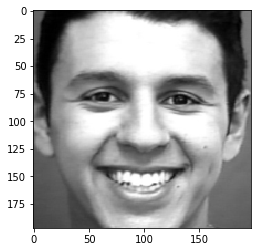

In [60]:
X_train = resize(norm_train_images, 197)
X_test = resize(norm_test_images, 197)
X_train = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_train]
X_test = [cv2.cvtColor(np.array(img),cv2.COLOR_GRAY2RGB) for img in X_test]

print(X_train[0].shape)
print(X_test[0].shape)
plt.imshow(X_train[0])

In [61]:
# Conver to 4D tensors
X_train = convert_to_tensors(X_train, 3)
X_test = convert_to_tensors(X_test, 3)
print(X_train.shape)

(4968, 197, 197, 3)


In [62]:
from keras import applications

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(197, 197,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(7, 
                    activation='softmax'))
inception_model = add_model
inception_model.compile(optimizer = 'RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
inception_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 4, 4, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_17  (None, 2048)              0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 14343     
Total params: 21,817,127
Trainable params: 14,343
Non-trainable params: 21,802,784
_________________________________________________________________


In [63]:
checkpointer = ModelCheckpoint('saved_models/weights.best.cohn.inception.hdf5', verbose=1, save_best_only=True)

history = inception_model.fit(X_train, train_labels,
                  callbacks = [checkpointer],
                  validation_split = 0.33,
                  epochs=40, batch_size = 40, verbose=1)


Train on 3328 samples, validate on 1640 samples
Epoch 1/40
3328/3328 [==============================] - 21s 6ms/step - loss: 1.6330 - acc: 0.4078 - val_loss: 2.4518 - val_acc: 0.2207

Epoch 00001: val_loss improved from inf to 2.45182, saving model to saved_models/weights.best.cohn.inception.hdf5
Epoch 2/40
3328/3328 [==============================] - 13s 4ms/step - loss: 1.2392 - acc: 0.5697 - val_loss: 2.2794 - val_acc: 0.2463

Epoch 00002: val_loss improved from 2.45182 to 2.27938, saving model to saved_models/weights.best.cohn.inception.hdf5
Epoch 3/40
3328/3328 [==============================] - 13s 4ms/step - loss: 1.0446 - acc: 0.6388 - val_loss: 2.6278 - val_acc: 0.2293

Epoch 00003: val_loss did not improve from 2.27938
Epoch 4/40
3328/3328 [==============================] - 13s 4ms/step - loss: 0.9726 - acc: 0.6695 - val_loss: 3.1214 - val_acc: 0.2280

Epoch 00004: val_loss did not improve from 2.27938
Epoch 5/40
3328/3328 [==============================] - 15s 5ms/step - los

In [64]:
inception_model.load_weights('saved_models/weights.best.cohn.inception.hdf5')

Test inception model on the cohn-kanade test images

In [65]:
predicitons = [np.argmax(inception_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in X_test]
#calculate accuracy
targets = np.argmax(test_labels, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 34.4411%


Test inception model trained on cohn-kanade on jaffe images

In [67]:
jaffe_images = convert_to_tensors(jaffe_images, 3)
predicitons = [np.argmax(inception_model.predict(np.expand_dims(test_img, axis = 0))) for test_img in jaffe_images]
#calculate accuracy
targets = np.argmax(jaffe_labels, axis = 1)
test_accuracy = (100* np.sum(predicitons == targets))/len(targets)
print('Test accuracy = %.4f%%' %(test_accuracy))

Test accuracy = 18.1319%
